In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
from datetime import datetime
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import Imputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.externals import joblib

#plot related
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
pd.set_option('max_columns',None)

from pandas.tools.plotting import scatter_matrix
from pandas.tools.plotting import bootstrap_plot as btp
from pandas.tools.plotting import andrews_curves as andc


In [30]:
!ls input

AppVersion_np_train.pkl
AutoSampleOptIn_np_train.pkl
AVProductsEnabled_np_train.pkl
AVProductsInstalled_np_train.pkl
AVProductStatesIdentifier_np_train.pkl
AvSigVersion_np_train.pkl
cat_data.pkl
Census_ActivationChannel_np_train.pkl
Census_ChassisTypeName_np_train.pkl
Census_DeviceFamily_np_train.pkl
Census_FirmwareManufacturerIdentifier_np_train.pkl
Census_FirmwareVersionIdentifier_np_train.pkl
Census_FlightRing_np_train.pkl
Census_GenuineStateName_np_train.pkl
Census_HasOpticalDiskDrive_np_train.pkl
Census_IsAlwaysOnAlwaysConnectedCapable_np_train.pkl
Census_IsFlightsDisabled_np_train.pkl
Census_IsPenCapable_np_train.pkl
Census_IsPortableOperatingSystem_np_train.pkl
Census_IsSecureBootEnabled_np_train.pkl
Census_IsTouchEnabled_np_train.pkl
Census_IsVirtualDevice_np_train.pkl
Census_MDC2FormFactor_np_train.pkl
Census_OEMModelIdentifier_np_train.pkl
Census_OEMNameIdentifier_np_train.pkl
Census_OSArchitecture_np_train.pkl
Census_OSBranch_np_train.pkl
Census_OSEdition_np_train.pkl
Census

## Utils ##

In [27]:
def get_binary_cols(df):
    return [c for c in df if c.startswith('Is') or 
                            c.startswith('Census_Is') or
                            c.startswith('Has') or
                            c.startswith('Census_Has')
           ]
    
def get_categorical_cols(df):
    dt_df = df.dtypes
    col_idx = [k for k,t in enumerate(dt_df) if t=='object']
    #cat_data = df.select_dtypes(include=['object']).copy()
    cat_cols = [c for c in df if c.endswith('Identifier') or 
                                 c.endswith('Enabled') or 
                                 c.endswith('Capable') or
                                 c.startswith('Is') or
                                 c.startswith('Has') or
                                 c.startswith('Census_Is') or
                                 c.startswith('Census_Has')
                                 ]
    cat_cols = cat_cols + ['Wdft_IsGamer','SMode', 'Firewall', 'AutoSampleOptIn', 'AVProductsInstalled', 'UacLuaenable']
    cat_set = set(cat_cols + list(dt_df[col_idx].index))
    return list(cat_set)

def to_lower(data):
    dt_df = data.dtypes
    col_idx = [k for k,t in enumerate(dt_df) if t=='object']
    cols = data.columns[col_idx]
    for c in cols:
        data[c] = data[c].str.lower()
        
    return data    

load_raw = 0

def load_h5():
    train_raw = pd.read_hdf('input/train_raw.h5', 'train_raw')
    train_raw['DisplayHorzVertRatio'] = train_raw.Census_InternalPrimaryDisplayResolutionHorizontal/train_raw.Census_InternalPrimaryDisplayResolutionVertical
        
    data_raw = pd.read_hdf('input/data_raw.h5', 'data_raw')
    data_raw['DisplayHorzVertRatio'] = data_raw.Census_InternalPrimaryDisplayResolutionHorizontal/data_raw.Census_InternalPrimaryDisplayResolutionVertical
    # drop columns 
    cols = ['DefaultBrowsersIdentifier','Census_InternalPrimaryDisplayResolutionHorizontal',
               'Census_InternalPrimaryDisplayResolutionVertical']

    #drop following columns because of the too many NAN
    cols = cols + ['Census_IsWIMBootEnabled','Census_ThresholdOptIn','Census_InternalBatteryType',
          'Census_IsFlightingInternal','Census_ProcessorClass','PuaMode']
    data_raw.drop(cols, axis=1, inplace=True)
    
    labels = pd.read_hdf('input/labels.h5', 'labels')
    
    return train_raw, labels, data_raw
    #return train_raw, labels, data_raw

    
def load_cat_non_cat_data():
    cat_data = pd.read_pickle('input/cat_data.pkl')
    non_cat_data = pd.read_pickle('input/non_cat_data.pkl')
    for c in cat_data.columns:
        cat_data[c] = cat_data[c].astype('category')
    return cat_data, non_cat_data

def binary_encode(df, col_names=[], label_col='HasDetections', accumulate=True, return_df=True, dynamic_n_component = False, drop_invariant = True, debug=True, save_intermediate_results=False):
    if not col_names:
        col_names = list(df.columns)
    if label_col in col_names:    
        col_names.remove(label_col)
        
    _frames = []
    _cols_arr = []
    for c in col_names:
        if debug:
            print('processing: {}'.format(c))
            
        _model = df[[c]]
        
        _enc = ce.BinaryEncoder(cols=[c], return_df=return_df, drop_invariant=drop_invariant)
        _enc.fit(_model, df[label_col])
        
        _df = _enc.transform(_model)
        
#        if return_df:
#            _df.columns = '{}_'.format(c)+ _df.columns
#        else:    
#            _cols_arr.append(c) 
        
        if accumulate:    
            _frames.append(_df)
            
        if save_intermediate_results:
            _dict = {'col': c, 'bin_enc': _enc, 'data': _df}
            _fl_name = 'input/{}_df_train.pkl'.format(c) if return_df else 'input/{}_np_train.pkl'.format(c)
            joblib.dump(_dict, _fl_name)
            
    return (pd.concat(_frames, axis=1), _enc) if return_df else (_frames, _cols_arr, _enc)
   
def hash_encode(df, label_col='HasDetections', accumulate=True, return_df=True, dynamic_n_component = False, drop_invariant = True, debug=True, save_intermediate_results=False):
    col_names = list(df.columns)
    col_names.remove(label_col)
    _frames = []
    _cols_arr = []
    for c in col_names:
        if debug:
            print('processing: {}'.format(c))
            
        _model = df[[c]]
        
        _val_ct = df[c].value_counts().count()
        
        _n_comp = 8* int(np.log(_val_ct)) if dynamic_n_component and _val_ct > 10 else 8
                    
        hash_enc = ce.HashingEncoder(cols=[c], return_df=return_df, n_components=_n_comp, drop_invariant=drop_invariant)
        hash_enc.fit(_model, df[label_col])
        
        _df = hash_enc.transform(_model)
        
        if return_df:
            _df.columns = '{}_'.format(c)+ _df.columns
        else:    
            _cols_arr.append(c) 
        
        if accumulate:    
            _frames.append(_df)
            
        if save_intermediate_results:
            _dict = {'col': c, 'hash_enc': hash_enc, 'data': _df}
            _fl_name = 'input/{}_df_train.pkl'.format(c) if return_df else 'input/{}_np_train.pkl'.format(c)
            joblib.dump(_dict, _fl_name)
            
    return pd.concat(_frames, axis=1) if return_df else (_frames, _cols_arr)

In [2]:
%%time
train_set = pd.read_hdf('input/train_set.hd5', 'train_set')

CPU times: user 24.5 s, sys: 6.85 s, total: 31.3 s
Wall time: 31.4 s


In [4]:
train_set.HasTpm.value_counts()

1    7051337
0      85849
Name: HasTpm, dtype: int64

In [5]:
binary_cols = get_binary_cols(cat_data)

In [28]:
%%time
col_names = get_binary_cols(cat_data)
col_names = ['SmartScreen']
#res_df = hash_encode(cat_data, dynamic_n_component=True,debug=True,drop_invariant=False)
bin_res_df = binary_encode(cat_data, col_names=col_names, save_intermediate_results=True, accumulate=True, return_df=True, dynamic_n_component=True,debug=True,drop_invariant=False)

processing: SmartScreen
CPU times: user 3min 26s, sys: 11.4 s, total: 3min 38s
Wall time: 3min 44s


In [32]:
_enc = bin_res_df[1]

{'SmartScreen': 5}

In [41]:
_enc.handle_unknown

'impute'

In [42]:
%%time
_oneHotEnc = ce.OneHotEncoder(cols='SmartScreen', return_df=True)
res = _oneHotEnc.encode()

In [21]:
bin_res_df.head()

SmartScreen_0  SmartScreen_1  SmartScreen_2  SmartScreen_3  SmartScreen_4
0              0              0              0              0              0
1              0              0              0              0              0
2              0              0              0              1              0
3              0              0              0              1              1
4              0              0              0              1              0

In [22]:
cat_data.SmartScreen.head()

0             NaN
1             NaN
2    requireadmin
3    existsnotset
4    requireadmin
Name: SmartScreen, dtype: object

In [23]:
cat_data.SmartScreen.value_counts()

requireadmin    4316194
existsnotset    1046183
off              187907
warn             135484
prompt            34534
block             22533
on                  878
&#x02;              416
&#x01;              335
0                     3
promt                 2
enabled               1
&#x03;                1
00000000              1
Name: SmartScreen, dtype: int64

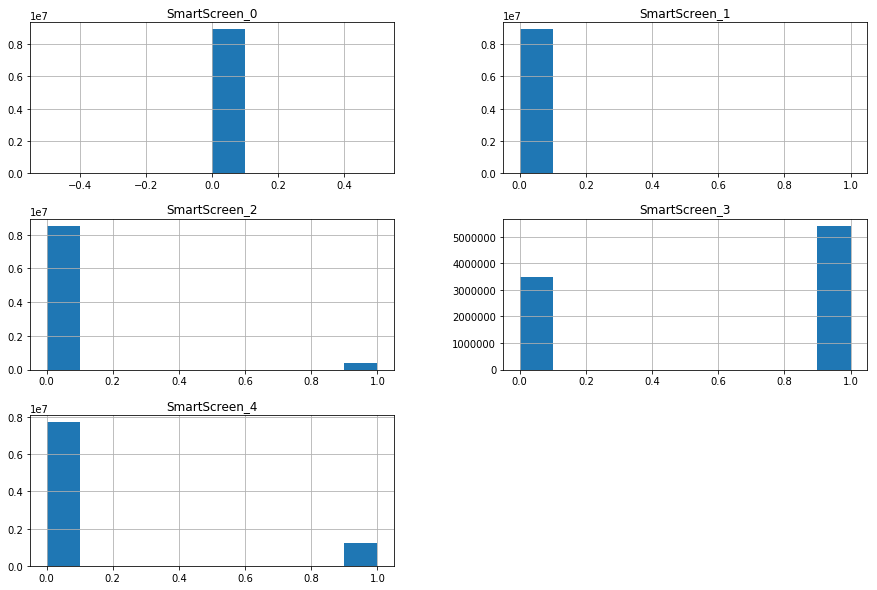

In [26]:
_=bin_res_df.hist(figsize=(15,10))

In [29]:
%%time
sm_df = cat_data.head(100)
res_sm_df = hash_encode(sm_df,save_intermediate_results=True, accumulate=False, return_df=False, dynamic_n_component=True,debug=True,drop_invariant=False)

processing: IeVerIdentifier
processing: Census_IsFlightsDisabled
processing: Census_HasOpticalDiskDrive
processing: Census_OSInstallLanguageIdentifier
processing: LocaleEnglishNameIdentifier
processing: Census_IsPortableOperatingSystem
processing: Census_IsTouchEnabled
processing: Census_OSUILocaleIdentifier
processing: Census_IsPenCapable
processing: Census_DeviceFamily
processing: Census_PowerPlatformRoleName
processing: Census_OSBranch
processing: OrganizationIdentifier
processing: Census_IsVirtualDevice
processing: AVProductsInstalled
processing: Census_IsSecureBootEnabled
processing: SMode
processing: Census_OSWUAutoUpdateOptionsName
processing: Census_OEMModelIdentifier
processing: UacLuaenable
processing: HasTpm
processing: IsBeta
processing: Platform
processing: OsVer
processing: EngineVersion
processing: Census_PrimaryDiskTypeName
processing: Census_OSArchitecture
processing: OsPlatformSubRelease
processing: Census_FirmwareManufacturerIdentifier
processing: Census_OEMNameIdent

In [19]:
res_sm_df[0][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Read raw data

In [4]:
#%%time
#train_raw = pd.read_csv('input/train.csv')
#labels = train_raw['HasDetections']
#data_raw = train_raw.drop(["HasDetections"], axis=1)

CPU times: user 2min 4s, sys: 9.65 s, total: 2min 14s
Wall time: 2min 14s


### Save as h5

In [212]:
%%time
#train_raw.to_hdf('input/train_raw.h5', 'train_raw')
#labels.to_hdf('input/labels.h5', 'labels')
#data_raw.to_hdf('input/data_raw.h5', 'data_raw')

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 16.5 µs


### Split the data in categorical and numeric ###

In [3]:
%%time
if load_raw==1:
    train_raw, labels, data_raw = load_h5(load_train_raw=True, load_data_raw=True)
    load_raw =0
    
    cat_cols = get_categorical_cols(data_raw)
    cat_cols.remove('MachineIdentifier')
    cat_data = data_raw[cat_cols]
    
    for c in cata_data:
        c.dtype='category'

    cat_data = to_lower(cat_data)
    non_cat_data = data_raw.drop(cat_cols, axis=1)
    non_cat_data.drop('MachineIdentifier')
    non_cat_data['HasDetections'] = labels
    cat_data['HasDetections'] = labels
    #Save as pkl
    non_cat_data.to_pickle('input/non_cat_data.pkl')
    cat_data.to_pickle('input/cat_data.pkl')

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 15.3 µs


In [70]:
#cat_data_2 = cat_data.copy()
cat_cols = cat_data_2.columns

for c in cat_cols:
    cat_data_2[c] = cat_data_2[c].astype('category')

In [19]:
cat_data.head()

IeVerIdentifier  Census_IsFlightsDisabled  Census_HasOpticalDiskDrive  \
0            137.0                       0.0                           0   
1            137.0                       0.0                           0   
2            137.0                       0.0                           0   
3            137.0                       0.0                           0   
4            137.0                       0.0                           0   

   Census_OSInstallLanguageIdentifier  LocaleEnglishNameIdentifier  \
0                                26.0                          171   
1                                 8.0                           64   
2                                 7.0                           49   
3                                17.0                          115   
4                                 8.0                           75   

   Census_IsPortableOperatingSystem  Census_IsTouchEnabled  \
0                                 0                      0   
1                                 0                      0   
2                                 0                      0   
3                                 0                      0   
4                                 0                      0   

   Census_OSUILocaleIdentifier  Census_IsPenCapable Census_DeviceFamily  \
0                          119                    0     windows.desktop   
1                           31                    0     windows.desktop   
2                           30                    0     windows.desktop   
3                           64                    0     windows.desktop   
4                           31                    0     windows.desktop   

  Census_PowerPlatformRoleName Census_OSBranch  OrganizationIdentifier  \
0                      desktop     rs4_release                    18.0   
1                       mobile     rs4_release                    18.0   
2                      desktop     rs4_release                    18.0   
3                      desktop     rs4_release                     NaN   
4                       mobile     rs4_release                     NaN   

   Census_IsVirtualDevice  AVProductsInstalled  Census_IsSecureBootEnabled  \
0                     0.0                  1.0                           0   
1                     0.0                  1.0                           0   
2                     0.0                  1.0                           0   
3                     0.0                  1.0                           0   
4                     0.0                  1.0                           0   

   SMode Census_OSWUAutoUpdateOptionsName  Census_OEMModelIdentifier  \
0    0.0                          unknown                     9124.0   
1    0.0                          unknown                    91656.0   
2    0.0                         fullauto                   317701.0   
3    0.0                         fullauto                   275890.0   
4    0.0                         fullauto                   331929.0   

   UacLuaenable  HasTpm  IsBeta   Platform     OsVer EngineVersion  \
0           1.0       1       0  windows10  10.0.0.0   1.1.15100.1   
1           1.0       1       0  windows10  10.0.0.0   1.1.14600.4   
2           1.0       1       0  windows10  10.0.0.0   1.1.15100.1   
3           1.0       1       0  windows10  10.0.0.0   1.1.15100.1   
4           1.0       1       0  windows10  10.0.0.0   1.1.15100.1   

  Census_PrimaryDiskTypeName Census_OSArchitecture OsPlatformSubRelease  \
0                        hdd                 amd64                  rs4   
1                        hdd                 amd64                  rs4   
2                        ssd                 amd64                  rs4   
3                    unknown                 amd64                  rs4   
4                        hdd                 amd64                  rs4   

   Census_FirmwareManufacturerIdentifier  Census_OEMNameIdentifier  \
0           

In [ ]:
def create_dpd_cat(data):            
    data['DPD_CAT'] = pd.Series('DPD_0', index=data.index)
    data.loc[((data.SK_DPD_DEF>0) & (data.SK_DPD_DEF<=30)), 'DPD_CAT'] = 'DPD_30'
    data.loc[((data.SK_DPD_DEF>30) & (data.SK_DPD_DEF<=60)), 'DPD_CAT'] = 'DPD_60'
    data.loc[((data.SK_DPD_DEF>60) & (data.SK_DPD_DEF<=90)), 'DPD_CAT'] = 'DPD_90'
    data.loc[((data.SK_DPD_DEF>90) & (data.SK_DPD_DEF<=120)), 'DPD_CAT'] = 'DPD_120'
    data.loc[(data.SK_DPD_DEF>120), 'DPD_CAT'] = 'WRITE_OFF'

In [ ]:
cols = {0:'NEW_CLIENT',1:'REFRESHED_CLIENT',2:'REPEATER_CLIENT',3:'XNA_CLIENT'}
encoder = LabelBinarizer()
client_type_1hot = pd.DataFrame(encoder.fit_transform(prev_app.NAME_CLIENT_TYPE), index=prev_app.index).rename(columns=cols)

cols = {0:'CONTRACT_APPROVED',1:'COTRACT_CANCELED',2:'CONTRACT_REFUSED',3:'CONTRACT_UNUSED'}
encoder = LabelBinarizer()
contract_status_1hot = pd.DataFrame(encoder.fit_transform(prev_app.NAME_CONTRACT_STATUS), index=prev_app.index).rename(columns=cols)

cols = {0:'CASH_LOAN_CONTRACTS',1:'CONSUMER_LOAN_CONTRACTS',2:'REVOLVING_LOAN_CONTRACTS',3:'XNA_CONTRACTS'}
encoder = LabelBinarizer()
contract_type_1hot = pd.DataFrame(encoder.fit_transform(prev_app.NAME_CONTRACT_TYPE), index=prev_app.index).rename(columns=cols)

cols = {0:'YIELD_GRP_XNA',1:'YIELD_GRP_HIGH',2:'YIELD_GRP_LOW',3:'YIELD_GRP_NORMAL',4:'YIELD_GRP_MIDDLE'}

encoder = LabelBinarizer()
yield_grp_1hot = pd.DataFrame(encoder.fit_transform(prev_app.NAME_YIELD_GROUP), index=prev_app.index).rename(columns=cols)

cols = {0:'CHANNEL_AP',1:'CHANNEL_CAR_DEALER',2:'CHANNEL_CORP',3:'CHANNEL_CONTACT',4:'CHANNEL_COUNTRY_WIDE',
       5:'CHANNEL_CREDIT_CASH', 6:'CHANNEL_REGIONAL', 7: 'CHANNEL_STONE'}

encoder = LabelBinarizer()
channel_type_1hot = pd.DataFrame(encoder.fit_transform(prev_app.CHANNEL_TYPE), index=prev_app.index).rename(columns=cols)

cols = {0:'PROD_CARD_STREET', 1:'PROD_CARD_XSELL', 2:'PROD_CASH', 3:'PROD_CASH_STREET_H',
        4:'PROD_CASH_STREET_L', 5:'PROD_CASH_STREET_M',
        6:'PROD_CASH_XSELL_HIGH', 7:'PROD_CASH_XSELL_LOW', 8:'PROD_CASH_XSELL_MID', 
        9: 'PROD_POS_HOUSE_W_INT', 10: 'PROD_POS_HOUSE_WO_INT',
       11: 'PROD_POS_INDUS_W_INT', 12: 'PROD_POS_INDUS_WO_INT',
       13: 'PROD_POS_MOBIL_W_INT', 14: 'PROD_POS_MOBIL_WO_INT',
       15: 'PROD_POS_OTH_W_INT', 16: 'PROD_POS_OTH_WO_INT',
       17: 'PROD_XNA'}

encoder = LabelBinarizer()
prod_combo_1hot = pd.DataFrame(encoder.fit_transform(prev_app.PRODUCT_COMBINATION), index=prev_app.index).rename(columns=cols)

cols = {0:'PORTFOLIO_CARDS', 1:'PORTFOLIO_CARS', 2:'PORTFOLIO_CASH', 3:'PORTFOLIO_POS',        
       4: 'PORTFOLIO_XNA'}

encoder = LabelBinarizer()
portfolio_1hot = pd.DataFrame(encoder.fit_transform(prev_app.NAME_PORTFOLIO), index=prev_app.index).rename(columns=cols)

cols = {0:'CREDIT_LT_APP', 1:'CREDIT_GT_APP', 2:'CREDIT_EQ_APP'}
encoder = LabelBinarizer()
credit_minus_app_1hot = pd.DataFrame(encoder.fit_transform(prev_app.AMT_CREDIT_MINUS_APP), index=prev_app.index).rename(columns=cols)

concat_pds = [prev_app, client_type_1hot, contract_status_1hot, contract_type_1hot,
              yield_grp_1hot, channel_type_1hot, prod_combo_1hot, portfolio_1hot,
              credit_minus_app_1hot]

prev_app = pd.concat(concat_pds, axis=1)

drop_cols = ['NAME_CLIENT_TYPE','NAME_CONTRACT_STATUS','NAME_CONTRACT_TYPE','NAME_YIELD_GROUP',
             'CHANNEL_TYPE', 'PRODUCT_COMBINATION', 'NAME_PORTFOLIO', 'AMT_CREDIT_MINUS_APP']
prev_app.drop(drop_cols, axis=1, inplace=True)

## Exploration ###

In [4]:
%%time
cat_data, non_cat_data = load_cat_non_cat_data()

CPU times: user 2min 27s, sys: 27 s, total: 2min 54s
Wall time: 2min 54s


### Get count_values for categorical columns ###

In [5]:
%%time
cat_cols = list(cat_data.columns)
cat_cols.remove('HasDetections')
col_value_counts = pd.DataFrame.from_dict({c:cat_data[c].value_counts().count() for c in cat_cols}, orient='index')
col_value_counts = col_value_counts.rename(columns={0:'col_value_counts'})

CPU times: user 1min 17s, sys: 3.96 s, total: 1min 21s
Wall time: 1min 20s


In [152]:
hashEnc = ce.HashingEncoder(cols=['Census_OEMModelIdentifier'])
hashEnc.fit(cat_data, cat_data.HasDetections)

HashingEncoder(cols=['Census_OEMModelIdentifier'], drop_invariant=False,
        hash_method='md5', n_components=8, return_df=True, verbose=0)

### Hash encoding the categorical variables ###

In [32]:
ignore_columns = ['IeVerIdentifier','Census_IsFlightsDisabled',
             'Census_HasOpticalDiskDrive','Census_OSInstallLanguageIdentifier',
             'LocaleEnglishNameIdentifier','Census_IsPortableOperatingSystem',
             'Census_IsTouchEnabled','Census_OSUILocaleIdentifier',
             'Census_IsPenCapable','Census_DeviceFamily','Census_PowerPlatformRoleName',
             'Census_OSBranch','OrganizationIdentifier','Census_IsVirtualDevice',
             'AVProductsInstalled']

In [46]:
sa = np.array_split(ignore_columns, 8)
for c in sa:
    for i in c:
        print(i)

IeVerIdentifier
Census_IsFlightsDisabled
Census_HasOpticalDiskDrive
Census_OSInstallLanguageIdentifier
LocaleEnglishNameIdentifier
Census_IsPortableOperatingSystem
Census_IsTouchEnabled
Census_OSUILocaleIdentifier
Census_IsPenCapable
Census_DeviceFamily
Census_PowerPlatformRoleName
Census_OSBranch
OrganizationIdentifier
Census_IsVirtualDevice
AVProductsInstalled


In [31]:
%%time
#res_df = hash_encode(cat_data, dynamic_n_component=True,debug=True,drop_invariant=False)
res_df = hash_encode(cat_data, save_intermediate_results=True, accumulate=False, return_df=False, dynamic_n_component=True,debug=True,drop_invariant=False)

processing: IeVerIdentifier
processing: Census_IsFlightsDisabled
processing: Census_HasOpticalDiskDrive
processing: Census_OSInstallLanguageIdentifier
processing: LocaleEnglishNameIdentifier
processing: Census_IsPortableOperatingSystem
processing: Census_IsTouchEnabled
processing: Census_OSUILocaleIdentifier
processing: Census_IsPenCapable
processing: Census_DeviceFamily
processing: Census_PowerPlatformRoleName
processing: Census_OSBranch
processing: OrganizationIdentifier
processing: Census_IsVirtualDevice
processing: AVProductsInstalled
processing: Census_IsSecureBootEnabled


KeyboardInterrupt: 

In [354]:
res_sm_df.head()

IeVerIdentifier_col_0  IeVerIdentifier_col_1  IeVerIdentifier_col_2  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   IeVerIdentifier_col_3  IeVerIdentifier_col_4  IeVerIdentifier_col_5  \
0                      0                      1                      0   
1                      0                      1                      0   
2                      0                      1                      0   
3                      0                      1                      0   
4                      0                      1                      0   

   IeVerIdentifier_col_6  IeVerIdentifier_col_7  \
0                      0                      0   
1                      0                      0   
2                      0                      0   
3                      0                      0   
4                      0                      0   

   Census_IsFlightsDisabled_col_0  Census_IsFlightsDisabled_col_1  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   Census_IsFlightsDisabled_col_2  Census_IsFlightsDisabled_col_3  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   Census_IsFlightsDisabled_col_4  Census_IsFlightsDisabled_col_5  \
0                               1                               0   
1                               1                               0   
2                               1                               0   
3                               1                               0   
4                               1                               0   

   Census_IsFlightsDisabled_col_6  Census_IsFlightsDisabled_col_7  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   Census_HasOpticalDiskDrive_col_0  Census_HasOpticalDiskDrive_col_1  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   Census_HasOpticalDiskDrive_col_2  Census_HasOpticalDiskDrive_col_3  \
0                                 1                                 0   
1                                 1                                 0   
2                                 1                                 0   
3                                 1                                 0   
4                                 1                                 0   

   Census_HasOpticalDiskDrive_col_4  Census_HasOpticalDiskDrive_col_5  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0              

In [233]:
small_df = cat_data_2.head()

In [153]:
%%time
dd = hashEnc.transform(cat_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8abd9abd30>,
      dtype=object)

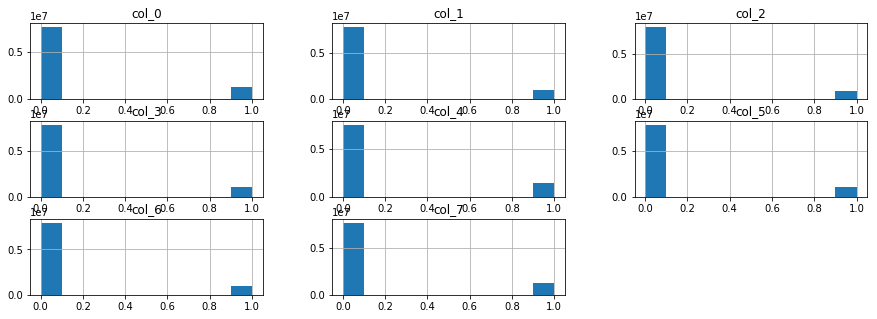

In [223]:
_ = dd[['col_0','col_1','col_2','col_3','col_4','col_5','col_6','col_7']].hist(figsize=(15,5))

In [230]:
hashEnc.get_params

<bound method HashingEncoder.get_params of HashingEncoder(cols=['Census_OEMModelIdentifier'], drop_invariant=False,
        hash_method='md5', n_components=8, return_df=True, verbose=0)>

In [3]:
geo_data=cat_data[['HasDetections','CityIdentifier','CountryIdentifier','GeoNameIdentifier','LocaleEnglishNameIdentifier']]

In [ ]:
_ = sns.pairplot(geo_data, diag_kind="kde")

In [53]:
geo_corr_matrix.CityIdentifier

HasDetections                 -0.002282
CityIdentifier                 1.000000
CountryIdentifier              0.000207
GeoNameIdentifier             -0.059277
LocaleEnglishNameIdentifier    0.026225
Name: CityIdentifier, dtype: float64

In [60]:
col_value_counts.sort_values(by='col_value_counts', ascending=False)

col_value_counts
Census_OEMModelIdentifier                          175365
CityIdentifier                                     107366
Census_FirmwareVersionIdentifier                    50494
AVProductStatesIdentifier                           28970
AvSigVersion                                         8531
Census_OEMNameIdentifier                             3832
Census_ProcessorModelIdentifier                      3428
Census_FirmwareManufacturerIdentifier                 712
OsBuildLab                                            663
Census_OSVersion                                      469
IeVerIdentifier                                       303
GeoNameIdentifier                                     292
LocaleEnglishNameIdentifier                           276
CountryIdentifier                                     222
Census_OSUILocaleIdentifier                           147
AppVersion                                            110
EngineVersion                                          70
OsVer                                                  58
Census_ChassisTypeName                                 51
OrganizationIdentifier                                 49
Census_OSInstallLanguageIdentifier                     39
Census_OSBranch                                        32
Census_OSEdition                                       32
Census_OSSkuName                                       30
Wdft_RegionIdentifier                                  15
SmartScreen                                            14
Census_MDC2FormFactor                                  13
UacLuaenable                                           11
Census_FlightRing                                      10
Census_PowerPlatformRoleName                           10
...                                                   ...
OsPlatformSubRelease                                    9
AVProductsInstalled                                     8
SkuEdition                                              8
Census_ProcessorManufacturerIdentifier                  7
ProductName                                             6
AVProductsEnabled                                       6
Census_ActivationChannel                                6
Census_OSWUAutoUpdateOptionsName                        6
Census_GenuineStateName                                 5
Census_PrimaryDiskTypeName                              4
Platform                                                4
Census_DeviceFamily                                     3
Census_OSArchitecture                                   3
Processor                                               3
Census_IsTouchEnabled                                   2
SMode                                                   2
Firewall                                                2
Census_IsPortableOperatingSystem                        2
IsSxsPassiveMode                                        2
AutoSampleOptIn                                         2
Census_IsSecureBootEnabled                              2
Census_IsAlwaysOnAlwaysConnectedCapable                 2
Census_IsPenCapable                                     2
Census_IsFlightsDisabled                                2
IsBeta                                                  2
HasTpm                                                  2
Census_IsVirtualDevice                                  2
Census_HasOpticalDiskDrive                              2
Wdft_IsGamer                                            2
IsProtected                                             2

[61 rows x 1 columns]

In [6]:
grpByOemModel = cat_data.groupby(['Census_OEMModelIdentifier','HasDetections']).size().to_frame('size').reset_index()
mostInfectedByOemModel = grpByOemModel[grpByOemModel.HasDetections==1].sort_values(by=['size'], ascending=False)
leastInfectedByOemModel = grpByOemModel[grpByOemModel.HasDetections==0].sort_values(by=['size'])
np.intersect1d(mostInfectedByOemModel.Census_OEMModelIdentifier.head(100), leastInfectedByOemModel.Census_OEMModelIdentifier.head(100))

array([], dtype=float64)

In [99]:
mostInfectedByOemModel['infection_prob'] = mostInfectedByOemModel['size']/mostInfectedByOemModel.shape[0]

In [100]:
mostInfectedByOemModel.describe()

Census_OEMModelIdentifier  HasDetections           size  infection_prob
count              121458.000000       121458.0  121458.000000   121458.000000
mean               183408.369321            1.0      36.312487        0.000299
std                102277.504391            0.0     778.755332        0.006412
min                     1.000000            1.0       1.000000        0.000008
25%                 99042.250000            1.0       1.000000        0.000008
50%                187036.000000            1.0       2.000000        0.000016
75%                276489.500000            1.0       5.000000        0.000041
max                345496.000000            1.0  168849.000000        1.390184

In [98]:
mostInfectedByOemModel['size'].quantile(q=.99)

587.429999999993

In [109]:
mostInfectedByOemModel.tail(10)

Census_OEMModelIdentifier  HasDetections  size  infection_prob
102598                   155931.0              1     1        0.000008
102554                   155857.0              1     1        0.000008
102587                   155915.0              1     1        0.000008
102584                   155910.0              1     1        0.000008
102578                   155904.0              1     1        0.000008
102572                   155887.0              1     1        0.000008
102565                   155880.0              1     1        0.000008
102563                   155877.0              1     1        0.000008
102559                   155862.0              1     1        0.000008
252982                   345496.0              1     1        0.000008

In [112]:
leastInfectedByOemModel.tail(10)

Census_OEMModelIdentifier  HasDetections    size
168687                   248045.0              0   22661
167008                   244755.0              0   23606
126128                   188345.0              0   30007
167498                   245824.0              0   30229
165836                   241876.0              0   32760
159245                   228975.0              0   40169
224605                   317708.0              0   54158
224598                   317701.0              0   64266
166130                   242491.0              0  126602
221340                   313586.0              0  135933

In [114]:
cat_data[cat_data.Census_OEMModelIdentifier==242491.0].shape

(263382, 62)

In [52]:
mostInfectedByOemModel.sort_values(by=['Census_OEMModelIdentifier','size'], ascending=True)

Census_OEMModelIdentifier  HasDetections  size  infection_prob
1                             1.0              1     1    1.120890e-07
2                             3.0              1     1    1.120890e-07
5                            15.0              1     1    1.120890e-07
8                            22.0              1    20    2.241780e-06
10                           23.0              1    34    3.811026e-06
11                           29.0              1     1    1.120890e-07
13                           31.0              1     2    2.241780e-07
14                           33.0              1     1    1.120890e-07
15                           34.0              1     1    1.120890e-07
16                           36.0              1     1    1.120890e-07
21                           56.0              1     1    1.120890e-07
23                           61.0              1     1    1.120890e-07
24                           64.0              1     1    1.120890e-07
26                           71.0              1     1    1.120890e-07
27                           78.0              1     1    1.120890e-07
33                           95.0              1     1    1.120890e-07
34                          110.0              1     1    1.120890e-07
36                          116.0              1     1    1.120890e-07
37                          118.0              1     1    1.120890e-07
41                          127.0              1     3    3.362670e-07
43                          128.0              1     2    2.241780e-07
46                          133.0              1     1    1.120890e-07
48                          135.0              1     5    5.604449e-07
50                          137.0              1     1    1.120890e-07
53                          142.0              1     4    4.483560e-07
54                          149.0              1     1    1.120890e-07
56                          150.0              1   142    1.591664e-05
58                          152.0              1    12    1.345068e-06
60                          153.0              1     3    3.362670e-07
63                          156.0              1   159    1.782215e-05
...                           ...            ...   ...             ...
252934                   345403.0              1     1    1.120890e-07
252935                   345405.0              1     1    1.120890e-07
252936                   345407.0              1     1    1.120890e-07
252938                   345410.0              1     1    1.120890e-07
252939                   345413.0              1     1    1.120890e-07
252940                   345418.0              1     1    1.120890e-07
252943                   345424.0              1     1    1.120890e-07
252945                   345433.0              1     1    1.120890e-07
252946                   345437.0              1     1    1.120890e-07
252947                   345443.0              1     1    1.120890e-07
252949                   345448.0              1     1    1.120890e-07
252950                   345449.0              1     1    1.120890e-07
252952                   345456.0              1     1    1.120890e-07
252954                   345461.0              1     1    1.120890e-07
252958                   345464.0              1    12    1.345068e-06
252959                   345470.0              1     5    5.604449e-07
252961                   345473.0              1     3    3.362670e-07
252962                   345475.0              1     1    1.120890e-07
252964                   345476.0              1     1    1.120890e-07
252968                   345480.0              1     9    1.008801e-06
252969                   345481.0              1     1    1.120890e-07
252971                   345485.0              1     2    2.241780e-07
252972                   345488.0              1     1    1.120890e-07
252974                   345489.0              1     1    1.120890e-07
252976                   345490.

(1685, 2000)

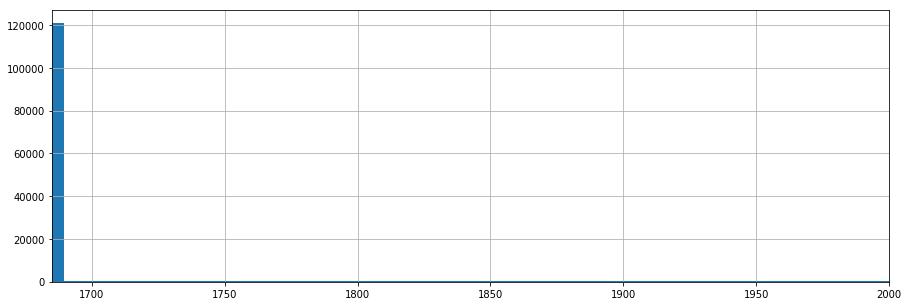

In [81]:
mostInfectedByOemModel['size'].hist(figsize=(15,5), bins=100).set_xlim(1685,2000)

In [85]:
mostInfectedByOemModel[mostInfectedByOemModel['size']>1600].shape

(435, 4)

In [69]:
mostInfectedByOemModel[mostInfectedByOemModel['size']<100].shape

(116862, 4)

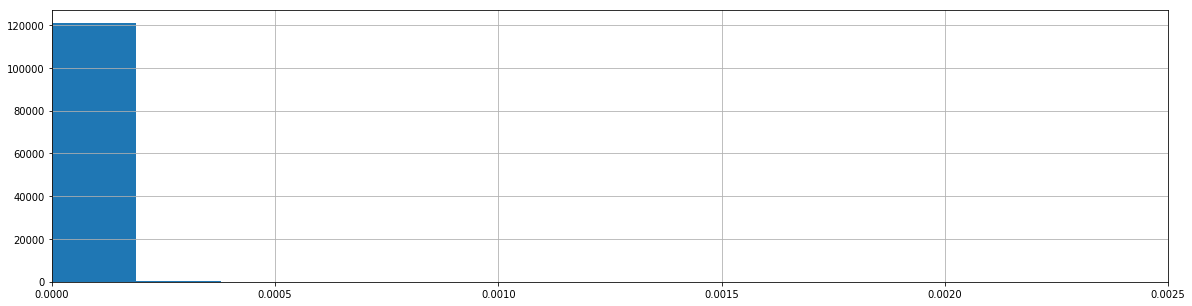

In [30]:
_=mostInfectedByOemModel.infection_prob.hist(figsize=(20,5), bins=100).set_xlim(0,.0025)

In [115]:
grpByCity = cat_data.groupby(['CityIdentifier','HasDetections']).size().to_frame('size').reset_index()
mostInfectedByCity = grpByCity[grpByCity.HasDetections==1].sort_values(by=['size'], ascending=False)
leastInfectedByCity = grpByCity[grpByCity.HasDetections==0].sort_values(by=['size'])
np.intersect1d(mostInfectedByCity.CityIdentifier.head(100), leastInfectedByCity.CityIdentifier.head(100))

array([], dtype=float64)

In [116]:
mostInfectedByCity.describe()

CityIdentifier  HasDetections          size
count    86765.000000        86765.0  86765.000000
mean     83907.511981            1.0     49.548816
std      48601.919276            0.0    602.483721
min          5.000000            1.0      1.000000
25%      41432.000000            1.0      1.000000
50%      84403.000000            1.0      3.000000
75%     126128.000000            1.0     10.000000
max     167962.000000            1.0  46553.000000

In [117]:
leastInfectedByCity.describe()

CityIdentifier  HasDetections          size
count    88622.000000        88622.0  88622.000000
mean     84093.776342            0.0     48.486504
std      48684.001540            0.0    577.668699
min          5.000000            0.0      1.000000
25%      41531.250000            0.0      1.000000
50%      84639.500000            0.0      3.000000
75%     126422.750000            0.0     10.000000
max     167962.000000            0.0  48259.000000

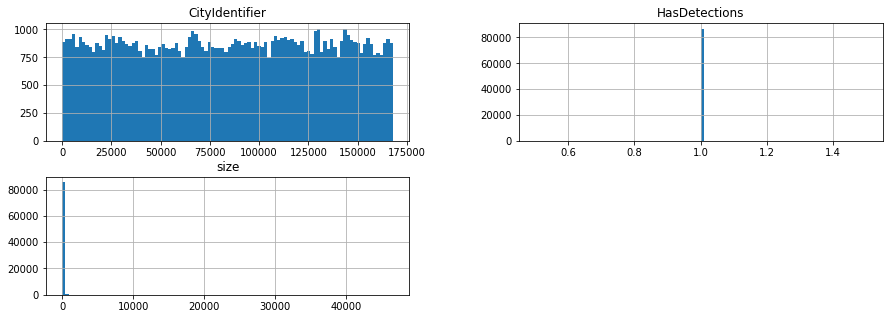

In [120]:
_=mostInfectedByCity.hist(bins=100, figsize=(15,5))

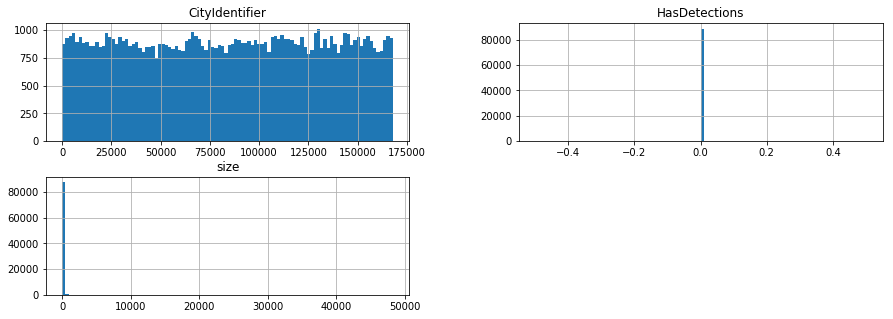

In [121]:
_=leastInfectedByCity.hist(bins=100, figsize=(15,5))

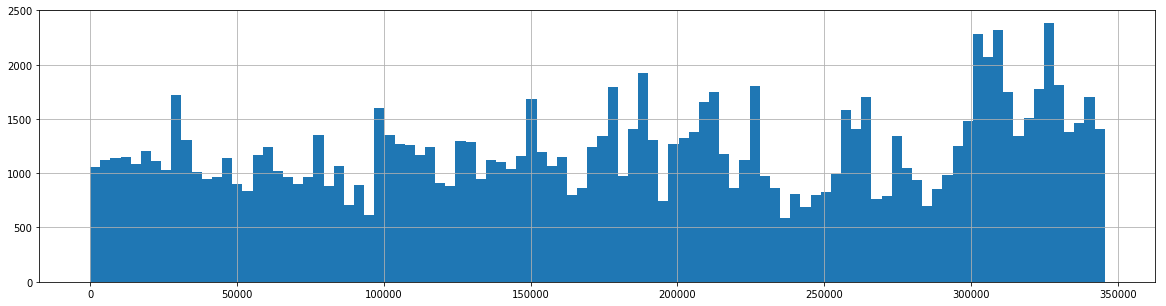

In [35]:
_ = mostInfectedByOemModel['Census_OEMModelIdentifier'].hist(bins=100, figsize=(20,5))

In [5]:
grpByAvSig = cat_data.groupby(['AvSigVersion','HasDetections']).size().to_frame('entry_count').reset_index()
mostInfectedByAvSig = grpByAvSig[grpByAvSig.HasDetections==1].sort_values(by=['entry_count'], ascending=False)
leastInfectedByAvSig = grpByAvSig[grpByAvSig.HasDetections==0].sort_values(by=['entry_count'])
np.intersect1d(mostInfectedByAvSig.AvSigVersion.head(100), leastInfectedByAvSig.AvSigVersion.head(100))

array([], dtype=object)

In [14]:
hundredMostInfected = mostInfectedByAvSig.head(100)
hundredLeastInfected = leastInfectedByAvSig.head(100)

In [62]:
mostInfectedByAvSig.head()

AvSigVersion  HasDetections  entry_count
14974  1.273.1420.0              1        57252
15216  1.273.1826.0              1        48004
16409   1.275.727.0              1        46108
12192    1.263.48.0              1        45767
15298   1.273.371.0              1        45375

In [58]:
leastInfectedByAvSig.tail()

AvSigVersion  HasDetections  entry_count
8640     1.251.42.0              0        42358
14973  1.273.1420.0              0        45065
16408   1.275.727.0              0        46340
12191    1.263.48.0              0        52257
15680  1.275.1140.0              0        53600

In [7]:
grpByAvSig.sort_values(by='entry_count', ascending=False).head()

AvSigVersion  HasDetections  entry_count
14974  1.273.1420.0              1        57252
15680  1.275.1140.0              0        53600
12191    1.263.48.0              0        52257
15216  1.273.1826.0              1        48004
16408   1.275.727.0              0        46340

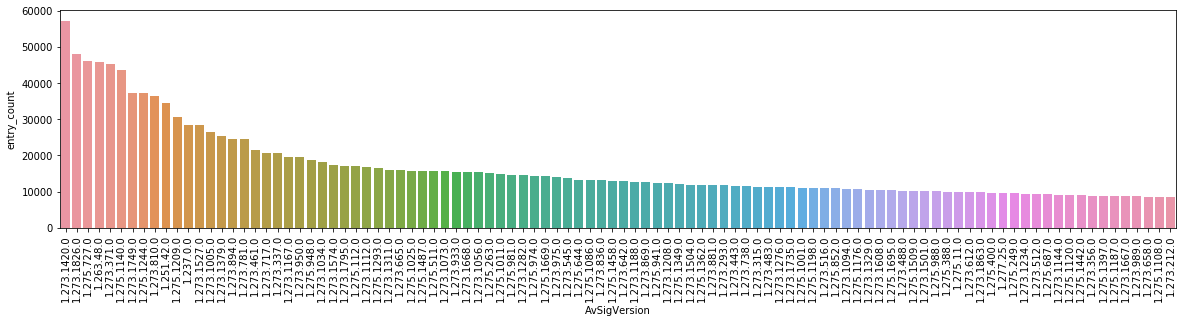

In [46]:
x=sns.barplot(x=hundredMostInfected.AvSigVersion, y=hundredMostInfected.entry_count)
x.figure.set_figwidth(20)

_=plt.setp(x.get_xticklabels(), rotation=90)

In [133]:
avSigVersionValueCount_2 = cat_data_2['HasDetections'==1].AvSigVersion.value_counts()
#_=sns.barplot(avSigVersionValueCount.index, avSigVersionValueCount.values)

KeyError: False

In [138]:
cat_data_2[cat_data_2.HasDetections==1]

(4458892, 62)

In [82]:
dd = avSigVersionValueCount_2.count()

In [93]:
avSigVersionValueCount_2.describe()

count      8531.000000
mean       1045.772242
std        4500.010045
min           1.000000
25%          14.000000
50%          40.000000
75%         177.000000
max      102317.000000
Name: AvSigVersion, dtype: float64

In [97]:
avSigVersionValueCount.quantile(q=.8)

303.0

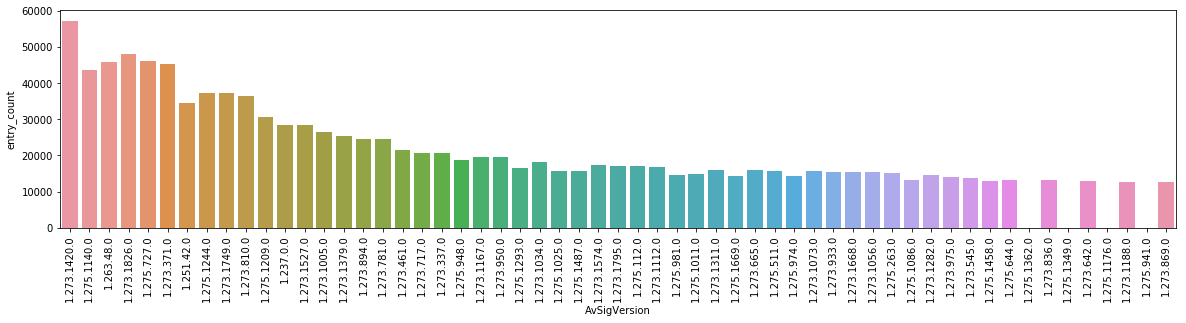

In [50]:
#topHundredByAvSigVersion = cat_data.groupby('AvSigVersion').
dd = grpByAvSig.sort_values(by='entry_count', ascending=False).head(100)
x=sns.barplot(x=dd.AvSigVersion, y=hundredMostInfected.entry_count)
x.figure.set_figwidth(20)

_=plt.setp(x.get_xticklabels(), rotation=90)


In [109]:
dd = grpByAvSig.sort_values(by='entry_count', ascending=False).head(2000)
dd.entry_count.sum()/cat_data.shape[0]

0.9188205593173243

In [127]:
grpByFWVer = cat_data_2.groupby(['Census_FirmwareVersionIdentifier','HasDetections']).size().to_frame('entry_count').reset_index()

In [128]:
grpByFWVer.describe()

entry_count
count  85021.000000
mean     103.049247
std      839.961319
min        1.000000
25%        2.000000
50%        6.000000
75%       28.000000
max    45370.000000

In [130]:
dd = grpByFWVer.sort_values(by='entry_count', ascending=False).head(840*2)
dd.entry_count.sum()/cat_data.shape[0]

0.6417258206959539

In [42]:
#grpByAvSig['HasDetections'==1].head()
mostInfectedAvSigVersion = grpByAvSig[grpByAvSig.HasDetections==1].sort_values(by='size', ascending=False).head(100).AvSigVersion


In [44]:
#grpByAvSig['HasDetections'==1].head()
leastInfectedAvSigVersion = grpByAvSig[grpByAvSig.HasDetections==0].sort_values(by='size').head(100).AvSigVersion


In [48]:
leastInfectedAvSigVersion

(100,)

In [54]:
np.intersect1d(leastInfectedAvSigVersion,mostInfectedAvSigVersion)

array([], dtype=object)

In [53]:
mostInfectedAvSigVersion

14974    1.273.1420.0
15216    1.273.1826.0
16409     1.275.727.0
12192      1.263.48.0
15298     1.273.371.0
15681    1.275.1140.0
15190    1.273.1749.0
15701    1.275.1244.0
15542     1.273.810.0
8641       1.251.42.0
15691    1.275.1209.0
5189        1.237.0.0
15030    1.273.1527.0
14770    1.273.1005.0
14948    1.273.1379.0
15576     1.273.894.0
15532     1.273.781.0
15342     1.273.461.0
15502     1.273.717.0
15288     1.273.337.0
14828    1.273.1167.0
15598     1.273.950.0
16569     1.275.948.0
14774    1.273.1034.0
15054    1.273.1574.0
15204    1.273.1795.0
15673     1.275.112.0
14796    1.273.1112.0
15711    1.275.1293.0
14910    1.273.1311.0
             ...     
14788    1.273.1094.0
15685    1.275.1176.0
14922    1.273.1329.0
15076    1.273.1608.0
15937    1.275.1695.0
15362     1.273.488.0
15821    1.275.1509.0
15010    1.273.1501.0
16599     1.275.988.0
16139     1.275.388.0
15651      1.275.11.0
15456     1.273.612.0
15220    1.273.1863.0
16149     1.275.400.0
16623     

In [28]:
grpByAvSig.sort_values(by='size', ascending=False)

AvSigVersion  HasDetections   size
14974  1.273.1420.0              1  57252
15680  1.275.1140.0              0  53600
12191    1.263.48.0              0  52257
15216  1.273.1826.0              1  48004
16408   1.275.727.0              0  46340
16409   1.275.727.0              1  46108
12192    1.263.48.0              1  45767
15298   1.273.371.0              1  45375
14973  1.273.1420.0              0  45065
15681  1.275.1140.0              1  43632
8640     1.251.42.0              0  42358
15700  1.275.1244.0              0  41737
15297   1.273.371.0              0  41592
15215  1.273.1826.0              0  38009
15190  1.273.1749.0              1  37227
15701  1.275.1244.0              1  37165
15542   1.273.810.0              1  36365
15690  1.275.1209.0              0  35676
5188      1.237.0.0              0  35608
8641     1.251.42.0              1  34479
15691  1.275.1209.0              1  30717
15541   1.273.810.0              0  29530
5189      1.237.0.0              1  28552
15030  1.273.1527.0              1  28450
15189  1.273.1749.0              0  28154
14770  1.273.1005.0              1  26505
14948  1.273.1379.0              1  25428
15576   1.273.894.0              1  24595
15532   1.273.781.0              1  24538
14947  1.273.1379.0              0  23081
...             ...            ...    ...
110    1.213.6196.0              0      1
109    1.213.6073.0              1      1
108    1.213.6023.0              1      1
270    1.223.1506.0              1      1
95     1.213.3699.0              1      1
97      1.213.451.0              0      1
98     1.213.4702.0              0      1
280    1.223.1660.0              0      1
281    1.223.1660.0              1      1
266    1.223.1492.0              1      1
70     1.207.3631.0              0      1
117     1.215.104.0              0      1
71      1.207.405.0              1      1
304    1.223.1743.0              1      1
303    1.223.1743.0              0      1
302     1.223.174.0              1      1
73      1.207.853.0              1      1
74     1.209.1587.0              0      1
92     1.213.3131.0              1      1
93     1.213.3329.0              1      1
94     1.213.3536.0              0      1
118    1.215.1327.0              0      1
111    1.213.6234.0              0      1
112    1.213.6253.0              0      1
113    1.213.6352.0              0      1
114    1.213.7527.0              0      1
115    1.213.7751.0              0      1
268      1.223.15.0              1      1
267    1.223.1499.0              0      1
2343    1.227.763.0              1      1

[16646 rows x 3 columns]

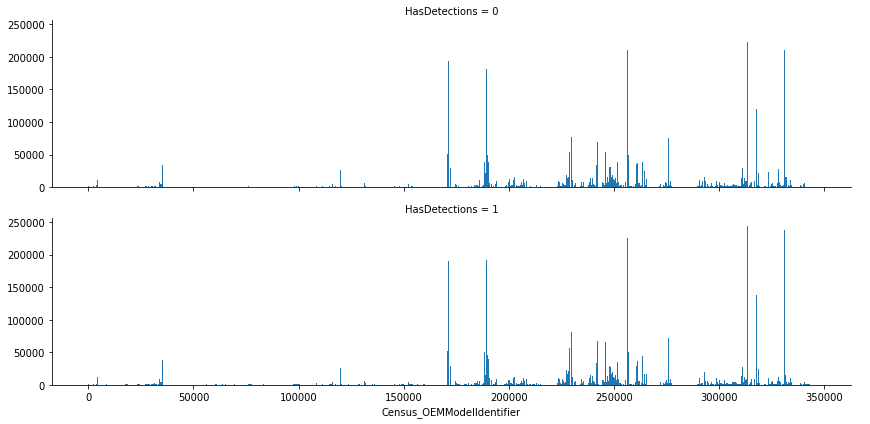

In [13]:
g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1)
ns = g.map(plt.hist, 'Census_OEMModelIdentifier', bins=1000).add_legend()

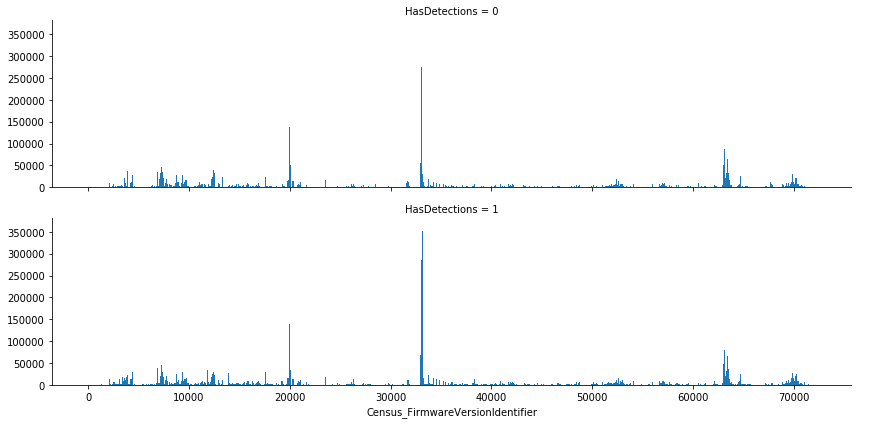

In [15]:
g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1)
ns = g.map(plt.hist, 'Census_FirmwareVersionIdentifier', bins=1000).add_legend()
#g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1, xlim=(30000,40000))
#ns = g.map(plt.hist, 'Census_FirmwareVersionIdentifier', bins=100).add_legend()

In [ ]:
g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1)
ns = g.map(plt.hist, 'AvSigVersion', bins=100).add_legend()

KeyboardInterrupt: 

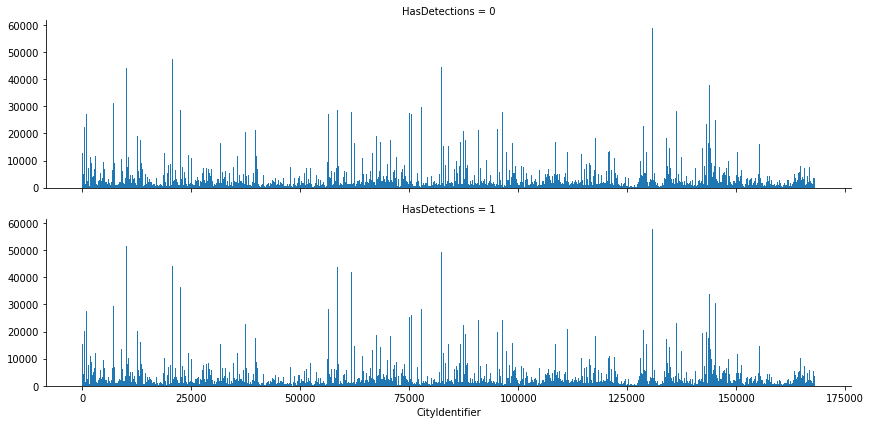

In [196]:
g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1)
ns = g.map(plt.hist, 'CityIdentifier', bins=1000).add_legend()

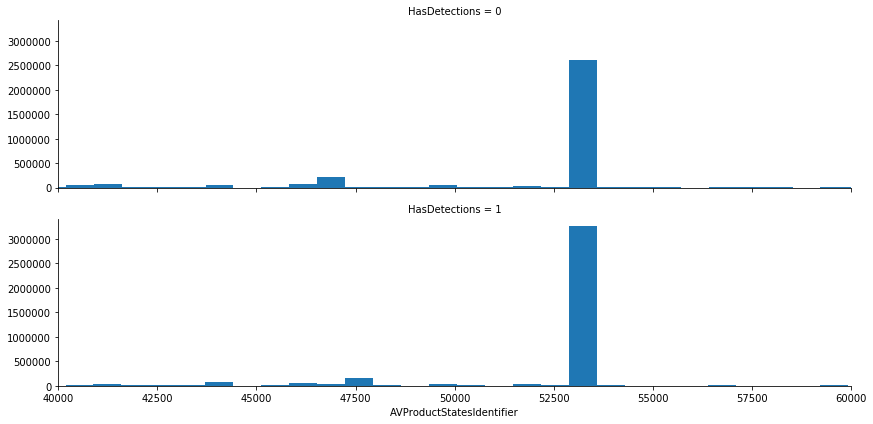

In [71]:
g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1, xlim=(40000,60000))
ns = g.map(plt.hist, 'AVProductStatesIdentifier', bins=100).add_legend()
#g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1)
#ns = g.map(plt.hist, 'AVProductStatesIdentifier', bins=100).add_legend()

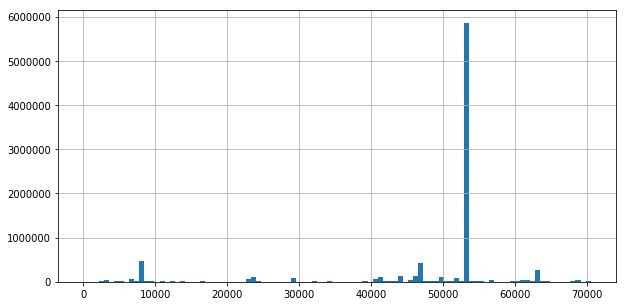

In [72]:
train_raw.AVProductStatesIdentifier.hist(bins=100, figsize=(10,5))

In [ ]:
g = sns.FacetGrid(train_raw, col='HasDetections', height=3, aspect=4, col_wrap=1)
ns = g.map(plt.hist, 'AVProductStatesIdentifier', bins=100).add_legend()

In [66]:
dd = pd.crosstab(train_raw.AVProductStatesIdentifier, train_raw.HasDetections,  margins=True, normalize=True)
dd[dd[0]==0]=dd[0].quantile(q=.25)
dd[dd[1]==0]=dd[1].quantile(q=.75)

dd['one_zero_rat'] = dd[1]/dd[0]
dd['zero_one_rat'] = dd[0]/dd[1]

In [67]:
dd.describe()

HasDetections             0             1           All  one_zero_rat  \
count          2.897100e+04  2.897100e+04  2.897100e+04  28971.000000   
mean           3.449310e-05  3.459052e-05  6.900449e-05      0.951501   
std            3.408176e-03  3.641833e-03  7.039586e-03      0.460637   
min            1.125459e-07  1.125459e-07  1.125459e-07      0.009615   
25%            1.125459e-07  1.125459e-07  1.125459e-07      1.000000   
50%            1.125459e-07  1.125459e-07  1.125459e-07      1.000000   
75%            1.125459e-07  1.125459e-07  2.250918e-07      1.000000   
max            4.997042e-01  5.002958e-01  1.000000e+00     23.000000   

HasDetections  zero_one_rat  
count          28971.000000  
mean               1.477096  
std                2.099813  
min                0.043478  
25%                1.000000  
50%                1.000000  
75%                1.000000  
max              104.000000

In [63]:
dd[0].describe()

count    2.897100e+04
mean     3.449310e-05
std      3.408176e-03
min      1.125459e-07
25%      1.125459e-07
50%      1.125459e-07
75%      1.125459e-07
max      4.997042e-01
Name: 0, dtype: float64

In [47]:
dd[dd[0]==0].head()

HasDetections                0             1           All  one_2_zero  \
AVProductStatesIdentifier                                                
3.0                        0.0  1.125459e-07  1.125459e-07         inf   
7.0                        0.0  1.125459e-07  1.125459e-07         inf   
17.0                       0.0  1.125459e-07  1.125459e-07         inf   
24.0                       0.0  1.125459e-07  1.125459e-07         inf   
38.0                       0.0  1.125459e-07  1.125459e-07         inf   

HasDetections              zero_2_one  
AVProductStatesIdentifier              
3.0                               0.0  
7.0                               0.0  
17.0                              0.0  
24.0                              0.0  
38.0                              0.0

In [37]:
dd[0].describe()

count    2.897100e+04
mean     3.449686e-05
std      3.408176e-03
min      0.000000e+00
25%      1.125459e-07
50%      1.125459e-07
75%      2.250918e-07
max      4.997042e-01
Name: 0, dtype: float64

In [ ]:
train_raw.groupby([['CityIdentifier, HasDetections']])

In [122]:
infectionsByCity = train_raw.groupby(['CityIdentifier', 'HasDetections']).size().to_frame('size').reset_index().sort_values('size', ascending=False)



In [137]:
dd = pd.crosstab(train_raw.CityIdentifier, train_raw.HasDetections,  margins=True, normalize=True)
dd['one_zero_rat'] = dd[1]/dd[0]
dd['zero_one_rat'] = dd[0]/dd[1]
dd.one_zero_rat.replace(np.inf,dd.one_zero_rat.quantile(q=.75), inplace=True)
dd.zero_one_rat.replace(np.inf,dd.zero_one_rat.quantile(q=.75), inplace=True)                        

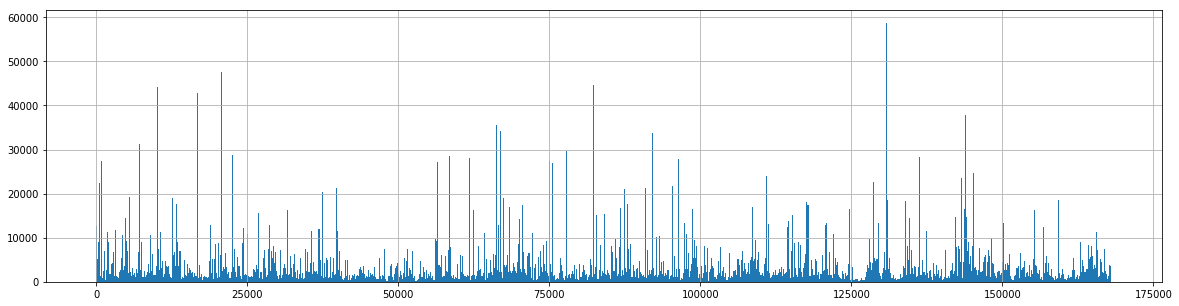

In [194]:
#ns=train_raw[train_raw.HasDetections==0].CityIdentifier.hist(bins=1000, figsize=(20,5)).set_xlim(50000,75000)
ns=train_raw[train_raw.HasDetections==0].CityIdentifier.hist(bins=1000, figsize=(20,5))

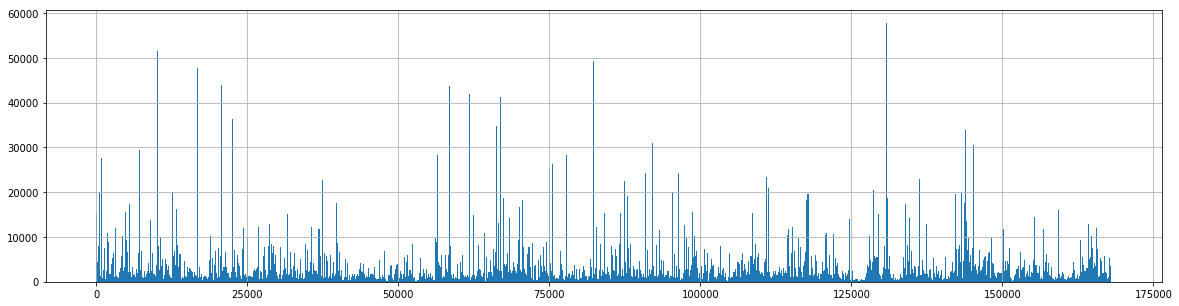

In [187]:
#ns=train_raw[train_raw.HasDetections==1].CityIdentifier.hist(bins=1000, figsize=(20,5)).set_xlim(50000,75000)
ns=train_raw[train_raw.HasDetections==1].CityIdentifier.hist(bins=1000, figsize=(20,5))

In [84]:
col_value_counts

{'AVProductStatesIdentifier': 28970,
 'AVProductsEnabled': 6,
 'AVProductsInstalled': 8,
 'AppVersion': 110,
 'AutoSampleOptIn': 2,
 'AvSigVersion': 8531,
 'Census_ActivationChannel': 6,
 'Census_ChassisTypeName': 52,
 'Census_DeviceFamily': 3,
 'Census_FirmwareManufacturerIdentifier': 712,
 'Census_FirmwareVersionIdentifier': 50494,
 'Census_FlightRing': 10,
 'Census_GenuineStateName': 5,
 'Census_HasOpticalDiskDrive': 2,
 'Census_IsAlwaysOnAlwaysConnectedCapable': 2,
 'Census_IsFlightsDisabled': 2,
 'Census_IsPenCapable': 2,
 'Census_IsPortableOperatingSystem': 2,
 'Census_IsSecureBootEnabled': 2,
 'Census_IsTouchEnabled': 2,
 'Census_IsVirtualDevice': 2,
 'Census_MDC2FormFactor': 13,
 'Census_OEMModelIdentifier': 175365,
 'Census_OEMNameIdentifier': 3832,
 'Census_OSArchitecture': 3,
 'Census_OSBranch': 32,
 'Census_OSEdition': 33,
 'Census_OSInstallLanguageIdentifier': 39,
 'Census_OSInstallTypeName': 9,
 'Census_OSSkuName': 30,
 'Census_OSUILocaleIdentifier': 147,
 'Census_OSVersi

### Remove NaN ###

In [28]:
def impute(data, value='other',inplace=True):
    dt_df = data.dtypes
    col_idx = [k for k,t in enumerate(dt_df) if t=='object']
    cols = data.columns[col_idx]
    for c in cols:
        data[c].fillna(value, inplace=inplace)
    
    col_idx = [k for k,t in enumerate(dt_df) if t!='object']
    cols = data.columns[col_idx]
    for c in cols:
        data[c].fillna(data[c].value_counts().index[0], inplace=inplace)
        
    return data    

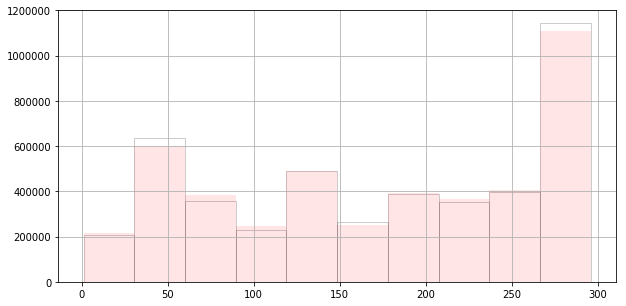

In [59]:
ns=train_raw[train_raw.HasDetections==1].GeoNameIdentifier.hist(figsize=(10,5), color='green', alpha=.2, fill=False)
ns=train_raw[train_raw.HasDetections==0].GeoNameIdentifier.hist(figsize=(10,5), color='red', alpha=0.1)

In [ ]:
plt.bar(train_raw.HasDetections, train_raw.GeoNameIdentifier)

KeyboardInterrupt: 

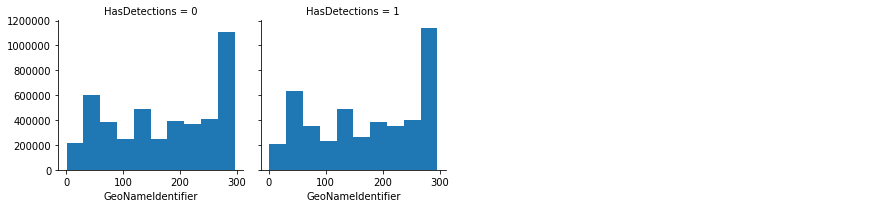

In [60]:
g = sns.FacetGrid(train_raw, col='HasDetections', col_wrap=4)
ns = g.map(plt.hist, 'GeoNameIdentifier').add_legend()

In [43]:
dd = pd.crosstab(train_raw.GeoNameIdentifier, train_raw.HasDetections,  margins=True, normalize=True)
dd['rat_1_0'] = dd[1]/dd[0]

KeyError: '1'

In [49]:
dd.sort_values(by='rat_1_0', ascending=False)

HasDetections                 0             1           All   rat_1_0
GeoNameIdentifier                                                    
132.0              0.000000e+00  1.120917e-07  1.120917e-07       inf
92.0               0.000000e+00  1.120917e-07  1.120917e-07       inf
280.0              1.120917e-07  5.604583e-07  6.725500e-07  5.000000
259.0              2.241833e-07  1.008825e-06  1.233008e-06  4.500000
169.0              1.120917e-07  4.483667e-07  5.604583e-07  4.000000
290.0              1.120917e-07  3.362750e-07  4.483667e-07  3.000000
292.0              4.483667e-07  1.008825e-06  1.457192e-06  2.250000
158.0              8.048181e-05  1.703793e-04  2.508611e-04  2.116992
136.0              1.120917e-07  2.241833e-07  3.362750e-07  2.000000
43.0               1.366397e-04  2.605010e-04  3.971408e-04  1.906481
253.0              1.877535e-04  3.442335e-04  5.319870e-04  1.833433
11.0               1.866326e-04  3.168831e-04  5.035158e-04  1.697898
121.0              6.239022e-04  1.018913e-03  1.642815e-03  1.633130
177.0              1.206106e-04  1.880898e-04  3.087004e-04  1.559480
30.0               6.824141e-04  1.043237e-03  1.725651e-03  1.528745
260.0              2.241833e-07  3.362750e-07  5.604583e-07  1.500000
196.0              7.980926e-05  1.183688e-04  1.981781e-04  1.483146
120.0              5.892323e-03  8.557078e-03  1.444940e-02  1.452242
58.0               9.415700e-06  1.356309e-05  2.297879e-05  1.440476
122.0              9.311455e-04  1.337702e-03  2.268847e-03  1.436620
28.0               1.535656e-05  2.196997e-05  3.732652e-05  1.430657
172.0              7.274749e-05  1.030122e-04  1.757597e-04  1.416025
39.0               1.783154e-03  2.507491e-03  4.290645e-03  1.406211
194.0              1.122598e-03  1.577466e-03  2.700064e-03  1.405192
217.0              5.604583e-07  7.846416e-07  1.345100e-06  1.400000
77.0               1.813867e-03  2.524641e-03  4.338508e-03  1.391855
293.0              6.445271e-05  8.956124e-05  1.540139e-04  1.389565
54.0               1.457192e-06  2.017650e-06  3.474842e-06  1.384615
185.0              4.660771e-04  6.360081e-04  1.102085e-03  1.364598
287.0              3.049342e-03  4.096614e-03  7.145956e-03  1.343442
...                         ...           ...           ...       ...
163.0              1.904437e-04  1.189293e-04  3.093730e-04  0.624485
222.0              1.927977e-05  1.199381e-05  3.127357e-05  0.622093
88.0               1.791785e-03  1.075183e-03  2.866968e-03  0.600063
118.0              4.281902e-04  2.515337e-04  6.797239e-04  0.587435
108.0              9.079425e-06  5.268308e-06  1.434773e-05  0.580247
171.0              1.401146e-05  7.958508e-06  2.196997e-05  0.568000
183.0              1.155665e-04  6.086577e-05  1.764323e-04  0.526673
48.0               4.102555e-05  2.051277e-05  6.153832e-05  0.500000
91.0               1.136609e-04  5.526119e-05  1.689221e-04  0.486193
90.0               9.449327e-05  4.483667e-05  1.393299e-04  0.474496
231.0              1.457192e-06  6.725500e-07  2.129742e-06  0.461538
105.0              4.819942e-05  2.140951e-05  6.960892e-05  0.444186
151.0              3.239449e-04  1.425806e-04  4.665255e-04  0.440138
85.0               5.503701e-05  2.253042e-05  7.756743e-05  0.409369
149.0              2.286670e-05  9.303608e-06  3.217031e-05  0.406863
182.0              6.949683e-06  2.802292e-06  9.751975e-06  0.403226
37.0               1.457192e-06  5.604583e-07  2.017650e-06  0.384615
102.0              3.508469e-05  1.277845e-05  4.786314e-05  0.364217
27.0               3.732652e-05  1.132126e-05  4.864778e-05  0.303303
242.0              5.604583e-07  1.120917e-07  6.725500e-07  0.200000
14.0               1.120917e-07  0.000000e+00  1.120917e-07  0.000000
219.0              3.362750e-07  0.000000e+00  3.362750e-07  0.000000
197.0              1.120917e-07  0.000000e+00  1.120917e-07  0.000000
51.0               1.120917e-07  0.000000e+00  1.120917e-07  0.000000
106.0     

In [29]:
%%time
cat_data = impute(cat_data)

CPU times: user 29.9 s, sys: 4.11 s, total: 34 s
Wall time: 34 s


In [30]:
cat_data.count()/cat_data.shape[0]

GeoNameIdentifier                          1.0
Census_ProcessorManufacturerIdentifier     1.0
Census_HasOpticalDiskDrive                 1.0
ProductName                                1.0
EngineVersion                              1.0
Census_FirmwareVersionIdentifier           1.0
Census_IsPortableOperatingSystem           1.0
OsVer                                      1.0
OrganizationIdentifier                     1.0
SkuEdition                                 1.0
CityIdentifier                             1.0
Census_OSVersion                           1.0
Census_ActivationChannel                   1.0
Census_OSSkuName                           1.0
Census_OSInstallLanguageIdentifier         1.0
Platform                                   1.0
AppVersion                                 1.0
Census_ChassisTypeName                     1.0
IeVerIdentifier                            1.0
LocaleEnglishNameIdentifier                1.0
Census_ProcessorModelIdentifier            1.0
OsBuildLab   

In [47]:
cat_data_dup = mode_impute(cat_data_dup, inplace=True)
#cat_data = cat_data.fillna()

In [168]:
#cat_data.SmartScreen.count().sum()/cat_data.shape[0]
cat_data_dup[cat_data_dup.HasDetections==1].Census_ChassisTypeName.value_counts()

notebook               2629525
desktop                 982113
laptop                  337884
portable                173541
allinone                105402
minitower                45022
convertible              40399
unknown                  34166
lowprofiledesktop        25386
other                    20043
detachable               17011
spacesaving              14330
handheld                 13456
tower                     6331
tablet                    5131
mainserverchassis         3772
lunchbox                  1744
minipc                    1633
rackmountchassis          1179
subnotebook                270
busexpansionchassis        249
30                          78
0                           53
stickpc                     44
pizzabox                    26
sealedcasepc                19
multisystemchassis          17
35                          16
blade                       13
subchassis                   9
31                           6
32                           5
expansio

In [90]:
dd = pd.DataFrame(cat_data.Census_ChassisTypeName.value_counts()/cat_data.shape[0]*100).reset_index()

In [94]:
dd.shape

(52, 2)

In [109]:
cat_data_dup['HasDetections'] = train_raw.HasDetections

In [172]:
#dd=pd.crosstab(cat_data_dup.Census_ChassisTypeName, cat_data_dup.HasDetections, margins=True, normalize=True)
dd=pd.crosstab(cat_data_dup.Census_ChassisTypeName, cat_data_dup.HasDetections, margins=False, normalize=True)

#pd.crosstab(train_raw.HasDetections,train_raw.OrganizationIdentifier, margins=True, normalize=False)

In [179]:
dd['rat_1_0'] = dd[1]/dd[0]

In [182]:
dd.sort_values(by='rat_1_0', ascending=False)

HasDetections                      0             1  0_1_ration   rat_1_0
Census_ChassisTypeName                                                  
39                      0.000000e+00  1.120890e-07    0.000000       inf
82                      0.000000e+00  1.120890e-07    0.000000       inf
81                      0.000000e+00  2.241780e-07    0.000000       inf
36                      1.120890e-07  2.241780e-07    0.500000  2.000000
32                      3.362670e-07  5.604449e-07    0.600000  1.666667
pizzabox                2.241780e-06  2.914314e-06    0.769231  1.300000
subchassis              7.846229e-07  1.008801e-06    0.777778  1.285714
31                      5.604449e-07  6.725339e-07    0.833333  1.200000
minitower               4.495329e-03  5.046470e-03    0.890787  1.122603
desktop                 9.976054e-02  1.100841e-01    0.906222  1.103483
allinone                1.108482e-02  1.181440e-02    0.938246  1.065819
lowprofiledesktop       2.767029e-03  2.845491e-03    0.972426  1.028356
tower                   6.969693e-04  7.096354e-04    0.982151  1.018173
notebook                2.936631e-01  2.947408e-01    0.996343  1.003670
bladeenclosure          1.120890e-07  1.120890e-07    1.000000  1.000000
25                      3.362670e-07  3.362670e-07    1.000000  1.000000
spacesaving             1.652192e-03  1.606235e-03    1.028611  0.972185
laptop                  3.897300e-02  3.787308e-02    1.029043  0.971777
sealedcasepc            2.241780e-06  2.129691e-06    1.052632  0.950000
portable                2.100122e-02  1.945204e-02    1.079641  0.926234
convertible             4.940098e-03  4.528283e-03    1.090943  0.916638
unknown                 4.826216e-03  3.829632e-03    1.260229  0.793506
lunchbox                2.496222e-04  1.954832e-04    1.276950  0.783116
expansionchassis        7.846229e-07  5.604449e-07    1.400000  0.714286
0                       8.967119e-06  5.940716e-06    1.509434  0.662500
mainserverchassis       6.470897e-04  4.227997e-04    1.530488  0.653386
tablet                  9.526443e-04  5.751286e-04    1.656402  0.603718
minipc                  3.138492e-04  1.830413e-04    1.714636  0.583214
busexpansionchassis     5.279391e-05  2.791016e-05    1.891566  0.528662
rackmountchassis        2.500705e-04  1.321529e-04    1.892282  0.528463
subnotebook             6.019179e-05  3.026403e-05    1.988889  0.502793
detachable              3.862026e-03  1.906746e-03    2.025454  0.493716
30                      1.849468e-05  8.742941e-06    2.115385  0.472727
35                      3.811026e-06  1.793424e-06    2.125000  0.470588
stickpc                 1.098472e-05  4.931915e-06    2.227273  0.448980
handheld                3.648833e-03  1.508269e-03    2.419218  0.413357
multisystemchassis      4.931915e-06  1.905513e-06    2.588235  0.386364
other                   6.247728e-03  2.246600e-03    2.780971  0.359587
blade                   4.371471e-06  1.457157e-06    3.000000  0.333333
88                      6.725339e-07  2.241780e-07    3.000000  0.333333
44                      3.362670e-07  1.120890e-07    3.000000  0.333333
127                     6.725339e-07  1.120890e-07    6.000000  0.166667
28                      1.120890e-07  0.000000e+00         inf  0.000000
112                     1.120890e-07  0.000000e+00         inf  0.000000
45                      1.120890e-07  0.000000e+00         inf  0.000000
dockingstation          2.241780e-07  0.000000e+00         inf  0.000000
76                      1.120890e-07  0.000000e+00         inf  0.000000
iotgateway              1.120890e-07  0.000000e+00         inf  0.000000
compactpci              2.241780e-07  0.000000e+00         inf  0.000000
embeddedpc              1.120890e-07  0.000000e+00         inf  0.000000
49                      1.120890e-07  0.000000e+00         inf  0.000000

In [177]:
dd.sort_values(by=0_1_ration, ascending=False)

SyntaxError: invalid syntax (<ipython-input-177-5f218ba6f3e6>, line 1)

In [137]:
dd1 = dd.reset_index()

In [148]:
dd1[['HasDetections','notebook','desktop','portable','allinone']]

Census_ChassisTypeName HasDetections  notebook   desktop  portable  allinone
0                                  0  0.293663  0.099761  0.021001  0.011085
1                                  1  0.294741  0.110084  0.019452  0.011814
2                                All  0.588404  0.209845  0.040453  0.022899

In [171]:
dd

Census_ChassisTypeName         0           112           127            25  \
HasDetections                                                                
0                       0.000009  1.120890e-07  6.725339e-07  3.362670e-07   
1                       0.000006  0.000000e+00  1.120890e-07  3.362670e-07   

Census_ChassisTypeName            28        30            31            32  \
HasDetections                                                                
0                       1.120890e-07  0.000018  5.604449e-07  3.362670e-07   
1                       0.000000e+00  0.000009  6.725339e-07  5.604449e-07   

Census_ChassisTypeName        35            36            39            44  \
HasDetections                                                                
0                       0.000004  1.120890e-07  0.000000e+00  3.362670e-07   
1                       0.000002  2.241780e-07  1.120890e-07  1.120890e-07   

Census_ChassisTypeName            45            49            76  \
HasDetections                                                      
0                       1.120890e-07  1.120890e-07  1.120890e-07   
1                       0.000000e+00  0.000000e+00  0.000000e+00   

Census_ChassisTypeName            81            82            88  allinone  \
HasDetections                                                                
0                       0.000000e+00  0.000000e+00  6.725339e-07  0.011085   
1                       2.241780e-07  1.120890e-07  2.241780e-07  0.011814   

Census_ChassisTypeName     blade  bladeenclosure  busexpansionchassis  \
HasDetections                                                           
0                       0.000004    1.120890e-07             0.000053   
1                       0.000001    1.120890e-07             0.000028   

Census_ChassisTypeName    compactpci  convertible   desktop  detachable  \
HasDetections                                                             
0                       2.241780e-07     0.004940  0.099761    0.003862   
1                       0.000000e+00     0.004528  0.110084    0.001907   

Census_ChassisTypeName  dockingstation    embeddedpc  expansionchassis  \
HasDetections                                                            
0                         2.241780e-07  1.120890e-07      7.846229e-07   
1                         0.000000e+00  0.000000e+00      5.604449e-07   

Census_ChassisTypeName  handheld    iotgateway    laptop  lowprofiledesktop  \
HasDetections                                                                 
0                       0.003649  1.120890e-07  0.038973           0.002767   
1                       0.001508  0.000000e+00  0.037873           0.002845   

Census_ChassisTypeName  lunchbox  mainserverchassis    minipc  minitower  \
HasDetections                                                              
0                       0.000250           0.000647  0.000314   0.004495   
1                       0.000195           0.000423  0.000183   0.005046   

Census_ChassisTypeName  multisystemchassis  notebook     other  pizzabox  \
HasDetections                                                              
0                                 0.000005  0.293663  0.006248  0.000002   
1                                 0.000002  0.294741  0.002247  0.000003   

Census_ChassisTypeName  portable  rackmountchassis  sealedcasepc  spacesaving  \
HasDetections                                                                   
0                       0.021001          0.000250      0.000002     0.001652   
1                       0.019452          0.000132      0.000002     0.001606   

Census_ChassisTypeName   stickpc    subchassis  subnotebook    tablet  \
HasDetections                                                           
0                       0.000011  7.846229e-07      0.00006  0.000953   
1                       0.000005  1.008801e-06      0.00003  0.000575   

Census_ChassisTypeName     tower   unkn

In [20]:
def hot_encode_column(data, col_name, drop_col_post_encode=True, cols=[]):
    encoder = LabelBinarizer()
    result = pd.DataFrame(encoder.fit_transform(data[col_name]), index=data.index)
    
    if not cols:       
        for i, name in enumerate(encoder.classes_):
            cols[i] = name
    
    result = result.rename(columns=cols)
        
    data = pd.concat([data, result], axis=1)
    if drop_col_post_encode:        
        data.drop(col_name, axis=1, inplace=True)
        
    return data, encoder.classes_    

### Drop the columns because number of NAN > 50% ###

In [35]:
(cat_data.count()/cat_data.shape[0]).sort_values(ascending=False)

AppVersion                                 1.000000
Platform                                   1.000000
Census_OSVersion                           1.000000
Census_DeviceFamily                        1.000000
Census_IsPortableOperatingSystem           1.000000
AutoSampleOptIn                            1.000000
Census_HasOpticalDiskDrive                 1.000000
Census_OSSkuName                           1.000000
IsSxsPassiveMode                           1.000000
Census_IsTouchEnabled                      1.000000
IsBeta                                     1.000000
Census_FlightRing                          1.000000
EngineVersion                              1.000000
Processor                                  1.000000
AvSigVersion                               1.000000
MachineIdentifier                          1.000000
HasTpm                                     1.000000
Census_IsSecureBootEnabled                 1.000000
ProductName                                1.000000
OsPlatformSu

In [26]:
def hot_encode(data, columns=[], col_map = {}):
    columns = columns if columns else list(data.columns)
    for col in columns:
        data, _ = hot_encode_column(data, col)
    return data    

In [27]:
cat_data_dup = cat_data.copy()
dd = hot_encode(cat_data_dup)

ValueError: Unknown label type: (0          NaN
1          NaN
2          NaN
3          NaN
4          0.0
5          0.0
6          NaN
7          0.0
8          0.0
9          0.0
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         0.0
16         0.0
17         NaN
18         NaN
19         NaN
20         NaN
21         0.0
22         NaN
23         NaN
24         0.0
25         0.0
26         NaN
27         NaN
28         NaN
29         NaN
          ... 
8921453    NaN
8921454    NaN
8921455    0.0
8921456    NaN
8921457    NaN
8921458    0.0
8921459    0.0
8921460    NaN
8921461    NaN
8921462    0.0
8921463    0.0
8921464    0.0
8921465    NaN
8921466    0.0
8921467    0.0
8921468    NaN
8921469    0.0
8921470    NaN
8921471    0.0
8921472    NaN
8921473    NaN
8921474    NaN
8921475    NaN
8921476    NaN
8921477    NaN
8921478    NaN
8921479    0.0
8921480    NaN
8921481    NaN
8921482    NaN
Name: Census_IsWIMBootEnabled, Length: 8921483, dtype: float64,)

In [16]:
encoder = LabelBinarizer()
activation_channel_cat_1hot = pd.DataFrame(encoder.fit_transform(cat_data.Census_ActivationChannel), index=cat_data.index)
#pos_cash_bal.drop(['SK_DPD_DEF','DPD_CAT'], axis=1, inplace=True)
#pos_cash_bal = pd.concat([pos_cash_bal,dpd_cat_1hot], axis=1)

In [19]:
activation_channel_cat_1hot.head()

0  1  2  3  4  5
0  0  0  1  0  0  0
1  0  0  1  0  0  0
2  0  1  0  0  0  0
3  0  1  0  0  0  0
4  0  0  1  0  0  0

In [10]:
non_cat_cols

Index(['RtpStateBitfield', 'OsBuild', 'OsSuite', 'Census_ProcessorCoreCount',
       'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity',
       'Census_TotalPhysicalRAM',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber',
       'Census_OSBuildRevision', 'DisplayHorzVertRatio'],
      dtype='object')

In [11]:
cat_cols

['Census_IsWIMBootEnabled',
 'PuaMode',
 'AppVersion',
 'Census_ProcessorManufacturerIdentifier',
 'GeoNameIdentifier',
 'Wdft_RegionIdentifier',
 'SMode',
 'Census_OSEdition',
 'Census_ChassisTypeName',
 'Census_IsFlightsDisabled',
 'Census_InternalBatteryType',
 'SmartScreen',
 'ProductName',
 'Census_IsPortableOperatingSystem',
 'AutoSampleOptIn',
 'Census_OSSkuName',
 'Census_IsTouchEnabled',
 'IsProtected',
 'Census_FirmwareVersionIdentifier',
 'Firewall',
 'IeVerIdentifier',
 'IsBeta',
 'AVProductsEnabled',
 'Census_FirmwareManufacturerIdentifier',
 'EngineVersion',
 'Census_IsSecureBootEnabled',
 'Census_IsFlightingInternal',
 'OsPlatformSubRelease',
 'Census_PowerPlatformRoleName',
 'HasTpm',
 'MachineIdentifier',
 'AvSigVersion',
 'Processor',
 'Census_OEMModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_IsVirtualDevice',
 'Wdft_IsGamer',
 'IsSxsPassiveMode',
 'OsBuildLab',
 'Census_ProcessorModelIdentifier',
 'Census_HasOpticalDiskDrive',
 'Census_IsAlwaysOnAl

In [22]:
corr_col = list(non_cat_cols) + ['HasDetections']

In [24]:
corr_matrix = train_raw[corr_col].corr()

In [26]:
corr_matrix.HasDetections.sort_values(ascending=False)

HasDetections                                        1.000000
Census_TotalPhysicalRAM                              0.057069
Census_ProcessorCoreCount                            0.054299
RtpStateBitfield                                     0.041486
DisplayHorzVertRatio                                 0.040887
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.034243
Census_OSBuildNumber                                 0.029486
OsBuild                                              0.024754
Census_InternalBatteryNumberOfCharges                0.020147
Census_SystemVolumeTotalCapacity                     0.014481
Census_PrimaryDiskTotalCapacity                      0.000170
Census_OSBuildRevision                              -0.009342
OsSuite                                             -0.020301
Name: HasDetections, dtype: float64

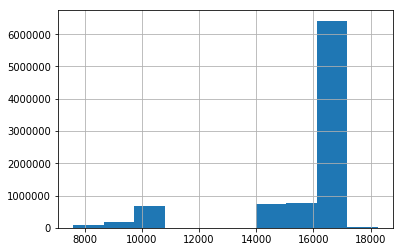

In [52]:
train_raw.OsBuild.hist()

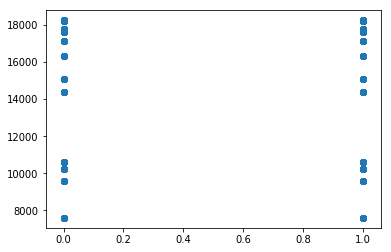

In [56]:
plt.scatter(train_raw.HasDetections, train_raw.OsBuild)

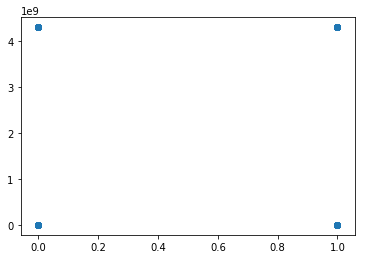

In [35]:
plt.scatter(train_raw.HasDetections, train_raw.Census_InternalBatteryNumberOfCharges)

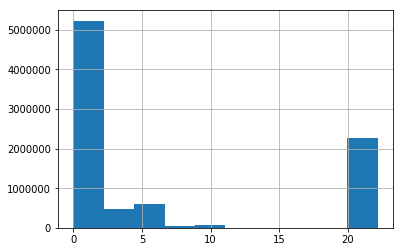

In [49]:
np.log(train_raw.Census_InternalBatteryNumberOfCharges+1).hist(bins=10)

In [163]:
non_cat_data.AutoSampleOptIn.value_counts()

0    8921225
1        258
Name: AutoSampleOptIn, dtype: int64

In [10]:
cat_cols

['Census_PowerPlatformRoleName',
 'Census_ChassisTypeName',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSArchitecture',
 'Census_OSEdition',
 'Census_OSBranch',
 'Census_OSInstallTypeName',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'SkuEdition',
 'Wdft_RegionIdentifier',
 'Census_OSSkuName',
 'Processor',
 'ProductName',
 'Census_IsTouchEnabled',
 'Census_IsFlightsDisabled',
 'Firewall',
 'MachineIdentifier',
 'OsPlatformSubRelease',
 'Census_InternalBatteryType',
 'SmartScreen',
 'AVProductsInstalled',
 'HasTpm',
 'Census_PrimaryDiskTypeName',
 'Census_ProcessorClass',
 'CountryIdentifier',
 'AutoSampleOptIn',
 'IsBeta',
 'Census_HasOpticalDiskDrive',
 'OsBuildLab',
 'Census_ActivationChannel',
 'Census_DeviceFamily',
 'Census_OSUILocaleIdentifier',
 'AVProductsEnabled',
 'Census_OSWUAutoUpdateOptionsName',
 'AvSigVersion',
 'Census_FlightRing',
 'UacLuaenable',
 'GeoNameIdentifier',
 'IeVerIdentifier',
 'AVProductStatesIdentifier',
 'Census_ProcessorManufacturerIdentif

In [24]:
(train_raw.count()).sort_values(ascending=False)

MachineIdentifier                                    8921483
Census_OSSkuName                                     8921483
Census_OSBuildRevision                               8921483
Census_OSBuildNumber                                 8921483
AutoSampleOptIn                                      8921483
Census_OSArchitecture                                8921483
Census_OSVersion                                     8921483
HasTpm                                               8921483
CountryIdentifier                                    8921483
LocaleEnglishNameIdentifier                          8921483
Platform                                             8921483
Processor                                            8921483
Census_HasOpticalDiskDrive                           8921483
OsVer                                                8921483
OsBuild                                              8921483
HasDetections                                        8921483
OsSuite                 

In [26]:
corr_raw = train_raw.corr()

In [7]:
train_raw['Display_horizontal_vertical_ratio'] = train_raw.Census_InternalPrimaryDisplayResolutionHorizontal*train_raw.Census_InternalPrimaryDisplayResolutionVertical

In [35]:
train_raw.display_horizontal_vertical_ratio.value_counts().sort_values(ascending=False)

AttributeError: 'DataFrame' object has no attribute 'display_horizontal_vertical_ratio'

In [48]:
len(train_raw.Census_InternalPrimaryDisplayResolutionHorizontal.unique())

2181

In [49]:
len(train_raw.Census_InternalPrimaryDisplayResolutionVertical.unique())

1561

In [14]:
len(train_raw.Display_horizontal_vertical_ratio.unique())

9623

In [68]:
train_raw[['Census_InternalPrimaryDisplayResolutionHorizontal','Census_InternalPrimaryDisplayResolutionVertical','Display_horizontal_vertical_ratio']].head()

Census_InternalPrimaryDisplayResolutionHorizontal  \
0                                             1440.0   
1                                             1366.0   
2                                             1920.0   
3                                             1366.0   
4                                             1366.0   

   Census_InternalPrimaryDisplayResolutionVertical  \
0                                            900.0   
1                                            768.0   
2                                           1080.0   
3                                            768.0   
4                                            768.0   

   Display_horizontal_vertical_ratio  
0                          1296000.0  
1                          1049088.0  
2                          2073600.0  
3                          1049088.0  
4                          1049088.0

In [13]:
train_raw.groupby(['Census_InternalPrimaryDisplayResolutionHorizontal',
                   'Census_InternalPrimaryDisplayResolutionVertical'])
.size().to_frame('size').reset_index().sort_values('size', ascending=False)

Census_InternalPrimaryDisplayResolutionHorizontal  \
3508                                             1366.0   
7524                                             1920.0   
5041                                             1600.0   
895                                              1024.0   
2563                                             1280.0   
2642                                             1280.0   
4130                                             1440.0   
3308                                             1360.0   
5822                                             1680.0   
7584                                             1920.0   
8942                                             2736.0   
2529                                             1280.0   
795                                              1024.0   
9788                                             3840.0   
8739                                             2560.0   
7941                                             2160.0   
2547                                             1280.0   
250                                               800.0   
9367                                             3200.0   
8761                                             2560.0   
7586                                             1920.0   
269                                               800.0   
8642                                             2560.0   
9262                                             3000.0   
5071                                             1600.0   
69                                                640.0   
3542                                             1368.0   
9194                                             2880.0   
1549                                             1152.0   
2622                                             1280.0   
...                                                 ...   
4532                                             1520.0   
4545                                             1522.0   
4544                                             1522.0   
1460                                             1141.0   
4542                                             1522.0   
4541                                             1522.0   
4540                                             1522.0   
4539                                             1522.0   
4538                                             1522.0   
4537                                             1521.0   
4536                                             1521.0   
4535                                             1520.0   
4534                                             1520.0   
4533                                             1520.0   
4531                                             1520.0   
4517                                             1518.0   
4530                                             1520.0   
4529                                             1520.0   
4528                                             1520.0   
4527                                             1520.0   
4526                                             1520.0   
4525                                             1520.0   
4524                                             1520.0   
4523                                             1520.0   
1461                                             1142.0   
4521                                             1518.0   
4520                                             1518.0   
4519                                             1518.0   
4518                                             1518.0   
5033                                             1600.0   

      Census_InternalPrimaryDisplayResolutionVertical     size  
3508                                            768.0  4514227  
7524                                           1080.0  2134006  
5041                                            900.0   490012  
895                                             768.0   296935  
2563                  

In [43]:
train_raw.Census_InternalPrimaryDisplayResolutionVertical.value_counts().sort_values(ascending=False)

768.0     4973621
1080.0    2148402
900.0      655155
800.0      262058
1024.0     186322
1050.0     112220
1440.0      81251
1200.0      79397
600.0       63806
1824.0      57630
720.0       48483
2160.0      46777
1280.0      28870
1800.0      25532
1600.0      16009
2000.0      11066
480.0        8972
1920.0       8143
864.0        7550
960.0        6479
1504.0       5466
1152.0       2529
1536.0       2348
1366.0       2225
992.0        2018
1000.0       1641
2880.0       1588
945.0        1560
2736.0       1089
2100.0       1051
           ...   
2112.0          1
2244.0          1
2246.0          1
2248.0          1
2272.0          1
2280.0          1
1962.0          1
1958.0          1
2021.0          1
1956.0          1
2024.0          1
2032.0          1
2041.0          1
2045.0          1
2053.0          1
2058.0          1
2063.0          1
2071.0          1
2074.0          1
2077.0          1
2082.0          1
2083.0          1
2086.0          1
2017.0          1
2014.0    

In [246]:
train_raw[['Census_InternalPrimaryDisplayResolutionHorizontal','Census_InternalPrimaryDisplayResolutionVertical','display_horizontal_vertical_ratio']].head()

Census_InternalPrimaryDisplayResolutionHorizontal  \
0                                             1440.0   
1                                             1366.0   
2                                             1920.0   
3                                             1366.0   
4                                             1366.0   

   Census_InternalPrimaryDisplayResolutionVertical  \
0                                            900.0   
1                                            768.0   
2                                           1080.0   
3                                            768.0   
4                                            768.0   

   display_horizontal_vertical_ratio  
0                           1.600000  
1                           1.778646  
2                           1.777778  
3                           1.778646  
4                           1.778646

In [37]:
pd.crosstab(train_raw.Census_InternalPrimaryDisplayResolutionHorizontal,train_raw.Census_InternalPrimaryDisplayResolutionVertical, margins=True, normalize=False)

Census_InternalPrimaryDisplayResolutionVertical    -1.0  171.0  200.0  208.0  \
Census_InternalPrimaryDisplayResolutionHorizontal                              
-1.0                                                156      0      0      0   
144.0                                                 0      0      0      0   
200.0                                                 0      0      5      0   
274.0                                                 0      1      0      0   
320.0                                                 0      0     19      0   
325.0                                                 0      0      0      0   
331.0                                                 0      0      0      0   
333.0                                                 0      0      0      0   
360.0                                                 0      0      0      0   
400.0                                                 0      0      0      0   
432.0                                                 0      0      0      0   
480.0                                                 0      0      0      0   
510.0                                                 0      0      0      0   
512.0                                                 0      0      0      0   
537.0                                                 0      0      0      0   
540.0                                                 0      0      0      0   
568.0                                                 0      0      0      0   
594.0                                                 0      0      0      0   
600.0                                                 0      0      0      0   
604.0                                                 0      0      0      0   
606.0                                                 0      0      0      0   
608.0                                                 0      0      0      0   
611.0                                                 0      0      0      0   
612.0                                                 0      0      0      0   
620.0                                                 0      0      0      0   
624.0                                                 0      0      0      0   
625.0                                                 0      0      0      0   
626.0                                                 0      0      0      0   
634.0                                                 0      0      0      0   
638.0                                                 0      0      0      0   
...                                                 ...    ...    ...    ...   
5964.0                                                0      0      0      0   
5968.0                                                0      0      0      0   
5970.0                                                0      0      0      0   
5980.0                                                0      0      0      0   
5984.0                                                0      0      0      0   
6000.0                                                0      0      0      0   
6010.0                                                0      0      0      0   
6015.0                                                0      0      0      0   
6016.0                                                0      0      0      0   
6030.0                                                0      0      0      0   
6034.0                                                0      0      0      0   
6048.0                                                0      0      0      0   
6062.0                                                0      0      0      0   
6081.0                                                0      0      0      0   
6144.0                                                0      0      0      0   
6160.0                                                0      0      0      0   
6236.0                                                0      0      0      0   


In [ ]:
train_raw.groupby(['Census_InternalPrimaryDisplayResolutionHorizontal','Census_InternalPrimaryDisplayResolutionVertical']).groups.keys()

In [27]:
abs(corr_raw['HasDetections']).sort_values(ascending=False)

HasDetections                                        1.000000
AVProductsInstalled                                  0.149626
AVProductStatesIdentifier                            0.117404
Census_IsAlwaysOnAlwaysConnectedCapable              0.062780
Census_TotalPhysicalRAM                              0.057069
IsProtected                                          0.057045
Census_ProcessorCoreCount                            0.054299
Wdft_IsGamer                                         0.053891
Census_IsVirtualDevice                               0.051464
AVProductsEnabled                                    0.041985
RtpStateBitfield                                     0.041486
DisplayHorzVertRatio                                 0.040887
Census_IsTouchEnabled                                0.040410
IsSxsPassiveMode                                     0.035066
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.034243
Census_InternalPrimaryDisplayResolutionHorizontal    0.031920
Census_O

In [52]:
train_raw['SqrtRam'] = np.sqrt(train_raw.Census_TotalPhysicalRAM)

(4, 15)

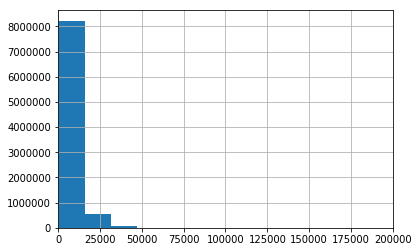

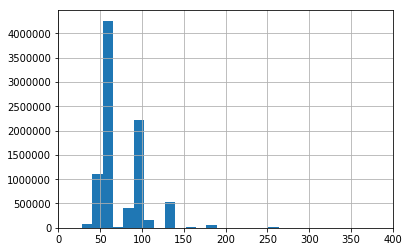

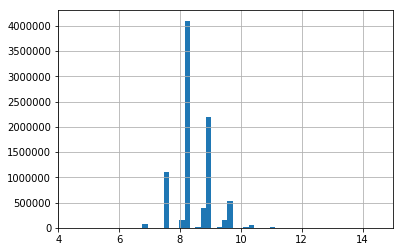

In [64]:
train_raw.Census_TotalPhysicalRAM.hist(bins=100).set_xlim(0,200000)
plt.figure()
train_raw.SqrtRam.hist(bins=100).set_xlim(0,400)
plt.figure()
np.log(train_raw.Census_TotalPhysicalRAM).hist(bins=50).set_xlim(4,15)

In [70]:
(np.log(train_raw.Census_TotalPhysicalRAM)).describe()

count    8.840950e+06
mean     8.531090e+00
std      5.837526e-01
min      5.541264e+00
25%      8.317766e+00
50%      8.317766e+00
75%      9.010913e+00
max      1.426841e+01
Name: Census_TotalPhysicalRAM, dtype: float64

In [77]:
mean_imp = Imputer(missing_values='NaN',  # Create imputation model
              strategy='mean',       # Use mean imputation
              axis=0) 

dd = mean_imp.fit_transform(train_raw[['Census_TotalPhysicalRAM']])
#(dd.astype(int)).describe()

In [84]:
len(dd)/len(train_raw)

1.0

In [82]:
pd.Series(dd.shape).astype(int).describe()

count    2.000000e+00
mean     4.460742e+06
std      6.308440e+06
min      1.000000e+00
25%      2.230372e+06
50%      4.460742e+06
75%      6.691112e+06
max      8.921483e+06
dtype: float64

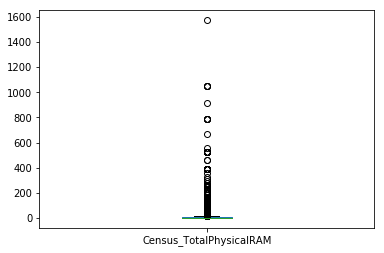

In [39]:
(train_raw.Census_TotalPhysicalRAM/1000).plot(kind='box')

In [236]:
abs(corr_matrix['Census_InternalPrimaryDisplayResolutionHorizontal']).sort_values(ascending=False)

Census_InternalPrimaryDisplayResolutionHorizontal    1.000000
Census_InternalPrimaryDisplayResolutionVertical      0.901547
Census_TotalPhysicalRAM                              0.370328
Census_ProcessorCoreCount                            0.347427
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.320102
Census_IsPenCapable                                  0.249847
Census_InternalBatteryNumberOfCharges                0.170702
Census_OSBuildNumber                                 0.160734
Census_ProcessorModelIdentifier                      0.157491
OsBuild                                              0.154010
Census_IsTouchEnabled                                0.143125
Census_FirmwareManufacturerIdentifier                0.132084
LocaleEnglishNameIdentifier                          0.127191
Wdft_IsGamer                                         0.104477
Census_IsAlwaysOnAlwaysConnectedCapable              0.092509
Census_FirmwareVersionIdentifier                     0.086616
Census_O

In [216]:
train_raw.dtypes

MachineIdentifier                                     object
ProductName                                           object
EngineVersion                                         object
AppVersion                                            object
AvSigVersion                                          object
IsBeta                                                 int64
RtpStateBitfield                                     float64
IsSxsPassiveMode                                       int64
DefaultBrowsersIdentifier                            float64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
HasTpm                                                 int64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier       

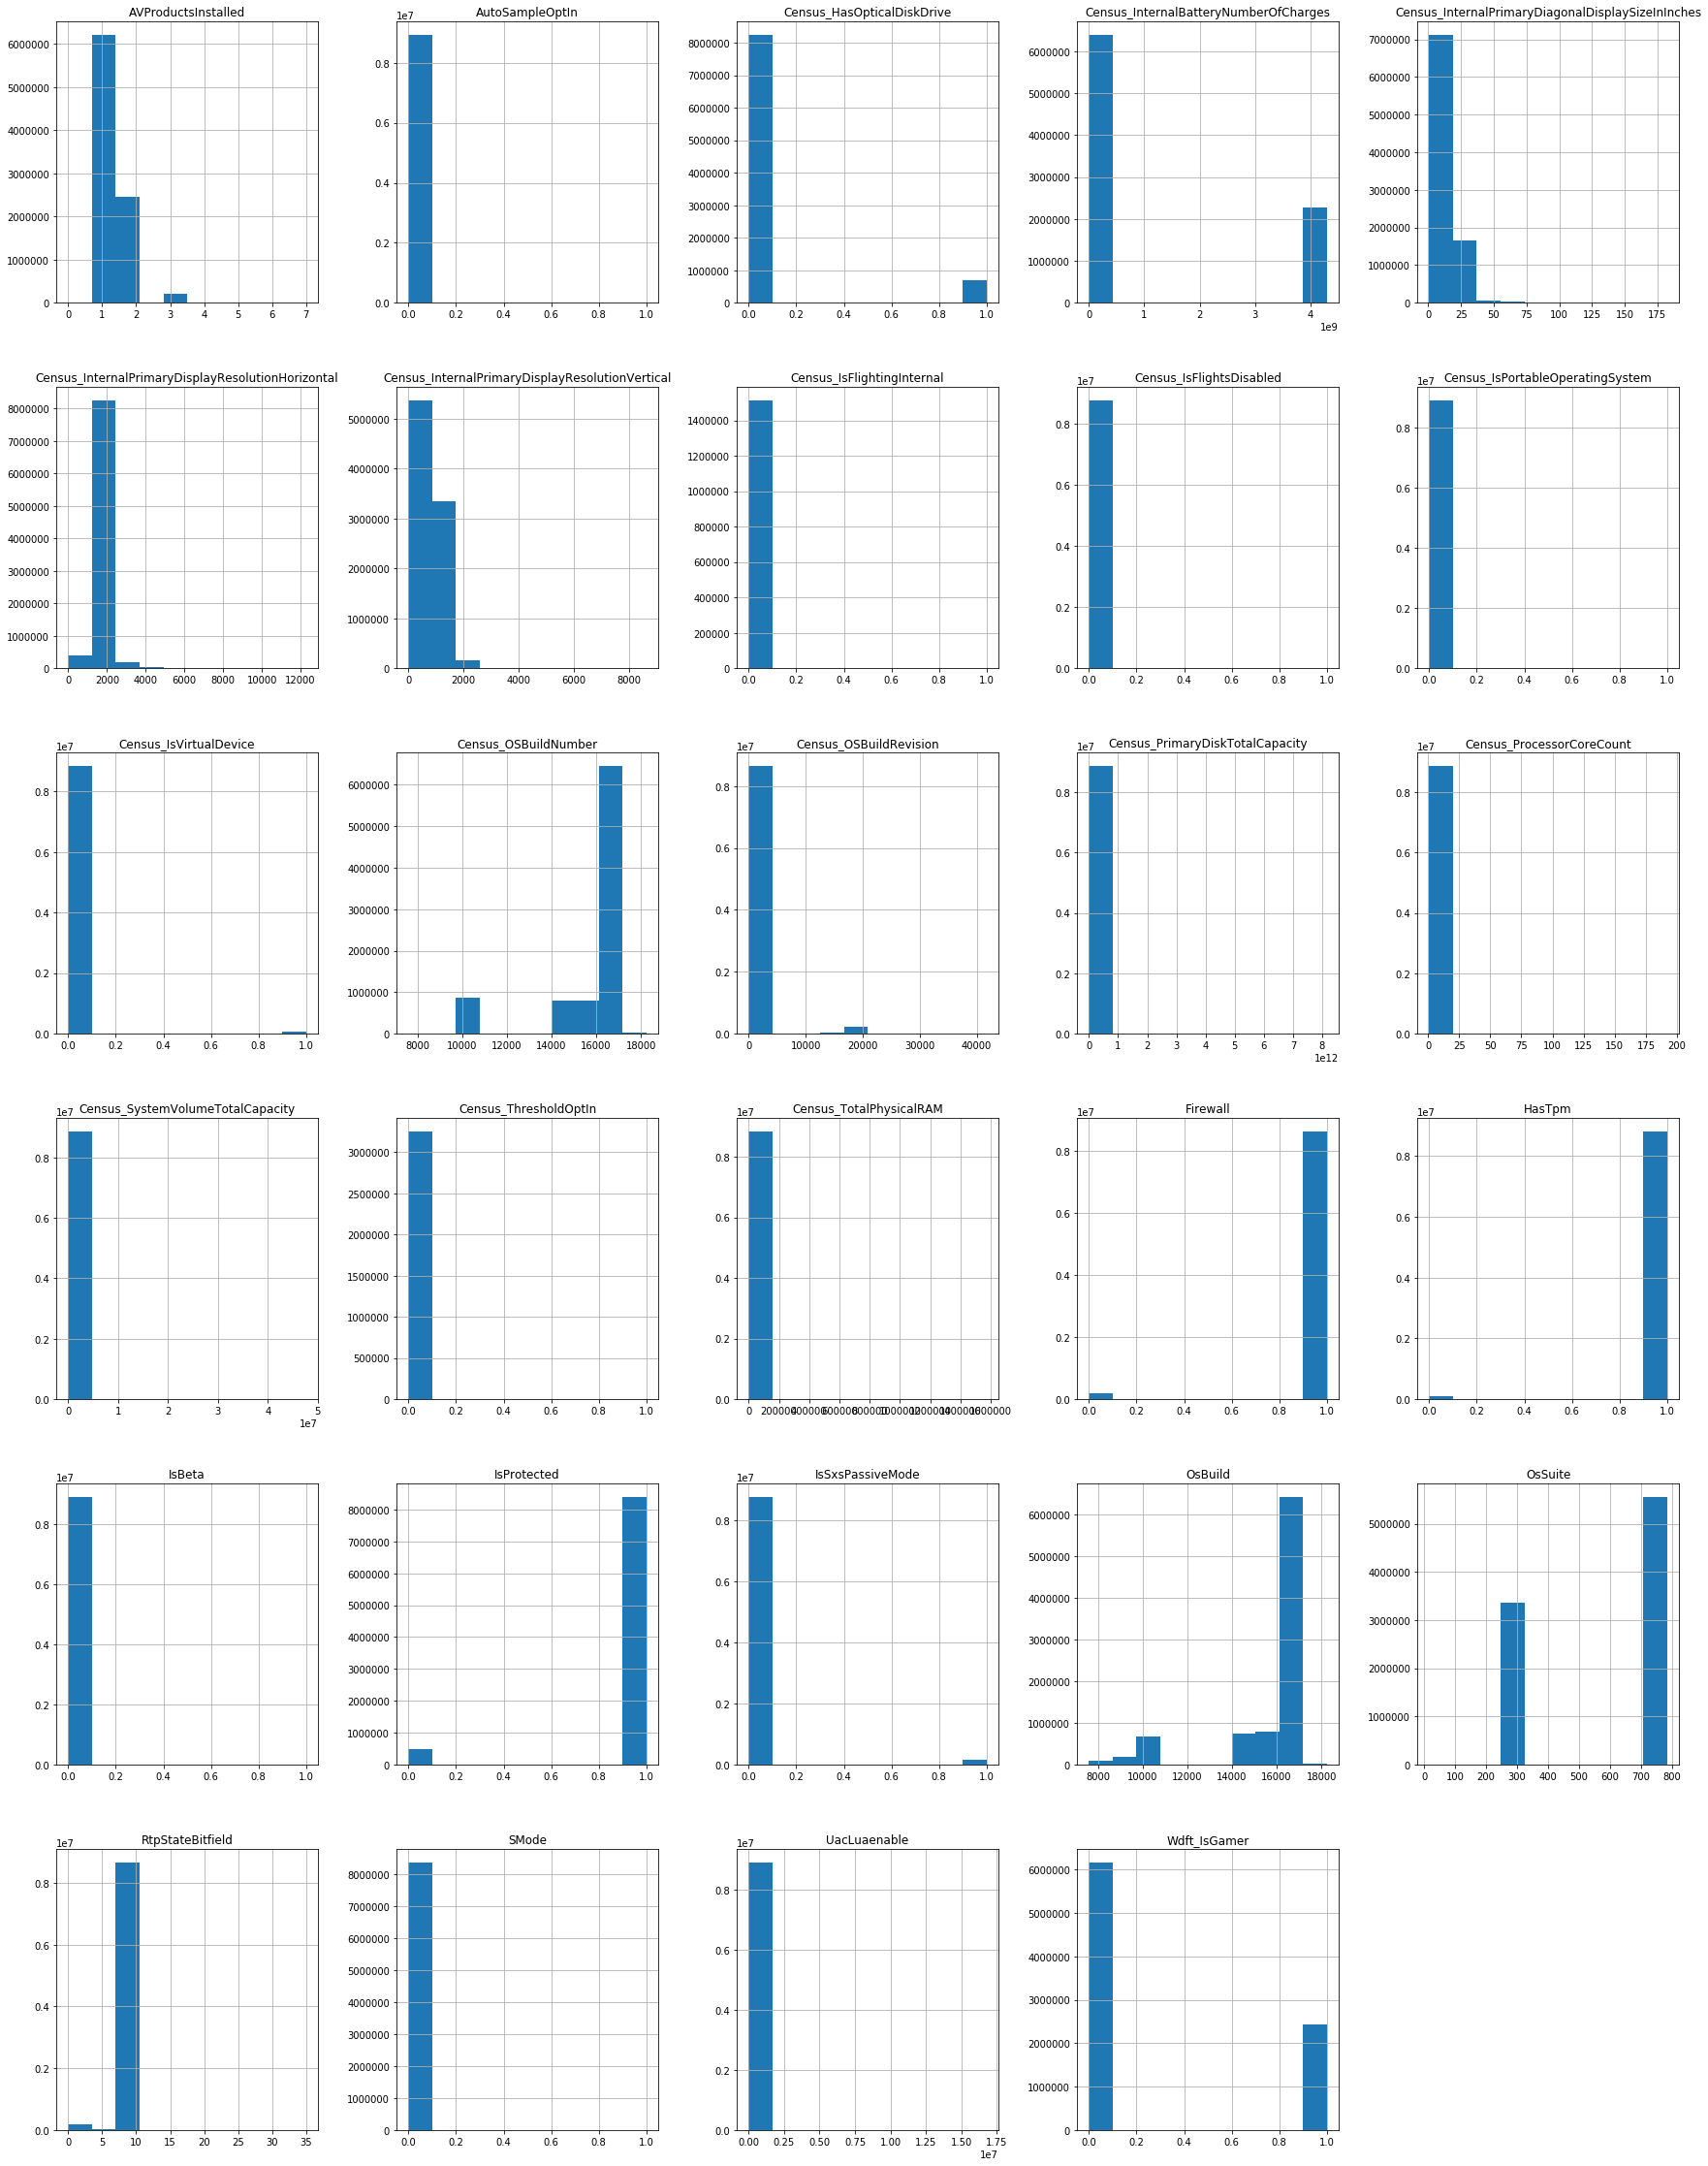

In [97]:
ns=non_cat_data.hist(figsize=(30,40))

In [107]:
vt=VarianceThreshold(threshold=(.8 * (1 - .8)))
vt.fit_transform(dd)

array([[7.0000e+00, 1.0000e+00, 1.7134e+04, ..., 1.7134e+04, 1.6500e+02,
        0.0000e+00],
       [7.0000e+00, 1.0000e+00, 1.7134e+04, ..., 1.7134e+04, 1.0000e+00,
        0.0000e+00],
       [7.0000e+00, 1.0000e+00, 1.7134e+04, ..., 1.7134e+04, 1.6500e+02,
        0.0000e+00],
       ...,
       [7.0000e+00, 1.0000e+00, 1.6299e+04, ..., 1.6299e+04, 3.7100e+02,
        0.0000e+00],
       [7.0000e+00, 3.0000e+00, 1.5063e+04, ..., 1.5063e+04, 4.8300e+02,
        0.0000e+00],
       [7.0000e+00, 2.0000e+00, 1.7134e+04, ..., 1.7134e+04, 2.2800e+02,
        0.0000e+00]])

In [108]:
vt.get_support()

array([False,  True, False,  True, False,  True,  True, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False,  True])

In [109]:
vt.variances_

array([7.50990579e-06, 1.04897531e+00, 1.70333175e-02, 2.72342568e-01,
       1.18842464e-02, 4.79910079e+06, 6.15459908e+04, 5.12117465e-02,
       2.89181226e-05, 4.34815983e-04, 2.07441467e-02, 9.72545876e+07,
       4.31694799e+00, 1.96992818e+19, 1.05566240e+11, 7.12294032e-02,
       2.59353707e+07, 3.45431776e+01, 1.34982922e+05, 4.58208037e+04,
       3.45636417e+18, 3.84843487e+06, 8.59645240e+06, 5.44903593e-04,
       2.35383607e-06, 9.86373186e-06, 9.14416788e-05, 6.97739346e-03,
       1.96251510e-01])

In [125]:
non_cat_cols = non_cat_data.columns

In [140]:
non_cat_data.head(20)

IsBeta  RtpStateBitfield  IsSxsPassiveMode  AVProductsInstalled  HasTpm  \
0        0               7.0                 0                  1.0       1   
1        0               7.0                 0                  1.0       1   
2        0               7.0                 0                  1.0       1   
3        0               7.0                 0                  1.0       1   
4        0               7.0                 0                  1.0       1   
5        0               7.0                 0                  1.0       1   
6        0               7.0                 0                  2.0       1   
7        0               7.0                 0                  1.0       1   
8        0               7.0                 0                  1.0       1   
9        0               7.0                 0                  2.0       1   
10       0               7.0                 0                  1.0       1   
11       0               7.0                 0                  2.0       1   
12       0               7.0                 0                  2.0       1   
13       0               7.0                 0                  1.0       1   
14       0               7.0                 0                  2.0       1   
15       0               7.0                 0                  2.0       1   
16       0               7.0                 0                  1.0       0   
17       0               0.0                 1                  1.0       1   
18       0               7.0                 0                  1.0       1   
19       0               7.0                 0                  2.0       1   

    OsBuild  OsSuite  IsProtected  AutoSampleOptIn  SMode  Firewall  \
0     17134      256          1.0                0    0.0       1.0   
1     17134      256          1.0                0    0.0       1.0   
2     17134      768          1.0                0    0.0       1.0   
3     17134      256          1.0                0    0.0       1.0   
4     17134      768          1.0                0    0.0       1.0   
5     17134      256          1.0                0    0.0       1.0   
6     17134      768          1.0                0    0.0       1.0   
7     14393      768          1.0                0    0.0       1.0   
8     17134      256          1.0                0    0.0       1.0   
9     16299      768          1.0                0    0.0       1.0   
10    17134      256          1.0                0    0.0       1.0   
11    17134      768          1.0                0    0.0       1.0   
12    17134      256          1.0                0    0.0       1.0   
13    17134      256          1.0                0    0.0       1.0   
14    17134      768          1.0                0    0.0       1.0   
15    17134      256          1.0                0    0.0       1.0   
16     7601      768          1.0                0    0.0       1.0   
17    16299      256          1.0                0    0.0       1.0   
18    17134      768          1.0                0    NaN       1.0   
19    16299      768          1.0                0    0.0       1.0   

    UacLuaenable  Census_ProcessorCoreCount  Census_PrimaryDiskTotalCapacity  \
0            1.0                        4.0                         476940.0   
1            1.0                        4.0                         476940.0   
2            1.0                        4.0                         114473.0   
3            1.0                        4.0                         238475.0   
4            1.0                        4.0                         476940.0   
5            1.0                        2.0                         114473.0   
6            1.0                        2.0                         476940.0   
7            1.0                        2.0                         305245.0   
8            1.0                        4.0                         305245.0   
9            1.0                        4.0         

In [134]:
mean_imp = Imputer(missing_values='NaN',  # Create imputation model
              strategy='mean',       # Use mean imputation
              axis=0) 
#dd = mean_imp.fit_transform(non_cat_data[['AVProductsInstalled','AutoSampleOptIn']])
dd = pd.DataFrame(np.sqrt(abs(mean_imp.fit_transform(non_cat_data[non_cat_cols]))), columns = non_cat_cols)

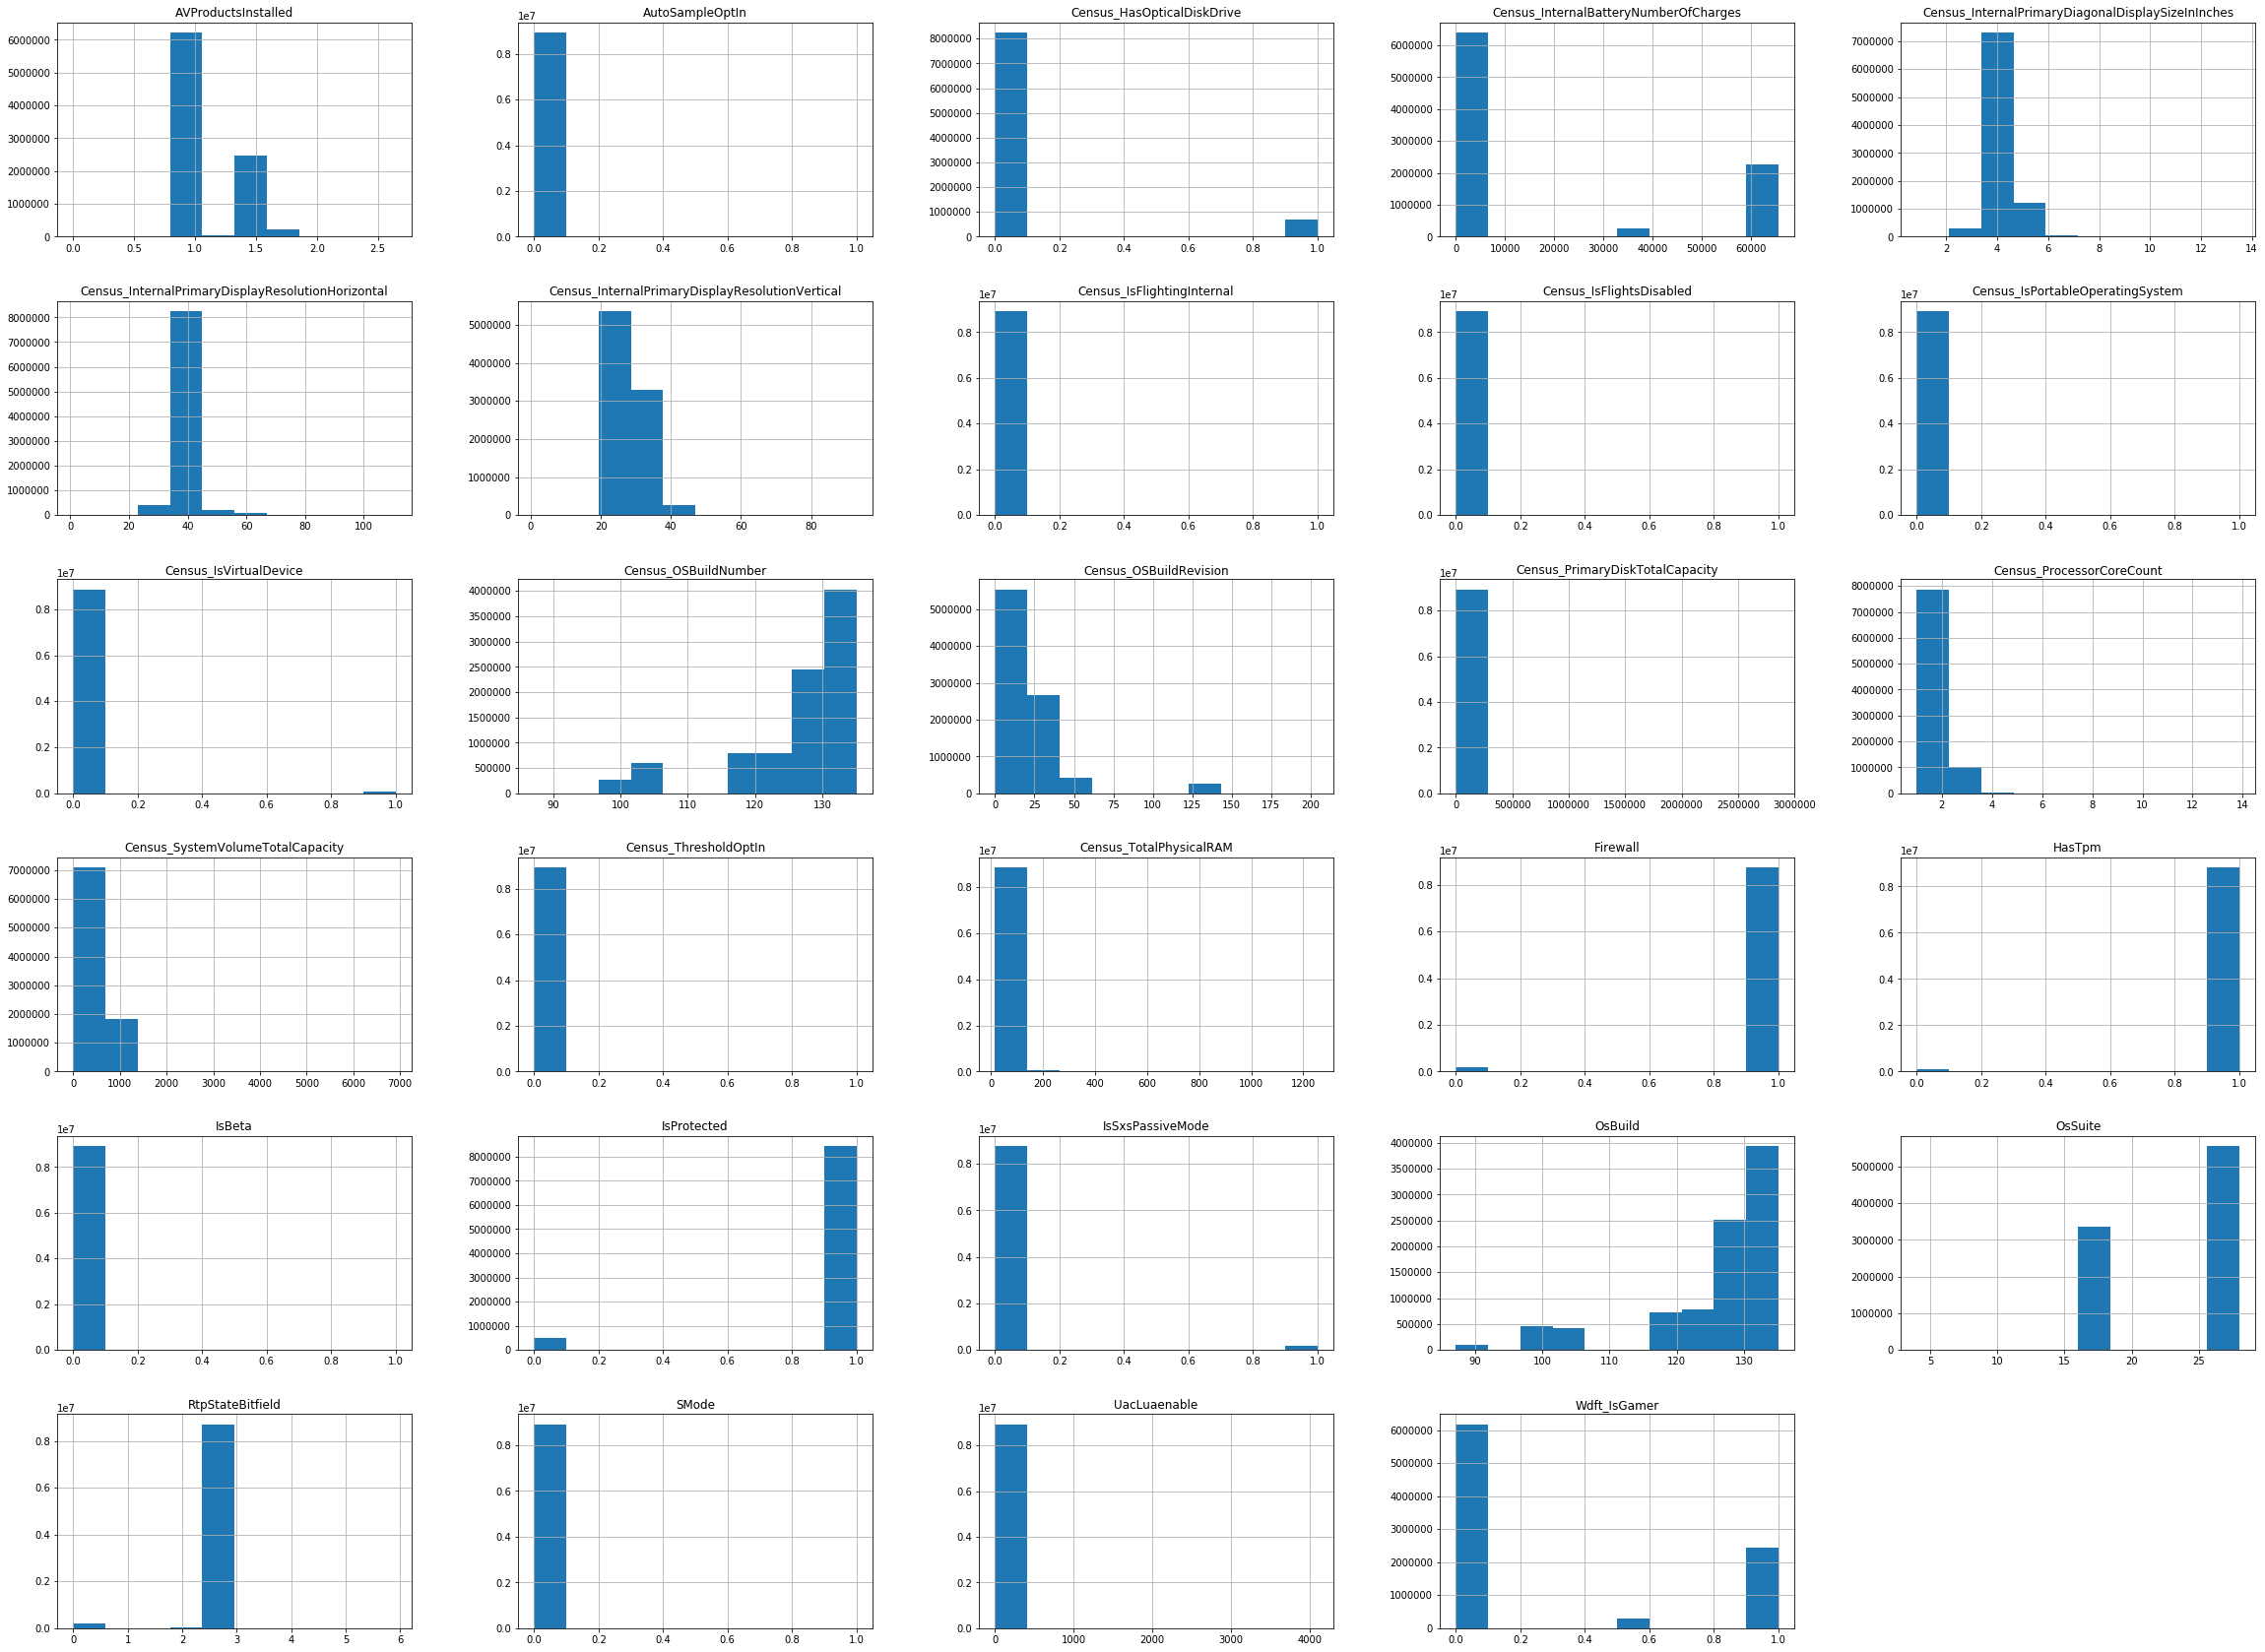

In [135]:
ns=dd.hist(figsize=(40,30))

In [136]:
mean_imp = Imputer(missing_values='NaN',  # Create imputation model
              strategy='mean',       # Use mean imputation
              axis=0) 
#dd = mean_imp.fit_transform(non_cat_data[['AVProductsInstalled','AutoSampleOptIn']])
dd = pd.DataFrame(np.log(abs(mean_imp.fit_transform(non_cat_data[non_cat_cols]))+1), columns = non_cat_cols)

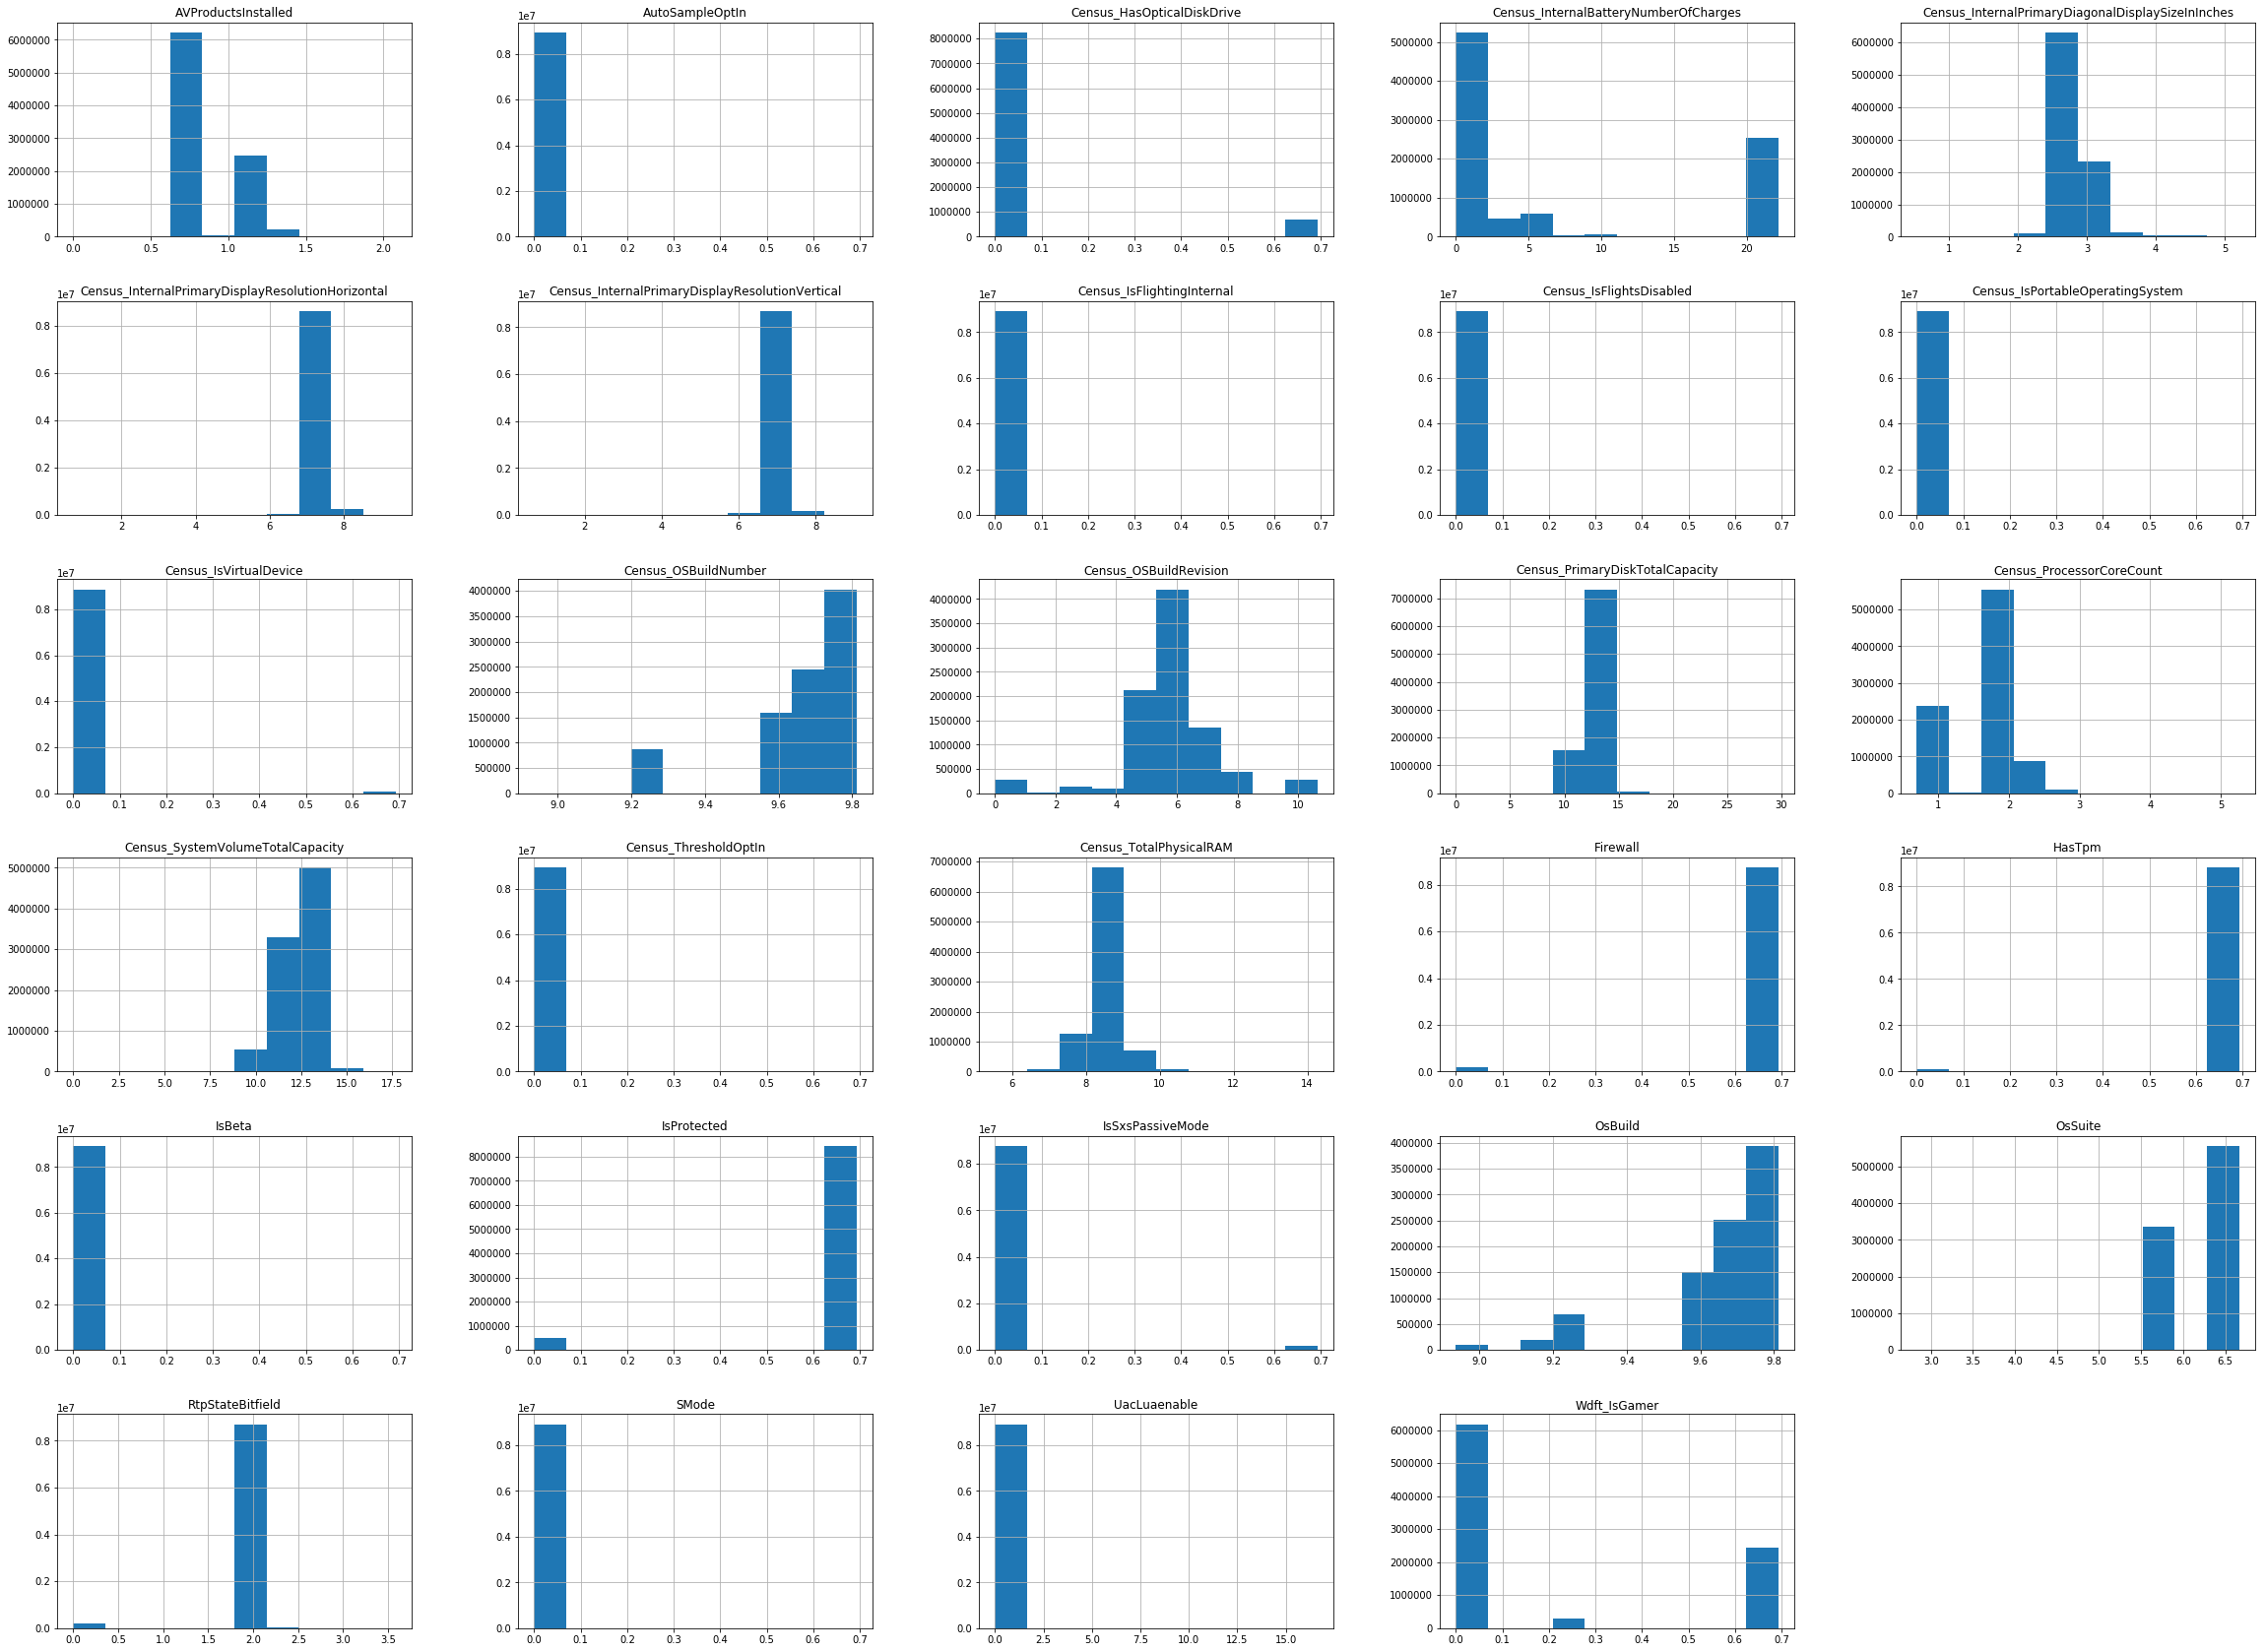

In [137]:
ns=dd.hist(figsize=(40,30))

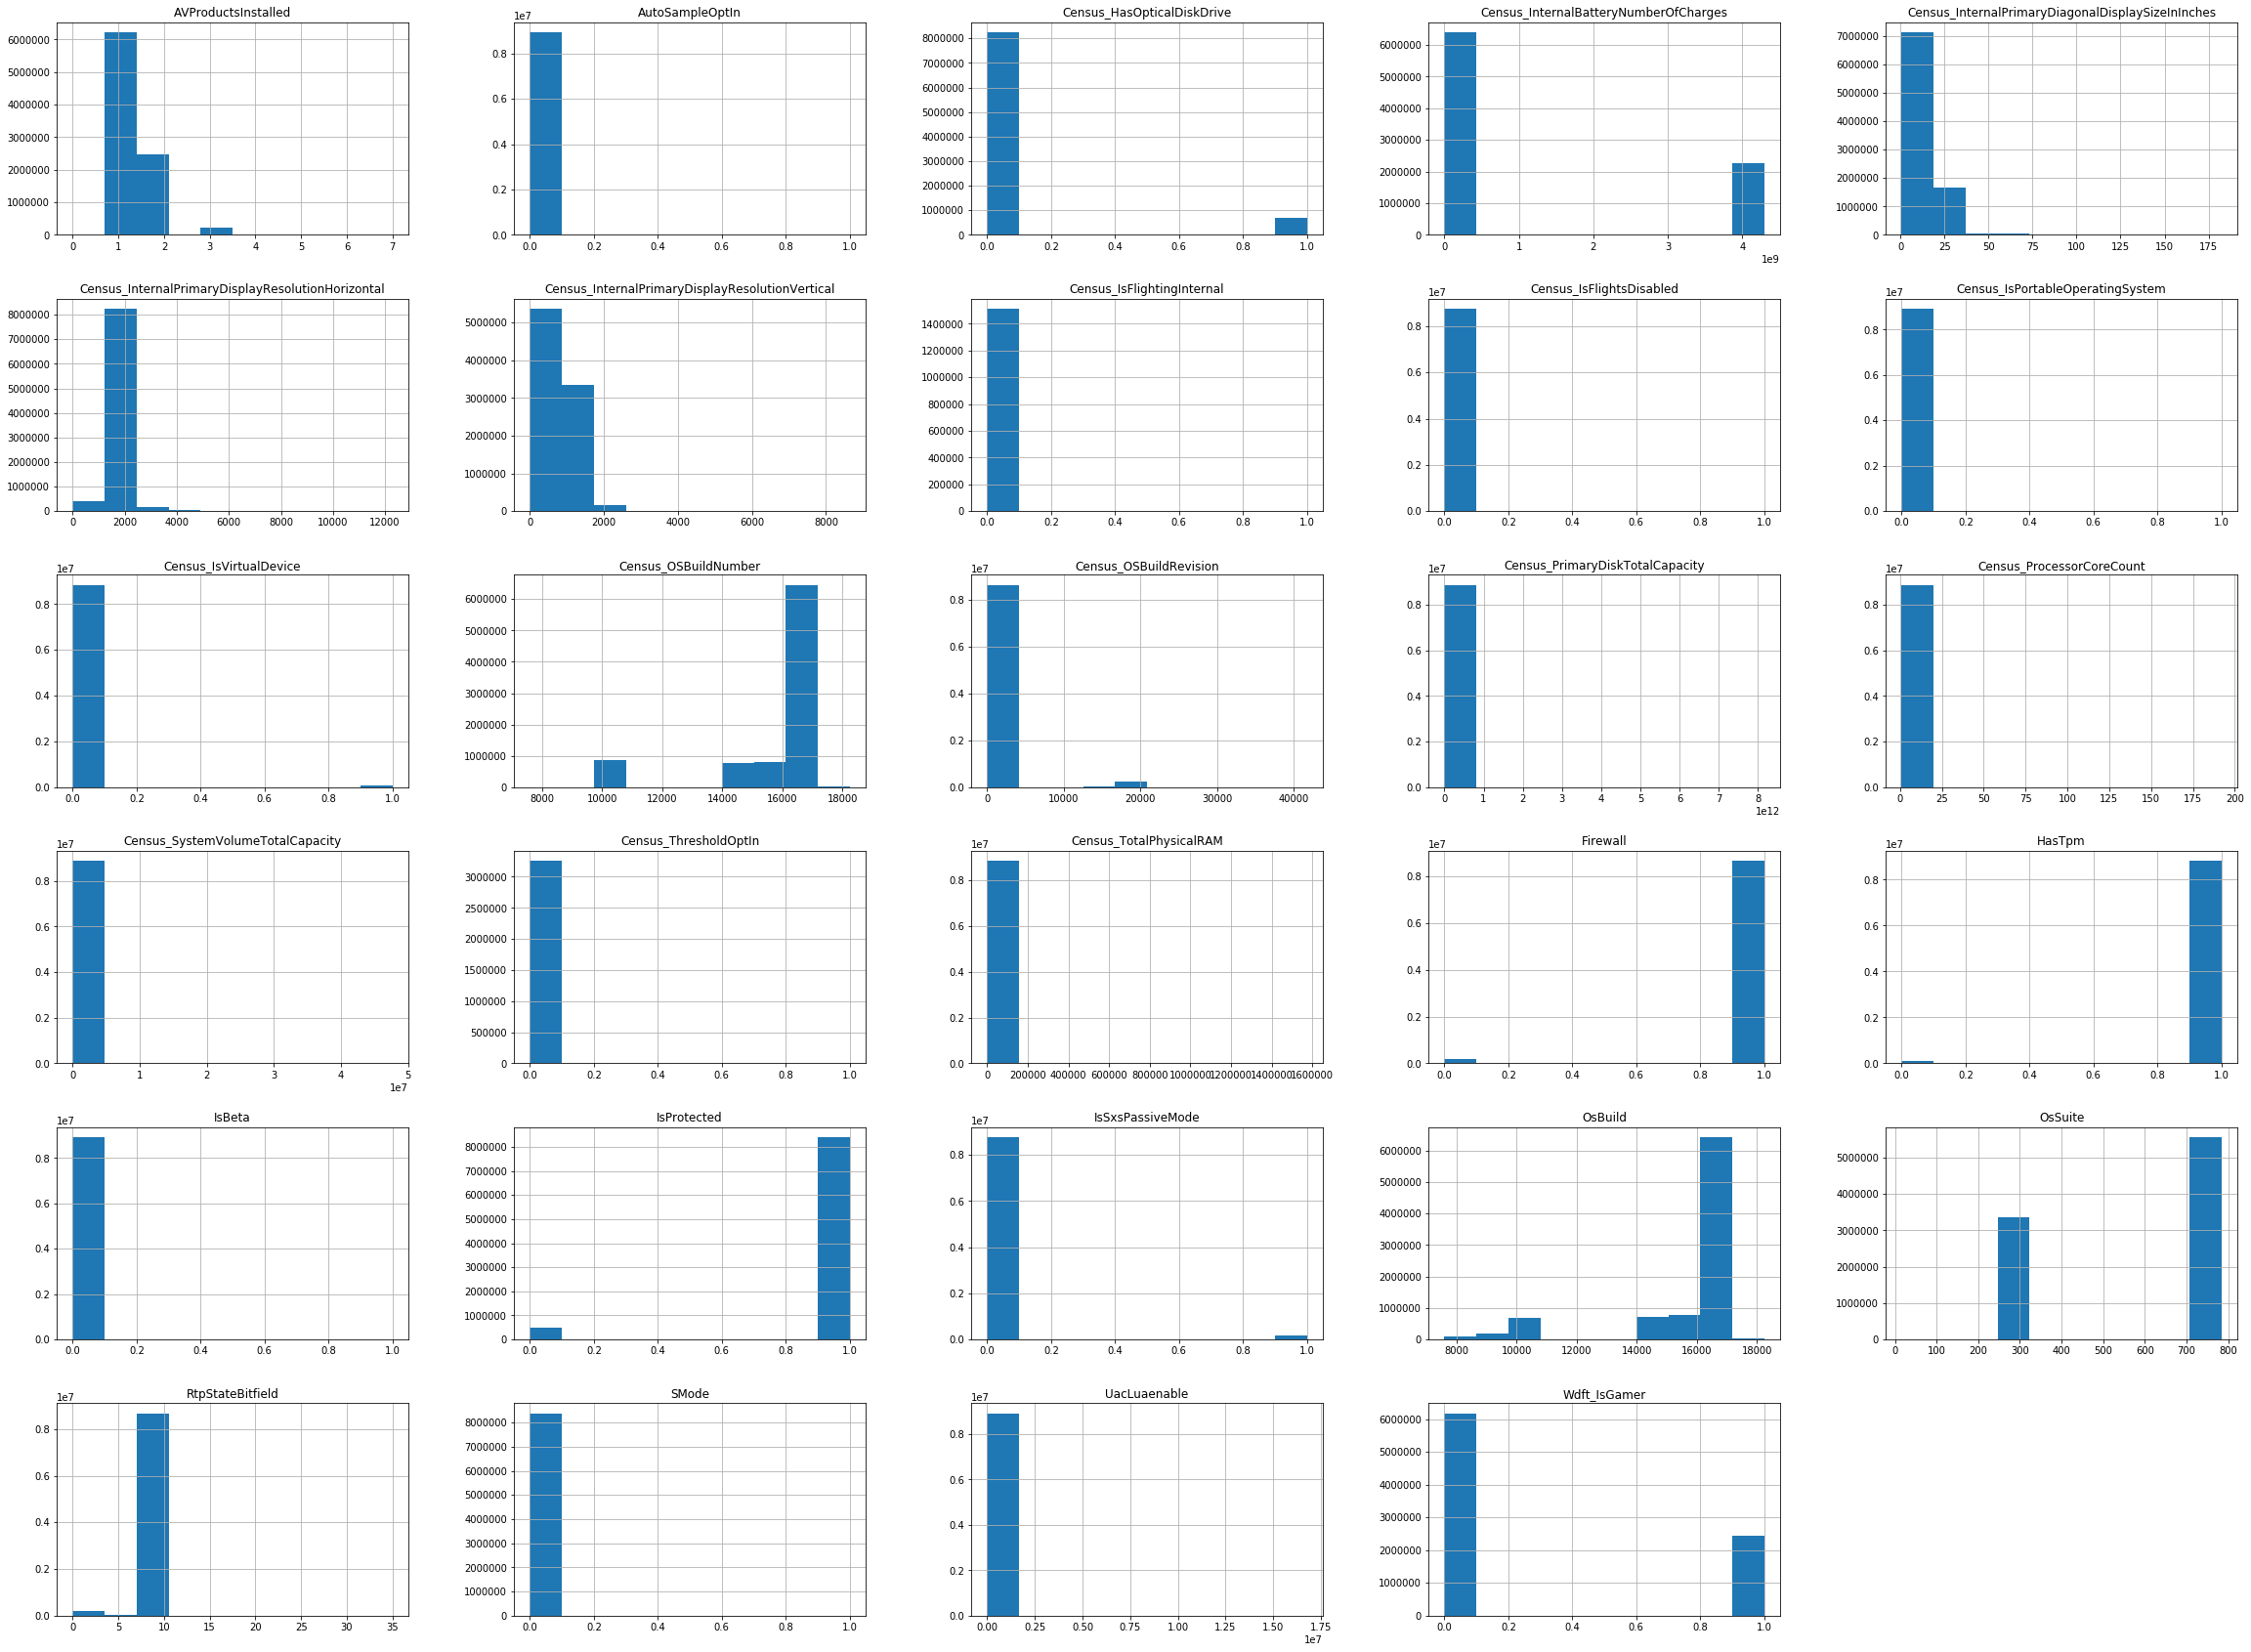

In [129]:
#ns=non_cat_data[['AVProductsInstalled','AutoSampleOptIn']].hist(figsize=(5,3))
ns=non_cat_data[non_cat_cols].hist(figsize=(40,30))

In [223]:
non_cat_data.head()

IsBeta  RtpStateBitfield  IsSxsPassiveMode  AVProductsInstalled  HasTpm  \
0       0               7.0                 0                  1.0       1   
1       0               7.0                 0                  1.0       1   
2       0               7.0                 0                  1.0       1   
3       0               7.0                 0                  1.0       1   
4       0               7.0                 0                  1.0       1   

   OsBuild  OsSuite  IsProtected  AutoSampleOptIn  SMode  Firewall  \
0    17134      256          1.0                0    0.0       1.0   
1    17134      256          1.0                0    0.0       1.0   
2    17134      768          1.0                0    0.0       1.0   
3    17134      256          1.0                0    0.0       1.0   
4    17134      768          1.0                0    0.0       1.0   

   UacLuaenable  Census_ProcessorCoreCount  Census_PrimaryDiskTotalCapacity  \
0           1.0                        4.0                         476940.0   
1           1.0                        4.0                         476940.0   
2           1.0                        4.0                         114473.0   
3           1.0                        4.0                         238475.0   
4           1.0                        4.0                         476940.0   

   Census_SystemVolumeTotalCapacity  Census_HasOpticalDiskDrive  \
0                          299451.0                           0   
1                          102385.0                           0   
2                          113907.0                           0   
3                          227116.0                           0   
4                          101900.0                           0   

   Census_TotalPhysicalRAM  Census_InternalPrimaryDiagonalDisplaySizeInInches  \
0                   4096.0                                               18.9   
1                   4096.0                                               13.9   
2                   4096.0                                               21.5   
3                   4096.0                                               18.5   
4                   6144.0                                               14.0   

   Census_InternalPrimaryDisplayResolutionHorizontal  \
0                                             1440.0   
1                                             1366.0   
2                                             1920.0   
3                                             1366.0   
4                                             1366.0   

   Census_InternalPrimaryDisplayResolutionVertical  \
0                                            900.0   
1                                            768.0   
2                                           1080.0   
3                                            768.0   
4                                            768.0   

   Census_InternalBatteryNumberOfCharges  Census_OSBuildNumber  \
0                           4.294967e+09                 17134   
1                           1.000000e+00                 17134   
2                           4.294967e+09                 17134   
3                           4.294967e+09                 17134   
4                           0.000000e+00                 17134   

   Census_OSBuildRevision  Census_IsPortableOperatingSystem  \
0                     165                                 0   
1                       1                                 0   
2                     165                                 0   
3                     228                                 0   
4                     191                                 0   

   Census_IsFlightingInternal  Census_IsFlightsDisabled  \
0                         NaN                       0.0   
1                         NaN                       0.0   
2                         NaN                       0.0   
3                         NaN                       0.0   
4              

In [233]:
non_cat_data.Census_InternalPrimaryDisplayResolutionHorizontal.value_counts().sort_index(ascending=False)

 12288.0          3
 11520.0          7
 10320.0          4
 9600.0           2
 8678.0           1
 8192.0           3
 7680.0          40
 7200.0           1
 6880.0           4
 6720.0           3
 6480.0           4
 6400.0           9
 6236.0           1
 6160.0           1
 6144.0           1
 6081.0           1
 6062.0           1
 6048.0           3
 6034.0           1
 6030.0           1
 6016.0          10
 6015.0           1
 6010.0           1
 6000.0           2
 5984.0           1
 5980.0           2
 5970.0           3
 5968.0           1
 5964.0           1
 5960.0           2
 5945.0           1
 5930.0           1
 5920.0           1
 5906.0           2
 5904.0           1
 5900.0           1
 5888.0           1
 5880.0           1
 5876.0           1
 5873.0           1
 5870.0           1
 5856.0           1
 5840.0           1
 5830.0           1
 5776.0           1
 5760.0         330
 5755.0           1
 5560.0           1
 5472.0           1
 5462.0           1


In [234]:
non_cat_data.Census_InternalPrimaryDisplayResolutionVertical.value_counts().sort_index(ascending=False)

 8640.0          1
 6480.0          1
 5760.0          1
 5431.0          1
 4500.0          1
 4320.0         14
 4050.0          1
 3840.0        132
 3780.0          1
 3774.0          1
 3736.0          1
 3718.0          1
 3658.0          1
 3648.0          1
 3600.0          8
 3440.0          2
 3384.0         10
 3338.0          1
 3332.0          1
 3314.0          1
 3270.0          1
 3240.0         25
 3200.0         35
 3168.0          1
 3072.0          1
 3055.0          1
 3000.0        532
 2960.0          1
 2956.0          1
 2900.0          1
 2880.0       1588
 2860.0          1
 2858.0          1
 2836.0          6
 2816.0          1
 2800.0          2
 2778.0          1
 2764.0          4
 2760.0          1
 2758.0         14
 2756.0          2
 2752.0          1
 2748.0          5
 2736.0       1089
 2708.0          1
 2700.0          2
 2694.0          1
 2690.0          1
 2670.0          1
 2662.0          1
 2658.0          1
 2654.0          2
 2652.0     

In [182]:
(data_raw.count()/len(data_raw)*100).sort_values(ascending=False)

MachineIdentifier                                    100.000000
Census_OSBuildRevision                               100.000000
Census_OSBranch                                      100.000000
Census_OSArchitecture                                100.000000
Census_OSVersion                                     100.000000
AvSigVersion                                         100.000000
HasTpm                                               100.000000
Census_HasOpticalDiskDrive                           100.000000
IsBeta                                               100.000000
Census_DeviceFamily                                  100.000000
Census_MDC2FormFactor                                100.000000
IsSxsPassiveMode                                     100.000000
AutoSampleOptIn                                      100.000000
SkuEdition                                           100.000000
OsPlatformSubRelease                                 100.000000
OsSuite                                 

In [169]:
#cat_data.Census_OSBranch.value_counts()
#cat_data.OsPlatformSubRelease.value_counts()
#cat_data.Census_OSEdition.value_counts()
cat_data.DefaultBrowsersIdentifier.value_counts()/len(cat_data)*100

239.0     0.516237
3195.0    0.478530
1632.0    0.322267
3176.0    0.271480
146.0     0.232652
1910.0    0.217632
1727.0    0.194956
2064.0    0.156812
2725.0    0.149504
1160.0    0.141165
1536.0    0.126728
788.0     0.126683
1623.0    0.116640
1078.0    0.115082
1823.0    0.082912
2273.0    0.077084
2290.0    0.075750
614.0     0.073295
2388.0    0.071401
773.0     0.066133
1622.0    0.059766
2168.0    0.055764
1161.0    0.054823
139.0     0.047593
1926.0    0.045934
1616.0    0.041428
2434.0    0.039130
2170.0    0.032539
2169.0    0.030824
597.0     0.026744
2182.0    0.024480
2726.0    0.022597
890.0     0.022294
1991.0    0.020826
2987.0    0.020624
1628.0    0.020467
2460.0    0.019537
508.0     0.018943
223.0     0.017060
1071.0    0.016937
1870.0    0.016701
1079.0    0.016354
311.0     0.016197
2189.0    0.015233
168.0     0.014437
2724.0    0.013327
1351.0    0.013047
1952.0    0.010951
230.0     0.010783
3000.0    0.009976
351.0     0.008642
1118.0    0.008328
2373.0    0.

In [128]:
cat_data.Platform.value_counts()

windows10      8618715
windows8        194508
windows7         93889
windows2016      14371
Name: Platform, dtype: int64

In [193]:
#pd.crosstab(train_raw.Platform, train_raw.HasDetections)
pd.crosstab(train_raw.HasDetections,train_raw.OrganizationIdentifier, margins=True, normalize=False)

OrganizationIdentifier  1.0   2.0  3.0   4.0   5.0  6.0  7.0  8.0  10.0  \
HasDetections                                                             
0                       468  1598  198   776  1084  279   61  306   620   
1                       425   997  133   609   906  133   37  417   463   
All                     893  2595  331  1385  1990  412   98  723  1083   

OrganizationIdentifier   11.0  12.0  14.0  15.0  16.0  17.0     18.0  19.0  \
HasDetections                                                                
0                        9393     5  2782     7   140     0   872022   113   
1                       10043     2  1931     6   102     1   892153    59   
All                     19436     7  4713    13   242     1  1764175   172   

OrganizationIdentifier  20.0  21.0  22.0  23.0  25.0  26.0     27.0  28.0  \
HasDetections                                                               
0                        368   291   210    14     9   111  2108365   787   
1                        547   106   208     6     3    49  2088092   804   
All                      915   397   418    20    12   160  4196457  1591   

OrganizationIdentifier  29.0  30.0  31.0  32.0  33.0  34.0  35.0  36.0   37.0  \
HasDetections                                                                   
0                         70    41   219  1962  1713     1    21  1776  10365   
1                         65    23   179  2083  1183     1    11  2133   9033   
All                      135    64   398  4045  2896     2    32  3909  19398   

OrganizationIdentifier  38.0  39.0  40.0  41.0  42.0  43.0  44.0  45.0   46.0  \
HasDetections                                                                   
0                          0   222   929    36    60    32    70    41   5331   
1                          1   191   719    41    72    28    80    32   5643   
All                        1   413  1648    77   132    60   150    73  10974   

OrganizationIdentifier  47.0   48.0   49.0   50.0  51.0  52.0      All  
HasDetections                                                           
0                        197  30634   7406  17750   501  1542  3080926  
1                        188  33211   6221  27752   416  1501  3089039  
All                      385  63845  13627  45502   917  3043  6169965

In [ ]:
cross

In [25]:
pd.set_option('max_rows', None)
data_raw.dtypes

MachineIdentifier                                     object
ProductName                                           object
EngineVersion                                         object
AppVersion                                            object
AvSigVersion                                          object
IsBeta                                                 int64
RtpStateBitfield                                     float64
IsSxsPassiveMode                                       int64
DefaultBrowsersIdentifier                            float64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
HasTpm                                                 int64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier       

In [164]:
pd.crosstab(train_raw.HasDetections, [train_raw.Platform, train_raw.Census_OSEdition], margins=True, normalize='index')

Platform         windows10                                              \
Census_OSEdition     Cloud        CloudN      Core CoreCountrySpecific   
HasDetections                                                            
0                 0.000829  4.481701e-07  0.394214            0.017783   
1                 0.000546  0.000000e+00  0.352484            0.017861   
All               0.000688  2.241780e-07  0.373357            0.017822   

Platform                                                                       \
Census_OSEdition     CoreN CoreSingleLanguage Education EducationN Enterprise   
HasDetections                                                                   
0                 0.000567           0.197720  0.004252   0.000111   0.003854   
1                 0.000477           0.222165  0.004818   0.000094   0.004127   
All               0.000522           0.209938  0.004535   0.000103   0.003990   

Platform                                                                    \
Census_OSEdition Enterprise 2015 LTSB EnterpriseN EnterpriseS EnterpriseSN   
HasDetections                                                                
0                        2.240851e-07    0.000036    0.002173     0.000076   
1                        0.000000e+00    0.000042    0.002315     0.000121   
All                      1.120890e-07    0.000039    0.002244     0.000098   

Platform                                                                 \
Census_OSEdition          Home   HomePremium           Pro Professional   
HasDetections                                                             
0                 4.481701e-07  0.000000e+00  2.240851e-07     0.335268   
1                 4.485419e-07  2.242710e-07  0.000000e+00     0.351266   
All               4.483560e-07  1.120890e-07  1.120890e-07     0.343264   

Platform                                                            \
Census_OSEdition ProfessionalCountrySpecific ProfessionalEducation   
HasDetections                                                        
0                               6.722552e-07              0.005688   
1                               4.485419e-07              0.006870   
All                             5.604449e-07              0.006279   

Platform                                               \
Census_OSEdition ProfessionalEducationN ProfessionalN   
HasDetections                                           
0                              0.000021      0.002981   
1                              0.000022      0.003304   
All                            0.000022      0.003142   

Platform                                                             \
Census_OSEdition ProfessionalSingleLanguage ProfessionalWorkstation   
HasDetections                                                         
0                              2.240851e-07                0.000019   
1                              4.485419e-07                0.000009   
All                            3.362670e-07                0.000014   

Platform                                                    \
Census_OSEdition ProfessionalWorkstationN ServerDatacenter   
HasDetections                                                
0                                0.000001     2.016766e-06   
1                                0.000001     6.728129e-07   
All                              0.000001     1.345068e-06   

Platform                                                            \
Census_OSEdition ServerDatacenterACor    ServerRdsh ServerSolution   
HasDetections                                                        
0                        2.240851e-07  4.481701e-07   2.240851e-07   
1                        0.000000e+00  2.242710e-07   0.000000e+00   
All                      1.120890e-07  3.362670e-07   1.120890e-07   

Platform                                             windows2016  \
Census_OSEdition ServerStandard  professional CoreSingleLanguage   
HasDetections              

In [141]:
pd.crosstab(train_raw.HasDetections, train_raw.Platform, normalize='columns', margins=True)

Platform       windows10  windows2016  windows7  windows8       All
HasDetections                                                      
0               0.499968     0.650407  0.513489   0.49328  0.500207
1               0.500032     0.349593  0.486511   0.50672  0.499793

In [211]:
pd.crosstab(train_raw.HasDetections, train_raw.Firewall, normalize=True, margins=True)

Firewall            0.0       1.0       All
HasDetections                              
0              0.010932  0.489223  0.500154
1              0.010486  0.489360  0.499846
All            0.021417  0.978583  1.000000

In [16]:
%%time
rows = train_raw.shape
perc_count = (train_raw.count()/rows[0]*100)

In [29]:
perc_count.sort_values(ascending=False)

HasDetections                                        100.000000
OsVer                                                100.000000
Census_OSArchitecture                                100.000000
Census_OSVersion                                     100.000000
Census_HasOpticalDiskDrive                           100.000000
Census_DeviceFamily                                  100.000000
Census_MDC2FormFactor                                100.000000
AutoSampleOptIn                                      100.000000
SkuEdition                                           100.000000
OsPlatformSubRelease                                 100.000000
OsSuite                                              100.000000
OsBuild                                              100.000000
Processor                                            100.000000
Census_OSBuildNumber                                 100.000000
Platform                                             100.000000
LocaleEnglishNameIdentifier             

In [48]:
pd.get_option("display.max_columns")

In [12]:
data_raw.head(100)

MachineIdentifier   ProductName EngineVersion  \
0   0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1   000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2   000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3   00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4   000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   
5   000016191b897145d069102325cab760  win8defender   1.1.15100.1   
6   0000161e8abf8d8b89c5ab8787fd712b  win8defender   1.1.15100.1   
7   000019515bc8f95851aff6de873405e8  win8defender   1.1.15100.1   
8   00001a027a0ab970c408182df8484fce  win8defender   1.1.15200.1   
9   00001a18d69bb60bda9779408dcf02ac  win8defender   1.1.15100.1   
10  00001b3b3cf8c8c079a272ce51031753  win8defender   1.1.15100.1   
11  00001b924fcc6922321cfadbafd8a91a  win8defender   1.1.15100.1   
12  00001f26e9e5775277d6231fc6ac9e70  win8defender   1.1.15100.1   
13  000024872c81cf03fa862aa8f99e0984  win8defender   1.1.15200.1   
14  0000258d2b847c7549150cfec6464473  win8defender   1.1.15100.1   
15  000027c68b89acb49d4017763b043449  win8defender   1.1.15200.1   
16  000028150912f45b1dc667164de489ef           mse   1.1.15200.1   
17  00002a7fd74f9ca4a59a679a7cc80388  win8defender   1.1.15100.1   
18  00002b7454f06444e8d9f6083d8a9ebd  win8defender   1.1.15300.6   
19  00002c6cccecdef94aaa557d0458ab8a  win8defender   1.1.15100.1   
20  0000309dcbba938f8aa7ee5a0204119d  win8defender   1.1.15100.1   
21  000033565d8f7a3029afd1d6c4c465e9  win8defender   1.1.15100.1   
22  0000378813e163d00d5e5f7e0a12b6d9  win8defender   1.1.15200.1   
23  000037f84e21c83328ba6963cdac497b  win8defender   1.1.15200.1   
24  000038f24a1ee98931456b3e49f7934b  win8defender   1.1.15200.1   
25  000039104d7f42c15fdc0d1bcb9d4b4a  win8defender   1.1.15200.1   
26  000039c280a86ff549f7f3526e918ae4  win8defender   1.1.15100.1   
27  00003ad63e561a25415551cd47d426d5  win8defender   1.1.15300.6   
28  00003e5e679ccfe7a13e953c47dd584f  win8defender   1.1.15200.1   
29  0000422df51e713f82b98e04cb883cb5  win8defender   1.1.15100.1   
..                               ...           ...           ...   
70  0000a313e380907701398b3c61f58848  win8defender   1.1.15200.1   
71  0000a559e4f2f5cad96124101d7d94e5  win8defender   1.1.15200.1   
72  0000a59784f4658c3a9820d801cc6e28  win8defender   1.1.15200.1   
73  0000a67d760d31bb2c5af195b4627ac4  win8defender   1.1.15200.1   
74  0000a8f6da8be7c59a5ce7603406bfd0  win8defender   1.1.15100.1   
75  0000a998901524f98515c63bfae8472a  win8defender   1.1.15200.1   
76  0000aad9182f51a6771d29f958f25f6d  win8defender   1.1.15200.1   
77  0000ab5c2c4d4928410c1473010141c8  win8defender   1.1.15100.1   
78  0000ab7d33d3cec7e3864ae29750d35c  win8defender   1.1.15100.1   
79  0000ae32f2907b029528cbcc7f7c6f7f  win8defender   1.1.15100.1   
80  0000b128ab946f98fb2786d2486ec1d9  win8defender   1.1.15100.1   
81  0000b4df42b097d7542baf434f8ab157  win8defender   1.1.15200.1   
82  0000b73b09940321a18f4d3ea53555a2  win8defender   1.1.15100.1   
83  0000b864e7ad567047f57959c8d4f557  win8defender   1.1.15200.1   
84  0000b8f65700466bfcedc0b7daa7fb3c  win8defender   1.1.15100.1   
85  0000ba348123780f135d51d721348be3  win8defender   1.1.15200.1   
86  0000ba435580256a4a2c9e3b53fcb39a  win8defender   1.1.15100.1   
87  0000bae35fb1dbde97ae59e962f24557  win8defender   1.1.15100.1   
88  0000bd523ae0edc8668820992d6a41be  win8defender   1.1.15100.1   
89  0000be7653a11a09cc08f682c76bfa2a  win8defender   1.1.15200.1   
90  0000be9215711d2597a5613b5ef0434e  win8defender   1.1.15100.1   
91  0000bfae117fdc08c1b824e4d8693fb4  win8defender   1.1.15100.1   
92  0000c0e361386f06ef44a29291ccd941  win8defender   1.1.15100.1   
93  0000c46dc4f3b3f07b11d0d85e02dad5  win8defender   1.1.15100.1   
94  0000c5223307907251345099bfa89315  win8defender   1.1.15100.1   
95  0000c56c3a31282e5093a20f20bc68ea  win8defender   1.1.15100.1   
96  0000c5703af40443fc31ddbe57b8bf4f  win8defender   1.1.15100.1   
97  000

In [23]:
train_raw[train_raw.HasDetections==1].CountryIdentifier.value_counts()

43     203364
29     175846
141    173263
93     139601
171    139257
89     118148
214    116083
60     114256
201    112664
207    102423
66     100986
44      97502
158     96001
97      94421
9       87455
41      81489
107     81320
203     78463
68      76745
51      76569
195     72021
35      66657
142     64745
149     63516
160     62881
205     61197
155     59651
164     51867
59      50365
159     50042
        ...  
215       296
72        283
192       282
105       275
65        262
74        259
187       256
25        254
134       252
79        250
64        241
174       234
123       225
5         222
28        220
126       218
200       179
75        175
114       172
128       150
216       147
10        135
14        129
193       120
212       118
37        111
186       111
165       107
217        76
161        75
Name: CountryIdentifier, Length: 222, dtype: int64

In [202]:
abs(corr_matrix['AVProductsInstalled']).sort_values(ascending=False)

AVProductsInstalled                                  1.000000
AVProductStatesIdentifier                            0.632899
AVProductsEnabled                                    0.286430
Census_IsSecureBootEnabled                           0.214745
IsSxsPassiveMode                                     0.194934
RtpStateBitfield                                     0.184162
OsSuite                                              0.181168
HasDetections                                        0.149626
Census_SystemVolumeTotalCapacity                     0.146581
Census_InternalBatteryNumberOfCharges                0.089212
Census_IsAlwaysOnAlwaysConnectedCapable              0.070722
Census_InternalPrimaryDisplayResolutionVertical      0.069735
Census_OEMNameIdentifier                             0.064375
Census_FirmwareManufacturerIdentifier                0.055892
Census_ProcessorCoreCount                            0.052409
Census_OEMModelIdentifier                            0.051816
GeoNameI

NameError: name 'cat_raw' is not defined

In [208]:
data_raw.Firewall.value_counts()/len(data_raw)*100

1.0    96.856251
0.0     2.119816
Name: Firewall, dtype: float64

In [204]:
data_raw.AVProductsInstalled.value_counts()

1.0    6208893
2.0    2459008
3.0     208103
4.0       8757
5.0        471
6.0         28
7.0          1
0.0          1
Name: AVProductsInstalled, dtype: int64

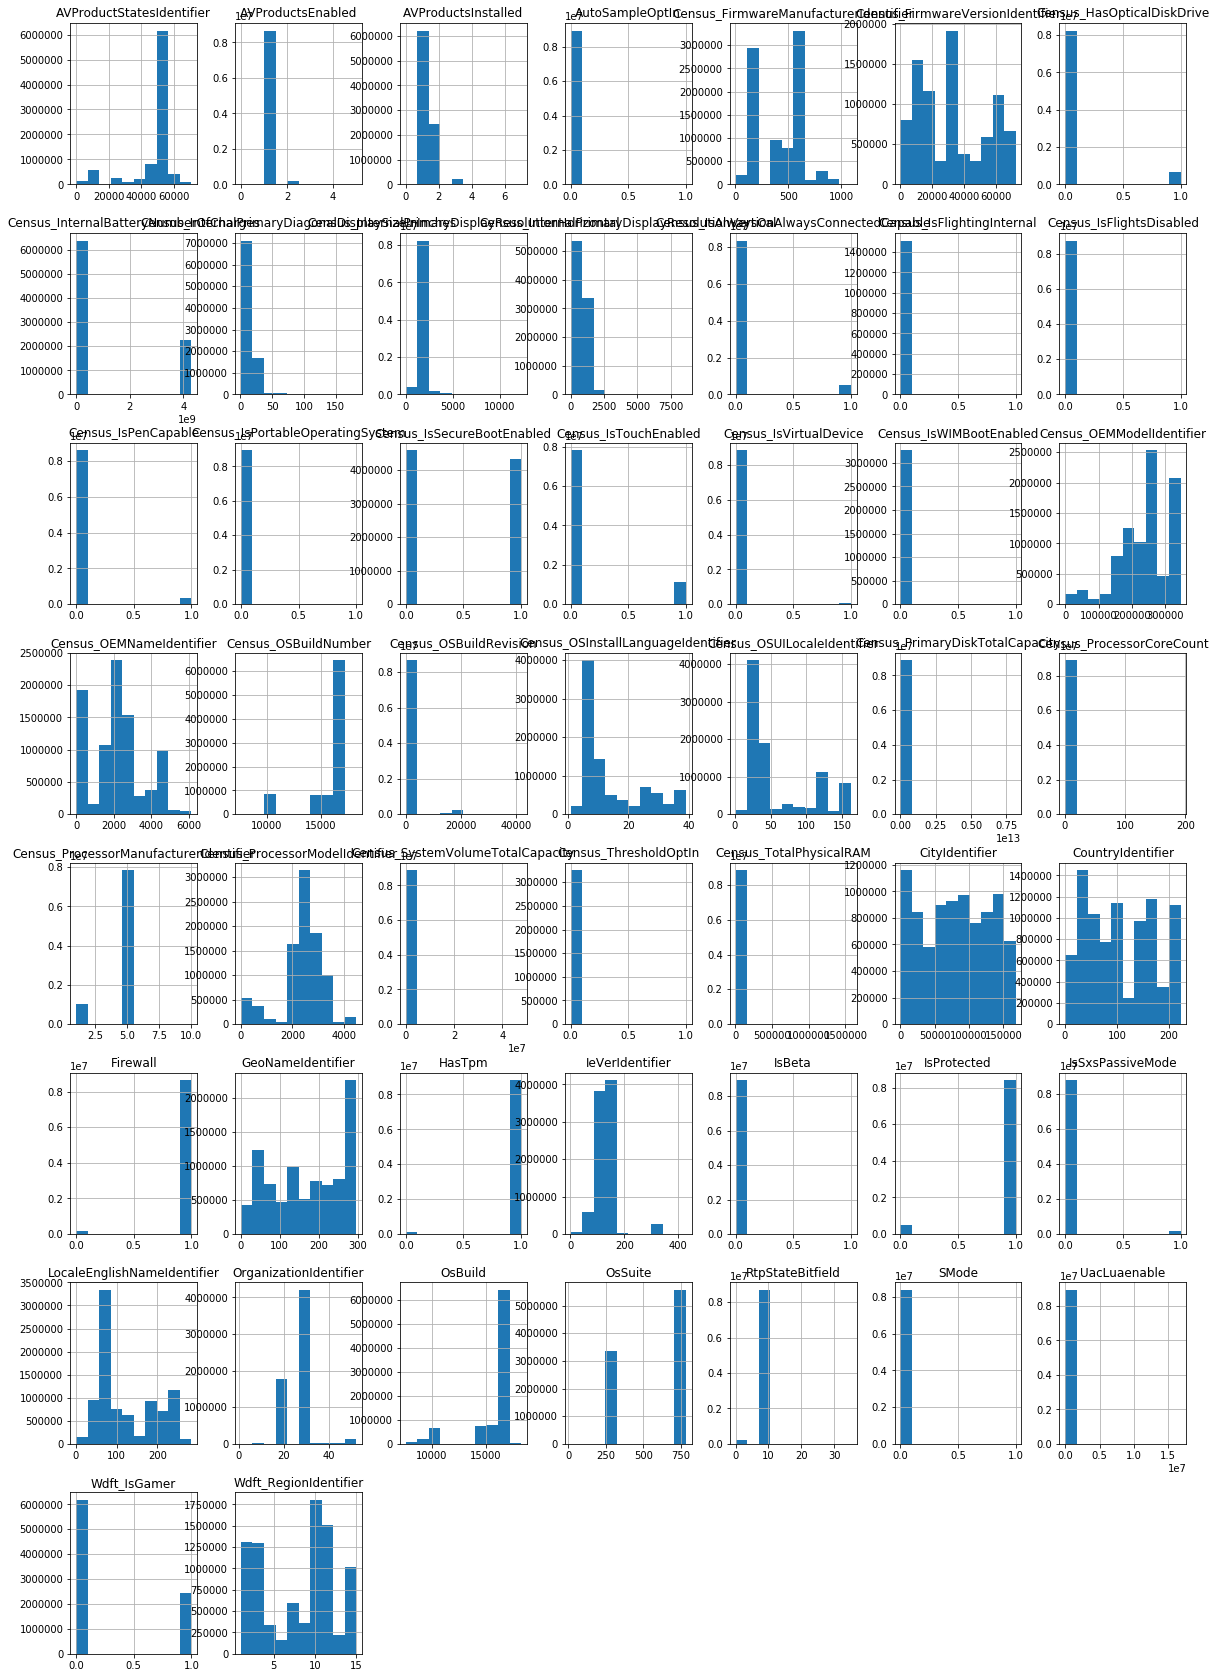

In [201]:
ns=data_raw.hist(figsize=(20,30))

In [134]:
det_by_platform = train_raw.groupby(['HasDetections', 'Platform']).size().to_frame('total').reset_index().sort_values(['Platform', 'total'], ascending=False)
det_by_platform['pct_total'] = det_by_platform.total/len(train_raw)*100

In [135]:
det_by_platform

HasDetections     Platform    total  pct_total
7              1     windows8    98561   1.104760
3              0     windows8    95947   1.075460
2              0     windows7    48211   0.540392
6              1     windows7    45678   0.512000
1              0  windows2016     9347   0.104770
5              1  windows2016     5024   0.056314
4              1    windows10  4309629  48.306195
0              0    windows10  4309086  48.300109

In [158]:
train_raw.Census_OSEdition.count()/len(train_raw)
train_raw.Platform.count()/len(train_raw)

1.0

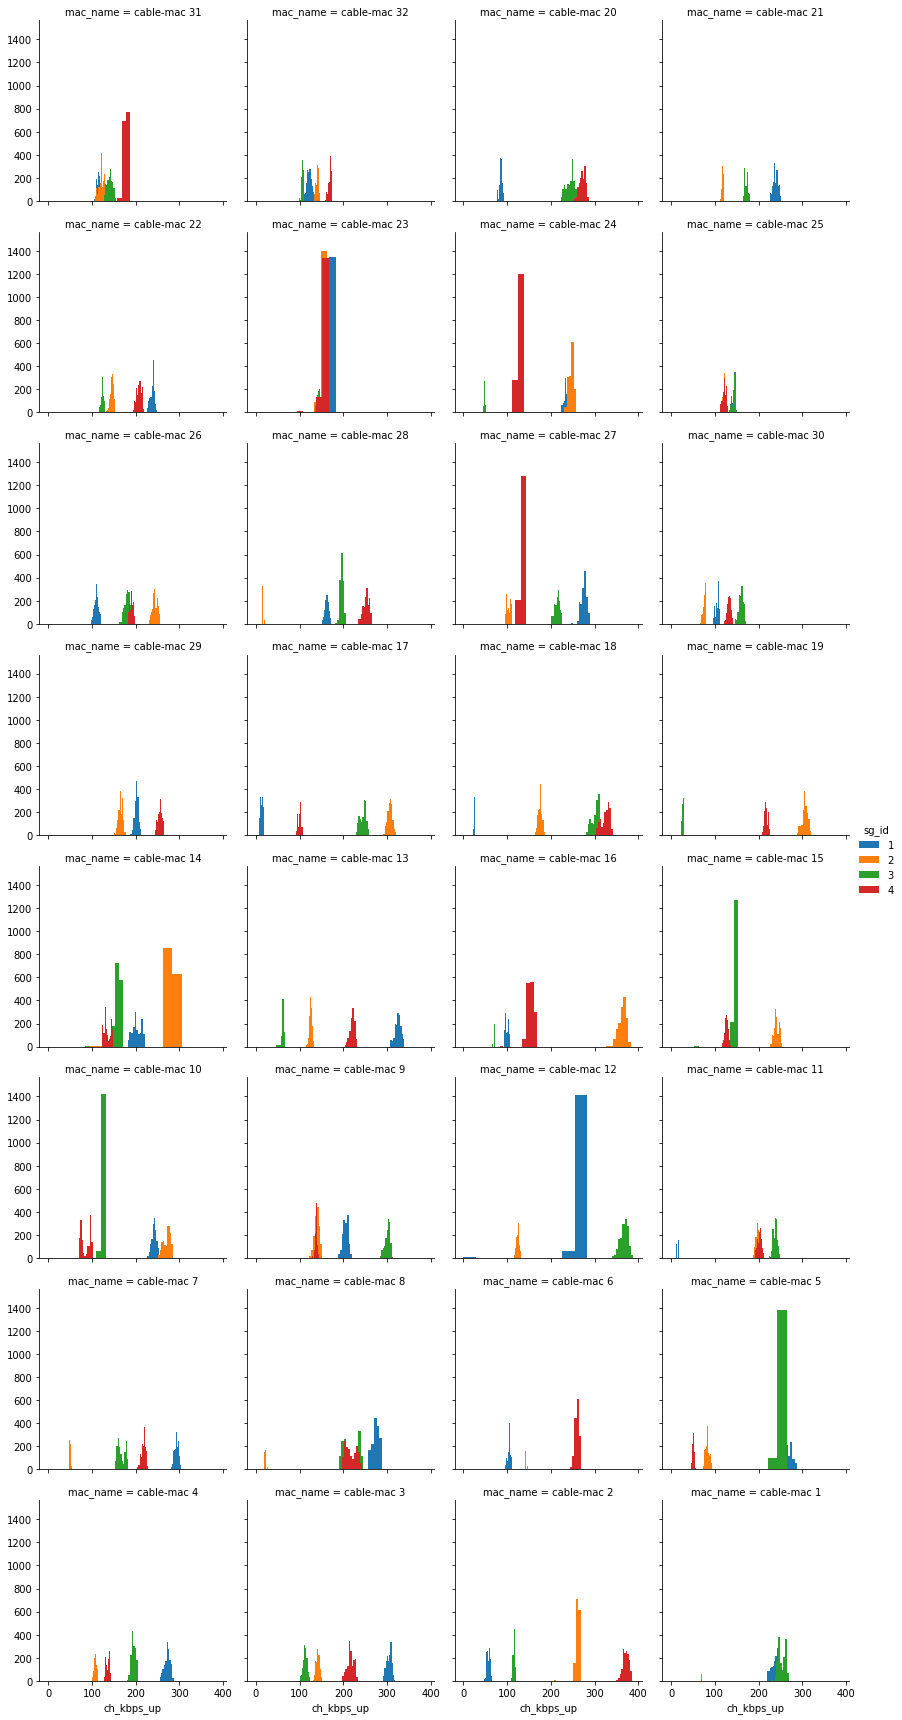

In [113]:
g = sns.FacetGrid(sg_up, col='mac_name', hue='sg_id', col_wrap=4)
ns = g.map(plt.hist, 'ch_kbps_up').add_legend()

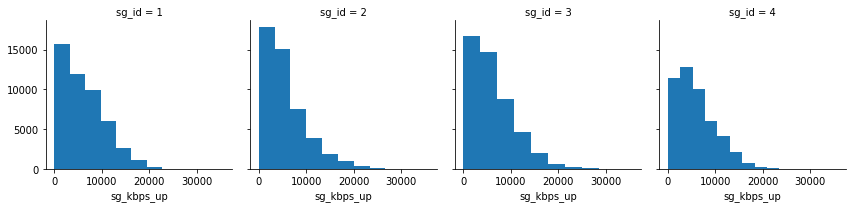

In [103]:
g = sns.FacetGrid(sg_up, col='sg_id')
ns = g.map(plt.hist, 'sg_kbps_up')

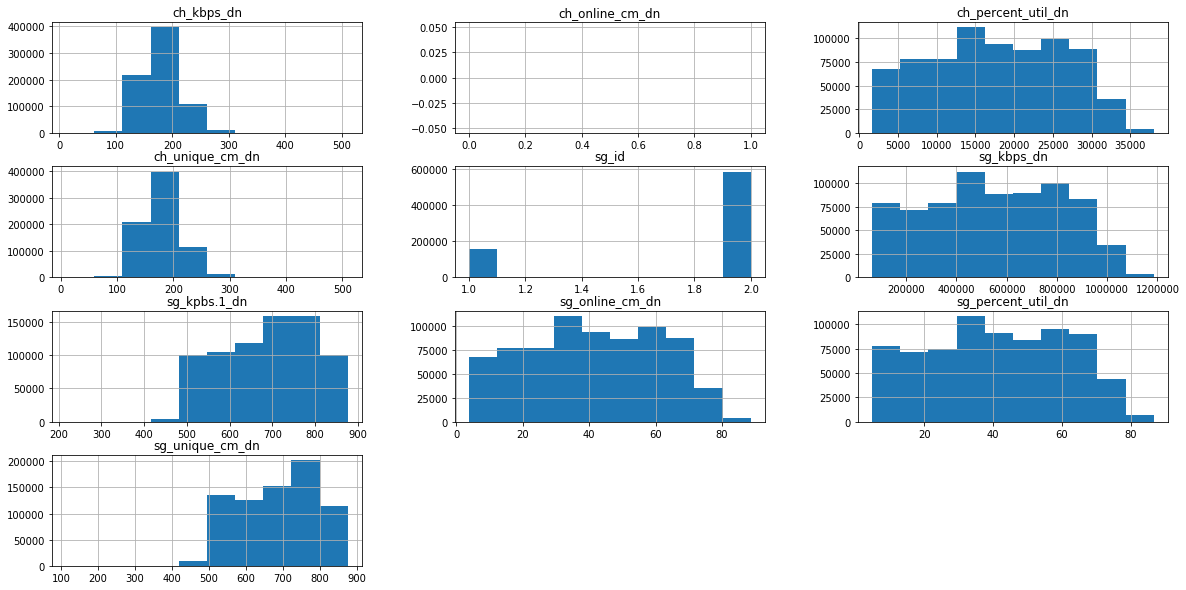

In [72]:
ns=sg_dn.hist(figsize=(20,10))

In [69]:
sg_dn.sg_id.unique()

array([2, 1])

In [285]:
data_1[data_1.subscriberID.isin(list(data_2.subscriberID))]

created                                id subscriberID  \
16  2016-06-22 00:29:53  0e1413af15dad8c6d15f0a8267a35df4         None   
80  2018-05-05 02:54:05  958d4eecffa8179bcfe827d0a9416ae5         None   
118 2017-07-15 00:22:43  5fce78dd19f6143be95162be2e370840         None   
253 2017-07-27 23:31:18  cb9b14f1f6eefb4549ff8a00380d7e54         None   
402 2018-03-11 05:09:05  e3e5a15dff98f040c6e7d12637e0a454         None   
469 2018-02-16 01:10:40  df9726693501c4ae85ec2c9f7493b387         None   

                         ts  created_year  created_month  created_day  \
16  2018-06-04 13:34:46.043          2016              6           22   
80  2018-06-04 13:36:37.866          2018              5            5   
118 2018-06-04 13:37:34.377          2017              7           15   
253 2018-06-04 13:41:24.693          2017              7           27   
402 2018-06-04 13:46:02.220          2018              3           11   
469 2018-06-04 13:47:35.218          2018              2           16   

     created_hour  created_minute  created_weekday  ts_year  ts_month  ts_day  \
16              0              29                2     2018         6       4   
80              2              54                5     2018         6       4   
118             0              22                5     2018         6       4   
253            23              31                3     2018         6       4   
402             5               9                6     2018         6       4   
469             1              10                4     2018         6       4   

     ts_hour  ts_minute  ts_weekday     OUI    Serial Number ISPUsername  USI  \
16        13         34           0  001E46  184795205906192         NaN  NaN   
80        13         36           0  001E46   65989514492032         NaN  NaN   
118       13         37           0  001E46   48921850812128         NaN  NaN   
253       13         41           0  001E46  268343179402176         NaN  NaN   
402       13         46           0  001E46   17961852595296         NaN  NaN   
469       13         47           0  001E46   17961852977600         NaN  NaN   

     WTN Host.1.Active Host.1.AddressSource      Host.1.HostName  \
16   NaN             1                 DHCP     amazon-e5cf3a735   
80   NaN             0                 DHCP        FRMS-S-BOOZER   
118  NaN             0                 DHCP    DESKTOP-1ULHIOS-1   
253  NaN             0                 DHCP             iPhone-2   
402  NaN             0                 DHCP         06ECPF02PUAL   
469  NaN             1                 DHCP  unknown001ac680fe6d   

    Host.1.IPAddress Host.1.IPv6Address.1.IPAddress  \
16    192.168.254.13                            NaN   
80    192.168.254.22                            NaN   
118   192.168.254.15                            NaN   
253   192.168.254.11                            NaN   
402   192.168.254.24                            NaN   
469   192.168.254.13                            NaN   

    Host.1.IPv6Address.1.X_0000C5_IPAddressStatus  \
16                                            NaN   
80                                            NaN   
118                                           NaN   
253                                           NaN   
402                                           NaN   
469                                           NaN   

    Host.1.IPv6Address.1.X_0000C5_Origin Host.1.IPv6Address.2.IPAddress  \
16                                   NaN                            NaN   
80                                   NaN                            NaN   
118                                  NaN                            NaN   
253                                  NaN                            NaN   
402                                  NaN                            NaN   
469                                  NaN                            NaN   

    Host.1.IPv6Address.2.X_0000C5_IPAddressStatus  \
16                                 

In [286]:
data_2[data_2.subscriberID.isin(list(data_1.subscriberID))]

created                                id subscriberID  \
317 2017-07-30 01:30:08  08c7e2bb926725bdd85ca64a4ab39bf7         None   
322 2017-12-08 03:20:43  112b2da1107a5d155046586fc743d134         None   
453 2017-12-29 03:44:20  dadd3aa49485b1748f0257f6dcd5d37f         None   
490 2018-03-22 22:41:03  6323d20dca6a8bc6a449d15b33fde76f         None   

                         ts  created_year  created_month  created_day  \
317 2018-06-04 13:44:46.435          2017              7           30   
322 2018-06-04 13:44:54.167          2017             12            8   
453 2018-06-04 13:48:12.654          2017             12           29   
490 2018-06-04 13:49:21.166          2018              3           22   

     created_hour  created_minute  created_weekday  ts_year  ts_month  ts_day  \
317             1              30                6     2018         6       4   
322             3              20                4     2018         6       4   
453             3              44                4     2018         6       4   
490            22              41                3     2018         6       4   

     ts_hour  ts_minute  ts_weekday     OUI    Serial Number ISPUsername  USI  \
317       13         44           0  001E46  268343179547824         NaN  NaN   
322       13         44           0  001E46   48921843060640         NaN  NaN   
453       13         48           0  001E46   17961852772880         NaN  NaN   
490       13         49           0  001E46  159006085278960         NaN  NaN   

     WTN Host.1.Active Host.1.AddressSource  Host.1.HostName Host.1.IPAddress  \
317  NaN             0                 DHCP   NYJTL6FRRF12-2   192.168.254.46   
322  NaN             0                 DHCP  DebDeb1s-iPhone   192.168.254.39   
453  NaN             0                 DHCP          host-18   192.168.254.37   
490  NaN             0                 DHCP  Galaxy-J3-Prime   192.168.254.12   

    Host.1.IPv6Address.1.IPAddress  \
317                            NaN   
322                            NaN   
453                            NaN   
490                            NaN   

    Host.1.IPv6Address.1.X_0000C5_IPAddressStatus  \
317                                           NaN   
322                                           NaN   
453                                           NaN   
490                                           NaN   

    Host.1.IPv6Address.1.X_0000C5_Origin Host.1.IPv6AddressNumberOfEntries  \
317                                  NaN                                 0   
322                                  NaN                                 0   
453                                  NaN                                 0   
490                                  NaN                                 0   

    Host.1.InterfaceType                             Host.1.Layer2Interface  \
317             Ethernet  InternetGatewayDevice.LANDevice.1.LANEthernetI...   
322               802.11  InternetGatewayDevice.LANDevice.1.WLANConfigur...   
453               802.11  InternetGatewayDevice.LANDevice.1.WLANConfigur...   
490               802.11  InternetGatewayDevice.LANDevice.1.WLANConfigur...   

    Host.1.LeaseTimeRemaining  Host.1.MACAddress Host.1.X_0000C5_LastActive  \
317                   2591999  ec:f4:bb:41:e0:f3   Mon May 21 12:12:01 2018   
322                         0  b8:53:ac:40:dd:62   Tue May 29 15:45:25 2018   
453                         0  88:78:73:11:70:d8   Mon May 21 19:29:55 2018   
490                   2591999  14:56:8e:8b:a1:41   Sat May 26 14:34:13 2018   

    Host.10.Active Host.10.AddressSource     Host.10.HostName  \
317            NaN                   NaN                  NaN   
322              0                  DHCP  unknown52c7be695377   
453              0                  DHCP              host-17   
490            NaN                   NaN                  NaN   

    Host.10.IPAddress Host.10.IPv6Address.1.IPAddress  \
317               NaN                 

In [289]:
data_2.count()

created                                          526
id                                               526
subscriberID                                     522
ts                                               526
created_year                                     526
created_month                                    526
created_day                                      526
created_hour                                     526
created_minute                                   526
created_weekday                                  526
ts_year                                          526
ts_month                                         526
ts_day                                           526
ts_hour                                          526
ts_minute                                        526
ts_weekday                                       526
OUI                                              526
Serial Number                                    526
ISPUsername                                   

In [276]:
data_1.head()

created                                id  \
0 2017-11-05 00:10:13  c09255d9310dd345f1f8bec237715ba6   
1 2018-02-14 05:25:16  6e994efd6777012136af8281283ab670   
2 2017-07-16 00:45:42  2ccb9c497fa9981b2eb2992df99f2aa3   
3 2017-09-21 23:22:54  a2195a6a49ce7d142d5b6d770212ae34   
4 2017-08-30 22:08:53  278add5abe66cac640271a064ce6889b   

                       subscriberID                      ts  created_year  \
0  06374d5652707604e053dbc8330a5686 2018-06-04 13:34:08.804          2017   
1  d4154c99109411e88272005056993951 2018-06-04 13:34:14.283          2018   
2  5dd2ed2f562d11e6a01e005056996a6d 2018-06-04 13:34:08.503          2017   
3  029cb71d385111e6a1c2005056994dd2 2018-06-04 13:34:09.165          2017   
4  07abf6f10ed611e798dc0050569972c7 2018-06-04 13:34:21.695          2017   

   created_month  created_day  created_hour  created_minute  created_weekday  \
0             11            5             0              10                6   
1              2           14             5              25                2   
2              7           16             0              45                6   
3              9           21            23              22                3   
4              8           30            22               8                2   

   ts_year  ts_month  ts_day  ts_hour  ts_minute  ts_weekday     OUI  \
0     2018         6       4       13         34           0  001E46   
1     2018         6       4       13         34           0  001E46   
2     2018         6       4       13         34           0  001E46   
3     2018         6       4       13         34           0  001E46   
4     2018         6       4       13         34           0  001E46   

     Serial Number ISPUsername           USI  WTN Host.1.Active  \
0  159006085149440         NaN  490003446567  NaN             1   
1  211793649189360         NaN  490218973587  NaN             0   
2  268343179516656         NaN  490169702175  NaN             0   
3  206906965707184         NaN  490165888853  NaN             1   
4   17961852680320         NaN  490190274178  NaN             0   

  Host.1.AddressSource           Host.1.HostName Host.1.IPAddress  \
0                 DHCP                    RM4100   192.168.254.10   
1                 DHCP           Marios-iPhone-3   192.168.254.10   
2                 DHCP           CrunchigNumbers   192.168.254.10   
3                 DHCP              Roku 1 - 399   192.168.254.10   
4                 DHCP  android-782077b318cb00da   192.168.254.21   

  Host.1.IPv6Address.1.IPAddress  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   

  Host.1.IPv6Address.1.X_0000C5_IPAddressStatus  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  Host.1.IPv6Address.1.X_0000C5_Origin Host.1.IPv6Address.2.IPAddress  \
0                                  NaN                            NaN   
1                                  NaN                            NaN   
2                                  NaN                            NaN   
3                                  NaN                            NaN   
4                                  NaN                            NaN   

  Host.1.IPv6Address.2.X_0000C5_IPAddressStatus  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  Host.1.IPv6Address.2.X_0000C5_Origin Host.1.IPv6AddressNumberOfEntries  \
0                                  NaN                                 0   
1                                  NaN    

In [6]:
data_1.created.head()

0   2017-11-05 00:10:13
1   2018-02-14 05:25:16
2   2017-07-16 00:45:42
3   2017-09-21 23:22:54
4   2017-08-30 22:08:53
Name: created, dtype: datetime64[ns]

In [7]:
data_2.created.head()

0   2016-12-24 00:29:28
1   2017-09-30 00:29:55
2   2018-05-09 23:44:00
3   2017-12-07 04:05:15
4   2018-04-20 23:24:22
Name: created, dtype: datetime64[ns]

In [8]:
%ls -ltr data
#%rm data/*.h5

total 154448
-rw-rw-r-- 1 jovyan  1000 17257024 Jun  4 15:12 element-ts-1.json
-rw-rw-r-- 1 jovyan  1000 17270331 Jun  4 15:12 element-ts-2.json
-rw-rw-r-- 1 jovyan  1000 17273365 Jun  4 15:12 element-ts-3.json
-rw-rw-r-- 1 jovyan  1000 16470971 Jun  4 15:12 element-ts-4.json
-rw-rw-r-- 1 jovyan  1000 17253455 Jun  4 15:12 element-ts-5.json
-rw-rw-r-- 1 jovyan  1000 16525465 Jun  4 15:12 element-ts-6.json
-rw-rw-r-- 1 jovyan  1000  4670501 Jun  4 15:12 hnc-1.json
-rw-rw-r-- 1 jovyan  1000  4811105 Jun  4 15:12 hnc-2.json
-rw-r--r-- 1 jovyan users 11328696 Jun  4 22:19 hnc-2.data.h5
-rw-r--r-- 1 jovyan users 10990224 Jun  4 22:19 hnc-2.prop.h5
-rw-r--r-- 1 jovyan users  1421064 Jun  4 22:19 hnc-2.conn_dev.h5
-rw-r--r-- 1 jovyan users 10714028 Jun  4 22:22 hnc-1.data.h5
-rw-r--r-- 1 jovyan users 10444980 Jun  4 22:22 hnc-1.prop.h5
-rw-r--r-- 1 jovyan users  1687672 Jun  4 22:22 hnc-1.conn_dev.h5


In [349]:
len(data[data.columns[data.count()>100]].count().to_dict())

189

** Connected devices: Host.Active columns only **

In [232]:
con_dev_count.sort_values(ascending=False)/(525)*100
con_dev_count.sort_values(ascending=False)
con_dev_1_dist = conn_dev_1.count(axis=1)
con_dev_2_dist = conn_dev_2.count(axis=1)

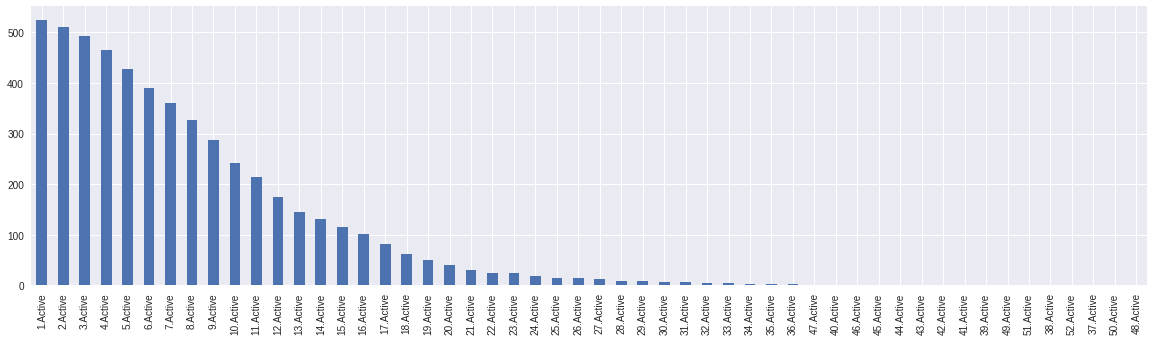

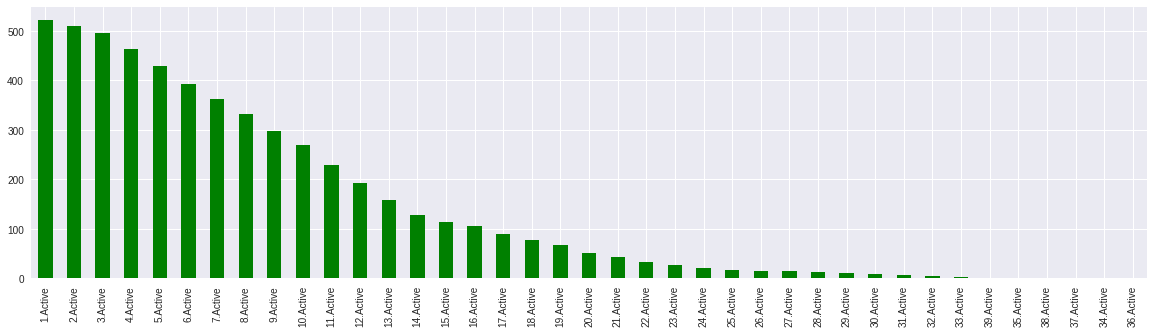

In [255]:
plt.subplots_adjust(top=.9, wspace=.2)
conn_dev_1.count().sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.figure()
p = conn_dev_2.count().sort_values(ascending=False).plot(kind='bar', figsize=(20,5), color='green')

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


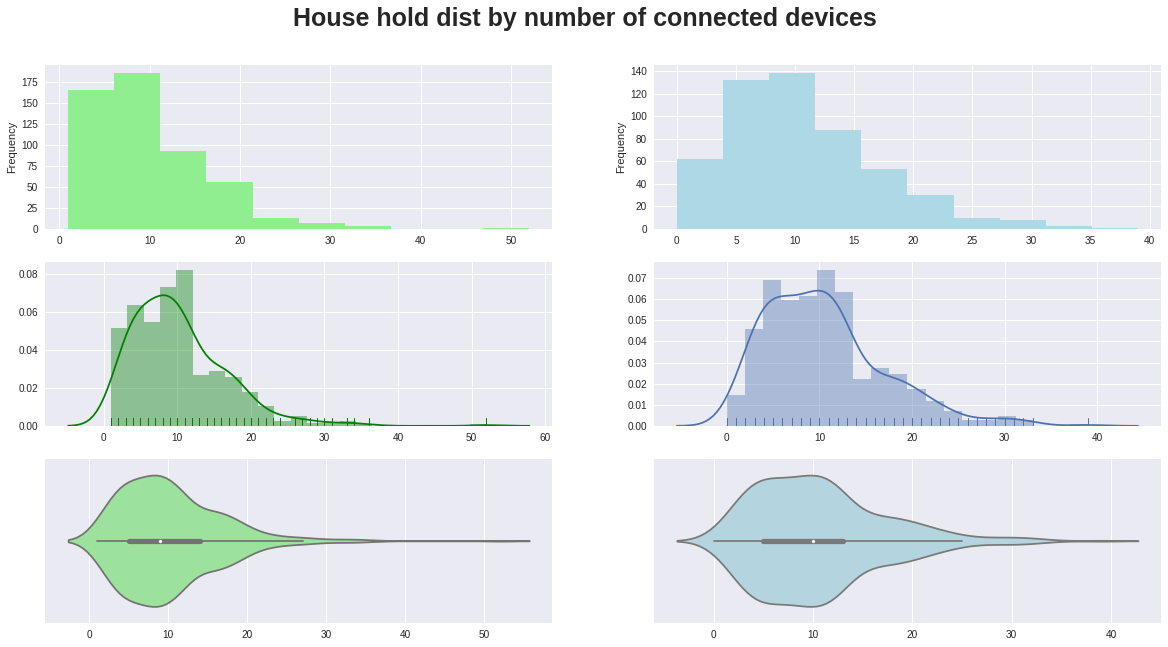

In [252]:
fig, axes = plt.subplots(nrows=3, ncols=2) 

fig.suptitle('House hold dist by number of connected devices', fontweight='bold', fontsize=25)
plt.subplots_adjust(top=.9, wspace=.2)

con_dev_1_dist.plot(ax=axes[0,0], kind='hist', color='lightgreen')
sns.distplot(con_dev_1_dist, hist=True, rug=True, color="green", ax=axes[1, 0])
sns.violinplot(con_dev_1_dist, split=True, color="lightgreen", ax=axes[2, 0])

con_dev_2_dist.plot(ax=axes[0,1], kind='hist', figsize=(20,10), color='lightblue')
sns.distplot(con_dev_2_dist, hist=True, rug=True, ax=axes[1, 1])
p=sns.violinplot(con_dev_2_dist, split=True, color="lightblue", ax=axes[2, 1])

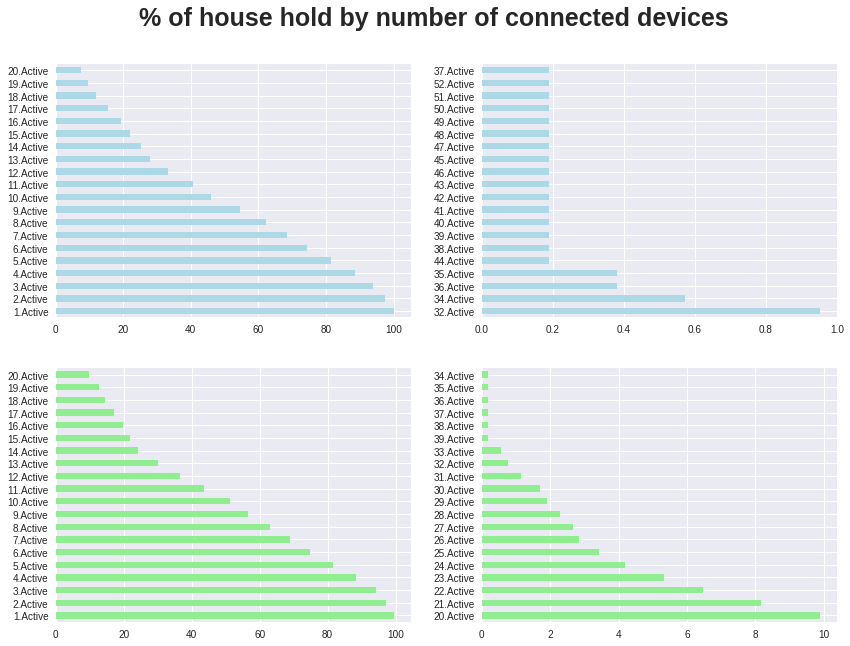

In [218]:
fig, axes = plt.subplots(nrows=2, ncols=2) 
fig.suptitle('% of house hold by number of connected devices', fontweight='bold', fontsize=25)
plt.subplots_adjust(top=.9, wspace=.2)

div = len(conn_dev_1)
(conn_dev_1.count().nlargest(20)/div*100).sort_values(ascending=False).plot(kind='barh', ax=axes[0,0], figsize=(14,10), color='lightblue')
(conn_dev_1.count().nsmallest(20)/div*100).sort_values(ascending=False).plot(kind='barh', ax=axes[0,1], color='lightblue')
div = len(conn_dev_2)
(conn_dev_2.count().nlargest(20)/div*100).sort_values(ascending=False).plot(kind='barh', ax=axes[1,0], color='lightgreen')
p=(conn_dev_2.count().nsmallest(20)/div*100).sort_values(ascending=False).plot(kind='barh', ax=axes[1,1], color='lightgreen')

In [270]:
prop_df_1.count()

prop_df_1.modelName.value_counts()
prop_df_2.modelName.value_counts()

prop_df_1.manufacturerName.value_counts()
prop_df_2.manufacturerName.value_counts()

prop_df_1.softwareVersion.value_counts()
prop_df_2.softwareVersion.value_counts()


prop_df_1.count()

Host.1.Active                                     525
Host.1.AddressSource                              525
Host.1.HostName                                   525
Host.1.IPAddress                                  525
Host.1.IPv6Address.1.IPAddress                      1
Host.1.IPv6Address.1.X_0000C5_IPAddressStatus       1
Host.1.IPv6Address.1.X_0000C5_Origin                1
Host.1.IPv6Address.2.IPAddress                      1
Host.1.IPv6Address.2.X_0000C5_IPAddressStatus       1
Host.1.IPv6Address.2.X_0000C5_Origin                1
Host.1.IPv6AddressNumberOfEntries                 525
Host.1.InterfaceType                              525
Host.1.Layer2Interface                            525
Host.1.LeaseTimeRemaining                         525
Host.1.MACAddress                                 525
Host.1.X_0000C5_LastActive                        525
Host.10.Active                                    242
Host.10.AddressSource                             242
Host.10.HostName            

In [13]:
data.shape

(273771, 52)

In [11]:
data.count().to_dict()

{'ACRD_DCON_DATE': 273771,
 'ACRD_INSTALL_DATE': 273771,
 'BOUNCE_OWNER': 273771,
 'CURR_FAILURE_CODE': 228288,
 'CURR_RECV_DATE': 273771,
 'CURR_REC_LOC': 273771,
 'CURR_REPAIR_RMA_NBR': 29839,
 'CURR_RO_NBR': 273771,
 'CUSTOMER_TENURE': 273771,
 'CUST_ACCOUNT_KEY': 273771,
 'DATE_OF_MFR': 273447,
 'DAYS_ACTIVE': 273771,
 'HSIA_SPEED': 273771,
 'INSTALL_CATEGORY': 273771,
 'MFR_AGE': 273447,
 'MFR_MDL_CODE': 273771,
 'MODEL': 273771,
 'PA_REPAIR_ORD': 273771,
 'PREV_FAILURE_CODE': 27082,
 'PREV_RECV_DATE': 27120,
 'PREV_RO_NBR': 27120,
 'PREV_SHIP_DATE': 27120,
 'PREV_SHIP_LOC': 27120,
 'PROB_DESC': 273771,
 'PRODUCT_MIX': 273771,
 'REFURB_AGE': 27120,
 'RMA_MONTHDAY_KEY': 273771,
 'RMA_NUM_ID': 273771,
 'RMA_RSN_DESC': 273771,
 'RMA_RTN_RSN_DESC': 273771,
 'RMA_SER_ID': 273771,
 'SERIAL_NBR': 273771,
 'SOFTWARE_VERSION': 273771,
 'SVC_NIELSEN_DMA_DESC': 270104,
 'TECHN_ACTN_DESC': 258306,
 'TECH_NOTES': 264821,
 'TRANSPORT_TYPE': 273771}

In [89]:
dc = list(data.columns)
dc.sort()
dc

['ACRD_DCON_DATE',
 'ACRD_INSTALL_DATE',
 'BOUNCE_OWNER',
 'CURR_FAILURE_CODE',
 'CURR_RECV_DATE',
 'CURR_RECV_DAY',
 'CURR_RECV_MONTH',
 'CURR_RECV_MONTH_CAT',
 'CURR_RECV_WEEKDAY',
 'CURR_RECV_YEAR',
 'CURR_REC_LOC',
 'CURR_REPAIR_RMA_NBR',
 'CURR_RO_NBR',
 'CUSTOMER_TENURE',
 'CUST_ACCOUNT_KEY',
 'DATE_OF_MFR',
 'DAYS_ACTIVE',
 'HSIA_SPEED',
 'INSTALL_CATEGORY',
 'LOAD_MONTH_CAT',
 'LOAD_WEEKDAY',
 'MFR_AGE',
 'MFR_DAY',
 'MFR_MDL_CODE',
 'MFR_MONTH',
 'MFR_MONTH_CAT',
 'MFR_WEEKDAY',
 'MFR_YEAR',
 'MODEL',
 'PA_REPAIR_ORD',
 'PREV_FAILURE_CODE',
 'PREV_RECV_DATE',
 'PREV_RECV_DAY',
 'PREV_RECV_MONTH',
 'PREV_RECV_MONTH_CAT',
 'PREV_RECV_WEEKDAY',
 'PREV_RECV_YEAR',
 'PREV_RO_NBR',
 'PREV_SHIP_DATE',
 'PREV_SHIP_DAY',
 'PREV_SHIP_LOC',
 'PREV_SHIP_MONTH',
 'PREV_SHIP_MONTH_CAT',
 'PREV_SHIP_WEEKDAY',
 'PREV_SHIP_YEAR',
 'PROB_DESC',
 'PRODUCT_MIX',
 'REFURB_AGE',
 'RMA_MONTHDAY_KEY',
 'RMA_NUM_ID',
 'RMA_POST_MONTH_CAT',
 'RMA_POST_WEEKDAY',
 'RMA_RSN_DESC',
 'RMA_RTN_MONTH_CAT',
 '

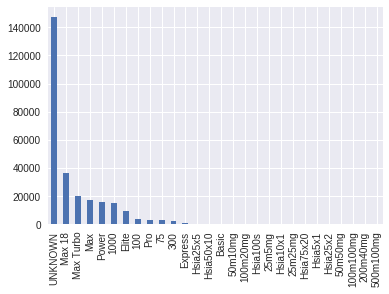

In [111]:
data.HSIA_SPEED.value_counts().plot(kind='bar', figsize=)

In [282]:
#rd = data.PRODUCT_MIX.replace({'N/A':0,'HSIA':1, 'VIDEO':1, 'VOICE':1})
#rd.value_counts()
#prod_mix = data.PRODUCT_MIX.str.replace('N/A','0')

dd = data
prod_mix = data.PRODUCT_MIX.str.split(pat='-', expand=True)
prod_mix.columns = ['HSIA', 'VIDEO', 'VOICE']
prod_mix.replace({'N/A':0,'HSIA':1, 'VIDEO':1, 'VOICE':1}, inplace=True)
prod_mix.head()
dd['HSIA'] = prod_mix['HSIA']
dd['VIDEO'] = prod_mix['VIDEO']
dd['VOICE'] = prod_mix['VOICE']
dd.head()
#dd = dd.append(prod_mix)
#dd.head()
#prod_mix.head()
#data['HSIA'] = prod_mix.HSIA
#data.columns
#data.TRANSPORT_TYPE.value_counts()

BOUNCE_OWNER INSTALL_CATEGORY    SERIAL_NBR DATE_OF_MFR  MFR_AGE   MODEL  \
0        ARRIS    30-day Bounce  20161N027304         NaT      NaN  5268AC   
1        ARRIS    30-day Bounce  30151N040639         NaT      NaN  5268AC   
2        ARRIS    30-day Bounce  41151N034995         NaT      NaN  5268AC   
3        ARRIS    30-day Bounce  22161N042356         NaT      NaN  5268AC   
4        ARRIS    30-day Bounce  43151N012532         NaT      NaN  5268AC   

  CURR_RO_NBR  CURR_REC_LOC      CURR_RECV_DATE CURR_FAILURE_CODE  \
0    NL0VYV93  Nuevo Laredo 2016-08-01 01:10:00               NTF   
1    NL0VYVFG  Nuevo Laredo 2016-08-01 01:20:00              2W03   
2    NL0VYWJG  Nuevo Laredo 2016-08-01 02:20:00               NTF   
3    NL0VYWJQ  Nuevo Laredo 2016-08-01 02:21:00               NTF   
4    NL0VYX17  Nuevo Laredo 2016-08-01 02:48:00               NTF   

  CURR_REPAIR_RMA_NBR PREV_RO_NBR PREV_RECV_DATE PREV_FAILURE_CODE  \
0                 NaN         NaN            NaT               NaN   
1       FLX6000217072         NaN            NaT               NaN   
2                 NaN         NaN            NaT               NaN   
3                 NaN         NaN            NaT               NaN   
4                 NaN         NaN            NaT               NaN   

  PREV_SHIP_LOC PREV_SHIP_DATE  REFURB_AGE    RMA_SER_ID RMA_NUM_ID  \
0           NaN            NaT         NaN  20161N027304  400197900   
1           NaN            NaT         NaN  30151N040639  393705841   
2           NaN            NaT         NaN  41151N034995  400620460   
3           NaN            NaT         NaN  22161N042356  402002409   
4           NaN            NaT         NaN  43151N012532  401476633   

  RMA_MONTHDAY_KEY MFR_MDL_CODE  \
0          7/16/16       5268AC   
1           6/9/16       5268AC   
2          7/18/16       5268AC   
3          7/26/16       5268AC   
4          7/23/16       5268AC   

                                        RMA_RSN_DESC      RMA_RTN_RSN_DESC  \
0  All Prod No Svc-CPE Sync No Svc-Dispatched to ...  DISPATCH - TECHNICAL   
1    Phone No Svc-Inside Issue-Dispatched to Premise  DISPATCH - TECHNICAL   
2  Internet No Svc-No Connectivity-Dispatched to ...  DISPATCH - TECHNICAL   
3  All Prod Intermittent-CPE No Sync-Dispatched t...  DISPATCH - TECHNICAL   
4  Internet Impaired-Inside Issue-Dispatched to P...  DISPATCH - TECHNICAL   

                                           PROB_DESC ACRD_INSTALL_DATE  \
0  PROBLEM:   uverse services,RESOLUTION:  ISSUE:...        2016-07-16   
1                                            UNKNOWN        2016-06-04   
2                                            UNKNOWN        2016-06-25   
3                                            UNKNOWN        2016-07-23   
4  PROBLEM:   She was with someone while doing so...        2016-07-23   

  ACRD_DCON_DATE  CUST_ACCOUNT_KEY                 TECHN_ACTN_DESC  \
0     2016-07-20         153991837  Trouble to Residential Gateway   
1     2016-06-11         153029332             Residential Gateway   
2     2016-07-23         153492262  Trouble to Residential Gateway   
3     2016-07-27         154154178                  U-verse jumper   
4     2016-07-27         154182287  Trouble to Residential Gateway   

         SVC_NIELSEN_DMA_DESC  DAYS_ACTIVE   SOFTWARE_VERSION  \
0          ODESSA-MIDLAND, TX            4            UNKNOWN   
1                     UNKNOWN            7  10.5.3.527171-att   
2  LITTLE ROCK-PINE BLUFF, AR           28            UNKNOWN   
3  LITTLE ROCK-PINE BLUFF, AR            4            UNKNOWN   
4               ST. LOUIS, MO            4            UNKNOWN   

       PRODUCT_MIX TRANSPORT_TYPE HSIA_SPEED CUSTOMER_TENURE  \
0  N/A-VIDEO-VOICE             BP    UNKNOWN        <90 days   
1   HSIA-N/A-VOICE         IP-DSL     Max 18        <90 days   
2    N/A-VIDEO-N/A           FTTN    UNKNOWN        <90 days   
3  N/A-VIDEO-VOICE           FTTN    UNKNOWN        <90 days   
4    N/A-N/A-

## Multiple Correspondence Analysis ##

NameError: name 'cat_data' is not defined

In [58]:
import mca

In [ ]:
mca_counts = mca.MCA(cat_data)